High Value Customers Identification

# Project Solution Planning

Churn analytics: 
- Churn (or attrition), in the simplest terms, is when customers leave and stop buying your product or using your service during a defined time frame.

- In order to do keep churn rates as close to zero as possible, companies in nearly every industry need to treat churn as a top priority. If ignored, churn can plateau the growth of any business, even the ones that can gain customers quickly.

## Inputs

1. Problema de Negócio
    - Taxa de churn aumentou nos últimos meses
    - Rankear os clientes com maiores probabilidades de entrar em churn

2. Conjunto de dados
    - Atributos que descrevem os clientes de um determinado banco: ChrunDataset Kaggle

## Output

1. Indicação das pessoas que irão entrar em churn
    - Coluna em tabela com rankeado das pessoas com propensão de entrar em churn
    - Modelo em produção
    
2. Relatório com performance do modelo e respostas das perguntas:
     - Qual a taxa atual de Churn da TopBank? Como ela varia mensalmente?
     - Qual a Performance do modelo em classificar os clientes como churns?
     - Qual o retorno esperado, em termos de faturamento, se a empresa utilizar seu modelo para evitar o churn dos clientes?
     - Para quais clientes você daria o incentivo financeiro e qual seria esse valor, de modo a maximizar o ROI (Retorno sobre o investimento). Lembrando que a soma dos incentivos não pode ultrapassar os  R$10.000,00
    

## Tasks

1. Qual a taxa atual de Churn da TopBank? Como ela varia mensalmente?
    - Calcular taxa atual, somatório da coluna target divido pelo número total de clientes da base
    
2. Qual a Performance do modelo em classificar os clientes como churns?
    - Calculo da performance do modelo
    - Verificar métricas de performance learning to rank
    
3. Qual o retorno esperado, em termos de faturamento, se a empresa utilizar seu modelo para evitar o churn dos clientes?
    - Curva lift para comparação do modelo com o status quo da empresa e apresentação do resultado
    - Calcular diferença em reais do modelo
    - Calcular ROI
    - Comparativo entre ROIs

4. Para quais clientes você daria o incentivo financeiro e qual seria esse valor, de modo a maximizar o ROI (Retorno sobre o investimento). Lembrando que a soma dos incentivos não pode ultrapassar os  R$10.000,00
    - Classificar quais clientes trarão mais retorno para empresa com o incentivo.
    

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import inflection
import matplotlib.pyplot as plt 

import missingno as msno

from scipy                   import stats
from IPython.core.display    import HTML
from IPython.display         import Image

In [2]:
os.getcwd()

'/home/marxcerqueira/repos/Data-Science-Projects/Kaggle-Client-Churn-Prediction/notebooks'

## Helper Functions

In [134]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

# point biserial correlation coefficient heatmap function
def point_bi_corr(a, b):
    # a: input dataframe with binary variable
    # b: input dataframe with continuous variable
    
    # get column name
    a_name = a.columns[0]
    b_name = b.columns[0]
    
    # transform dataframe to array
    a = a.values.reshape(-1)
    b = b.values.reshape(-1)
    
    # apply scipy's point-biserial
    stats.pointbiserialr(a, b)
    
    # correlation coefficient array
    c = np.corrcoef(a,b)
    
    # dataframe for heatmap
    df = pd.DataFrame(c, columns=[a_name, b_name], index=[a_name, b_name])
    
    # return heatmap
    return sns.heatmap(df, annot=True).set_title('{} x {} correlation heatmap'.format(a_name, b_name));
    
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values # Confusion Matrix
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

# def mean_absolute_percentage_error( y, yhat ):
#     return np.mean( np.abs( ( y-yhat ) / y ))

# def mean_percentage_error( y, yhat ):
#     return np.mean( ( y - yhat ) / y )

# def ml_error ( model_name, y, yhat):
#     mae = mean_absolute_error( y,yhat )
#     mape = mean_absolute_percentage_error( y,yhat )
#     rmse = np.sqrt(mean_squared_error( y,yhat ))
    
#     return pd.DataFrame( {'Model Name': model_name,
#                           'MAE': mae,
#                           'MAPE': mape,
#                           'RMSE': rmse}, index=[0])

# def cross_validation( x_training, kfold, model_name, model, verbose=False ):
#     mae_list = []
#     mape_list = []
#     rmse_list = []
    
#     for k in reversed( range( 1, kfold+1 ) ):
#         if verbose:
#             print( '\nKFold Number: {}'.format( k ) )
#         # start and end date for validation 
#         start_date_validation = x_training['date'].max() - datetime.timedelta( days=k*6*7)
#         end_date_validation = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

#         # filtering dataset
#         training = x_training[x_training['date'] < start_date_validation]
#         validation = x_training[(x_training['date'] >= start_date_validation) & (x_training['date'] <= end_date_validation)]

#         # training and validation dataset
#         # training
#         xtraining = training.drop( ['date', 'sales'], axis=1 ) 
#         ytraining = training['sales']

#         # validation
#         xvalidation = validation.drop( ['date', 'sales'], axis=1 )
#         yvalidation = validation['sales']

#         # model
#         m = model.fit( xtraining, ytraining )

#         # prediction
#         yhat = m.predict( xvalidation )

#         # performance
#         m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

#         # store performance of each kfold iteration
#         mae_list.append(  m_result['MAE'] )
#         mape_list.append( m_result['MAPE'] )
#         rmse_list.append( m_result['RMSE'] )

#     return pd.DataFrame( {'Model Name': model_name,
#                           'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
#                           'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
#                           'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## Loading Dataset

 - **Source**: https://www.kaggle.com/mervetorkan/churndataset

In [5]:
df_churn_raw = pd.read_csv('/home/marxcerqueira/repos/Data-Science-Projects/Kaggle-Client-Churn-Prediction/data/raw/churn.csv', low_memory = False)

In [6]:
df_churn_raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**Feature Description**:

- **RowNumber**: The number of the columns.
- **CustomerID**: Unique client identifier.
- **Surname**: Client's surname.
- **CreditScore**: Client's credit card score for the financial market A pontuação de Crédito do cliente para o mercado de consumo.
- **Geography**: The country where the client lives.
- **Gender**: Client's gender.
- **Age**: Client's age.
- **Tenure**: The number of years the client remained activate in the bank.
- **Balance**: The monetary amount the client has in their current account.
- **NumOfProducts**: The number of products purchased by the client.
- **HasCrCard**: Point if the client has a credit card.
- **IsActiveMember**: Tell if the client is an active member of the bank (within the last 12 months).
- **EstimateSalary**: Client's annual salary estimate.
- **Exited**: Indicates if the client is a churn (tagert variable).

# DATA DISCRIPTION

In [7]:
# copy dataset
df0 = df_churn_raw.copy()

## Rename Columns

In [8]:
cols_old = list(df0)
snakecase = lambda x: inflection.underscore(x)
col_news = list(map(snakecase, cols_old))

# Rename columns
df0.columns = col_news
list(df0)

['row_number',
 'customer_id',
 'surname',
 'credit_score',
 'geography',
 'gender',
 'age',
 'tenure',
 'balance',
 'num_of_products',
 'has_cr_card',
 'is_active_member',
 'estimated_salary',
 'exited']

In [9]:
df0.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**Feature Description**:

- **RowNumber**: The number of the columns.
- **CustomerID**: Unique client identifier.
- **Surname**: Client's surname.
- **CreditScore**: Client's credit card score for the financial market A pontuação de Crédito do cliente para o mercado de consumo.
- **Geography**: The country where the client lives.
- **Gender**: Client's gender.
- **Age**: Client's age.
- **Tenure**: The number of years the client remained activate in the bank.
- **Balance**: The monetary amount the client has in their current account.
- **NumOfProducts**: The number of products purchased by the client.
- **HasCrCard**: Point if the client has a credit card.
- **IsActiveMember**: Tell if the client is an active member of the bank (within the last 12 months).
- **EstimateSalary**: Client's annual salary estimate.
- **Exited**: Indicates if the client is a churn (tagert variable).

## Data Dimension and Type

In [10]:
print('Number of rows: {}'.format(df0.shape[0]))
print('Number of columns: {}'.format(df0.shape[1]))

Number of rows: 10000
Number of columns: 14


In [11]:
# check columns datatypes
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            10000 non-null  int64  
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


## Check for duplicates

In [12]:
# duplicates 

df0.duplicated(subset='customer_id').sum()

0

## Check NA Values

In [13]:
missing_count = df0.isnull().sum()
value_count = df0.isnull().count()

missing_percentage = round(missing_count/value_count*100, 2)
missing_df = pd.DataFrame({'missing value count': missing_count, 'percentage (%)': missing_percentage })
missing_df

,missing value count,percentage (%)
row_number,0,0.0
customer_id,0,0.0
surname,0,0.0
credit_score,0,0.0
geography,0,0.0
gender,0,0.0
age,0,0.0
tenure,0,0.0
balance,0,0.0
num_of_products,0,0.0


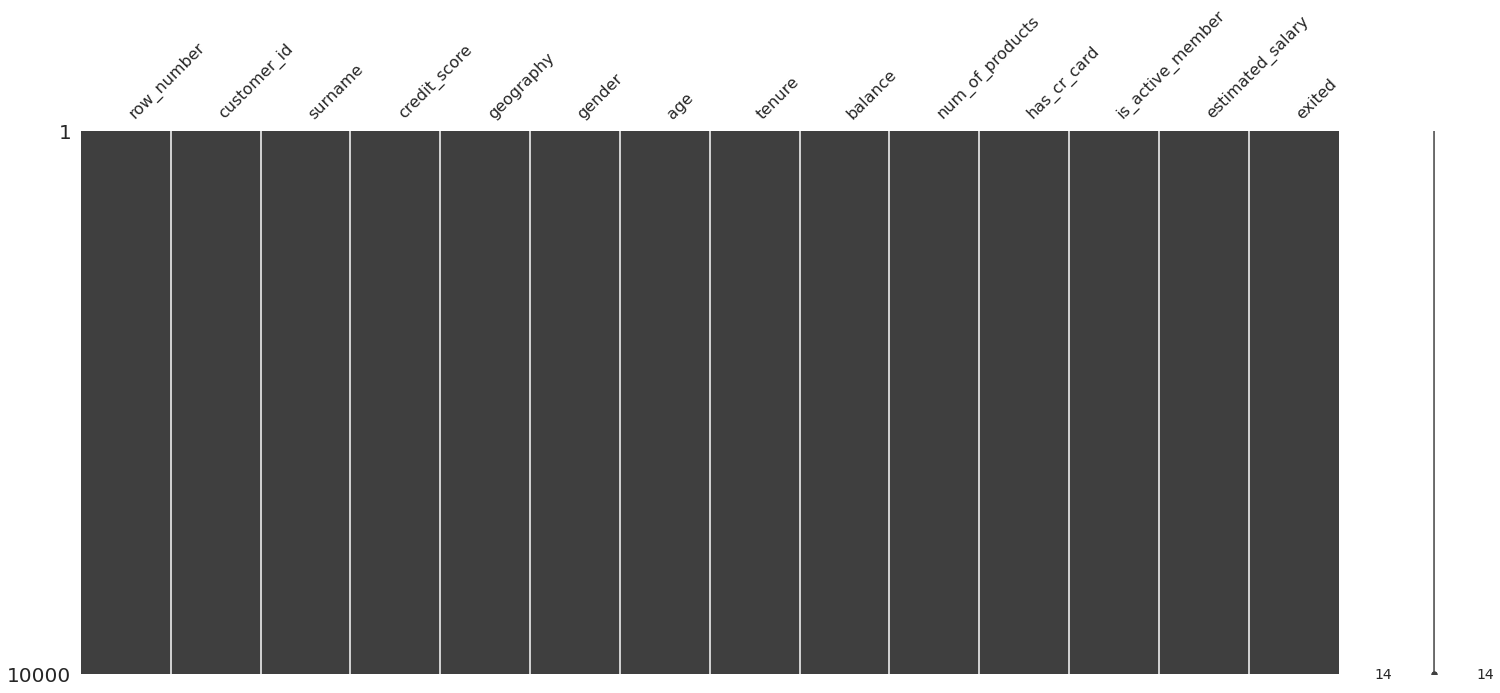

In [14]:
# check no missing values to confirm
msno.matrix(df0);

## Descriptive Statistics

In [15]:
df0.describe()

,row_number,customer_id,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [16]:
list(df0)

['row_number',
 'customer_id',
 'surname',
 'credit_score',
 'geography',
 'gender',
 'age',
 'tenure',
 'balance',
 'num_of_products',
 'has_cr_card',
 'is_active_member',
 'estimated_salary',
 'exited']

In [17]:
# # transforming categorical 1 or 0 values into 'yes' or 'no
# col_transform = ['has_cr_card', 'is_active_member']

# for col in col_transform:
#     df0[col] = df0[col].astype('str') 

# for col in col_transform:
#     df0[col] = df0[col].apply(lambda x: 'yes' if x=='1' else 'no')


In [18]:
# separate numerical and categorical attributes

num_att = df0.select_dtypes(include = 'number')
cat_att = df0.select_dtypes(include = 'object')

### Numerical Attributes

In [19]:
# Central Tendency - Mean, median
ct1 = pd.DataFrame( num_att.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_att.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtoisis
d1 = pd.DataFrame(num_att.apply( np.std )).T
d2 = pd.DataFrame(num_att.apply( min )).T
d3 = pd.DataFrame(num_att.apply( max )).T
d4 = pd.DataFrame(num_att.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_att.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_att.apply( lambda x: x.kurtosis() )).T

#concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()


m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,row_number,1.00,10000.00,9999.00,5.000500e+03,5.000500e+03,2886.751332,0.000000,-1.200000
1,customer_id,15565701.00,15815690.00,249989.00,1.569094e+07,1.569074e+07,71932.589224,0.001149,-1.196113
2,credit_score,350.00,850.00,500.00,6.505288e+02,6.520000e+02,96.648466,-0.071607,-0.425726
3,age,18.00,92.00,74.00,3.892180e+01,3.700000e+01,10.487282,1.011320,1.395347
4,tenure,0.00,10.00,10.00,5.012800e+00,5.000000e+00,2.892030,0.010991,-1.165225
5,balance,0.00,250898.09,250898.09,7.648589e+04,9.719854e+04,62394.285254,-0.141109,-1.489412
6,num_of_products,1.00,4.00,3.00,1.530200e+00,1.000000e+00,0.581625,0.745568,0.582981
7,has_cr_card,0.00,1.00,1.00,7.055000e-01,1.000000e+00,0.455818,-0.901812,-1.186973
8,is_active_member,0.00,1.00,1.00,5.151000e-01,1.000000e+00,0.499772,-0.060437,-1.996747
9,estimated_salary,11.58,199992.48,199980.90,1.000902e+05,1.001939e+05,57507.617221,0.002085,-1.181518


In [20]:
num_att.apply( lambda x: x.unique().shape[0])

row_number          10000
customer_id         10000
credit_score          460
age                    70
tenure                 11
balance              6382
num_of_products         4
has_cr_card             2
is_active_member        2
estimated_salary     9999
exited                  2
dtype: int64

/home/marxcerqueira/.pyenv/versions/3.9.1/envs/Client-Churn-Prediction/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


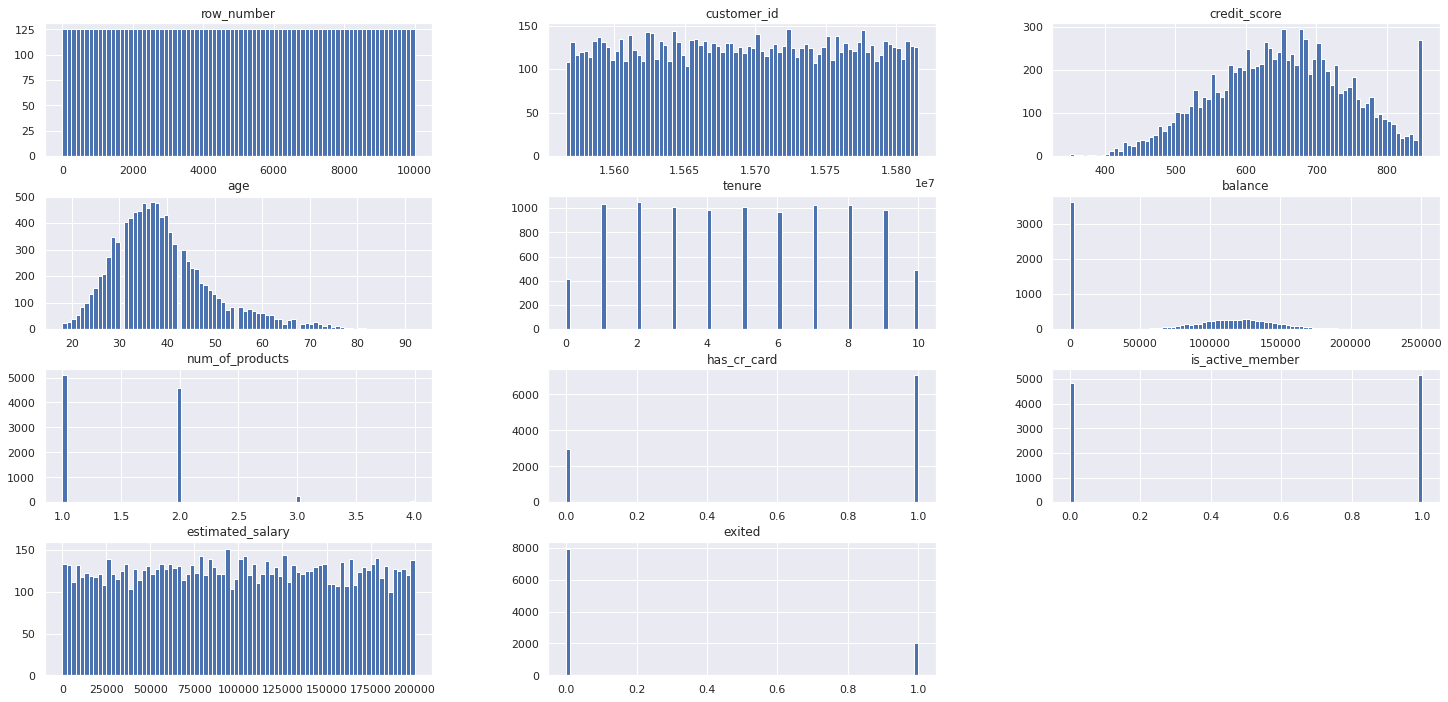

In [21]:
num_att.hist(bins = 80);

 
- Credit score ranges from 350 up to 850. Mean = 650.75. Median = 652.

- Age ranges from 18 up to 92. Mean = 38.95. Median = 37. 75% of the observations are up to the age 44.

- Tenure (number of years that the customer was active) ranges from 0 to 10. Mean = 5.02. Median = 5. 

- According the histogram, the number of customers with tenure equal to zero and 10 is lower than the other tenure values.

- Balance ranges from zero up to 238,387. Mean = 76,381. Median = 97,055. 25% of the observations have value equal to zero.

- Number of products ranges from 1 to 4. Mean = 1.53. Median = 1. 75% of the observations have value equal to 2. The histogram shows that the majority of number of products is 1 and 2. There is no number of products equal to zero, that is, all customers have bought at least one product.

- has_cr_card mean = 0.7087, that is, 70.87% of the observations have has_cr_card equal to 1.

- is_active_member mean = 0.5149, that is, 51.49% of the customers has done a bank activity in the past 12 months.

- Estimated salary ranges from 11.58 up to 199,992. Mean = 99,730. Median = 99,446. The histogram shows that the distribution is similar to an uniform distribution.

- less client in churn, about 20%

### Categorical Attributes

In [22]:
# check unique values of categorical features
cat_att.apply( lambda x: x.unique().shape[0])

surname      2932
geography       3
gender          2
dtype: int64

In [23]:
geo_percentage = df0['geography'].value_counts(normalize = True ) * 100
geo_percentage

France     50.14
Germany    25.09
Spain      24.77
Name: geography, dtype: float64

In [24]:
gender_percentage = df0['gender'].value_counts(normalize = True)*100
gender_percentage

Male      54.57
Female    45.43
Name: gender, dtype: float64

In [25]:
cred_card_percentage = df0['has_cr_card'].value_counts(normalize = True ) * 100
cred_card_percentage

1    70.55
0    29.45
Name: has_cr_card, dtype: float64

In [26]:
active_member_percentage = df0['is_active_member'].value_counts(normalize = True) * 100
active_member_percentage

1    51.51
0    48.49
Name: is_active_member, dtype: float64

Text(0, 0.5, 'Is a Active Member (%)')

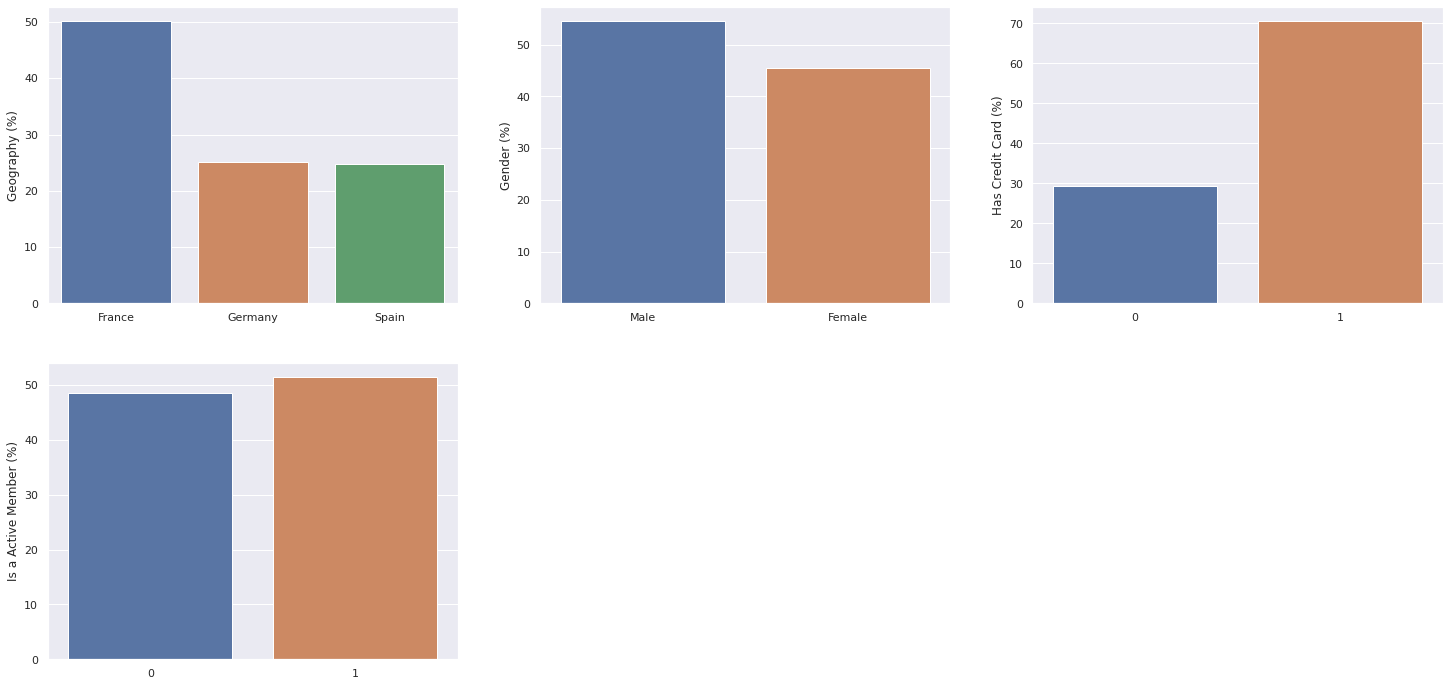

In [27]:
subplot(2, 3, 1)
sns.barplot(x = geo_percentage.index, y = geo_percentage)
plt.ylabel('Geography (%)');

subplot(2, 3, 2)
sns.barplot(x = gender_percentage.index, y = gender_percentage)
plt.ylabel('Gender (%)');

subplot(2, 3, 3)
sns.barplot(x = cred_card_percentage.index, y = cred_card_percentage)
plt.ylabel('Has Credit Card (%)');

subplot(2, 3, 4)
sns.barplot(x = active_member_percentage.index, y = active_member_percentage)
plt.ylabel('Is a Active Member (%)')

# subplot(2, 3, 5)
# sns.barplot(data = df0, x = exited_percentage.index, y = exited_percentage)
# plt.ylabel('%')
# plt.title('Churn Percentage');

### Zero values distribution

 Sometimes the data isn't missing (NaNs), but it can be in a form of an oddly high number of zero values 
 
 **Conclusion**: The 'Balance' columns have a great number of zeros, but it doesn't mean they are missing values (NaNs). Nevertheless, the Data Science team should get in contact with the business team to check if this number is correct

In [28]:
# create DataFrame with zero and non zero values
num_zero = num_att.copy()
num_col = num_zero.columns

for col in num_col :
    num_zero[col] = num_zero[col].apply(lambda x: 'zero' if x==0 else 'not zero')

In [29]:
# check which columns have zero values 
num_zero.apply( lambda x: x.unique().shape[0])

row_number          1
customer_id         1
credit_score        1
age                 1
tenure              2
balance             2
num_of_products     1
has_cr_card         2
is_active_member    2
estimated_salary    1
exited              2
dtype: int64

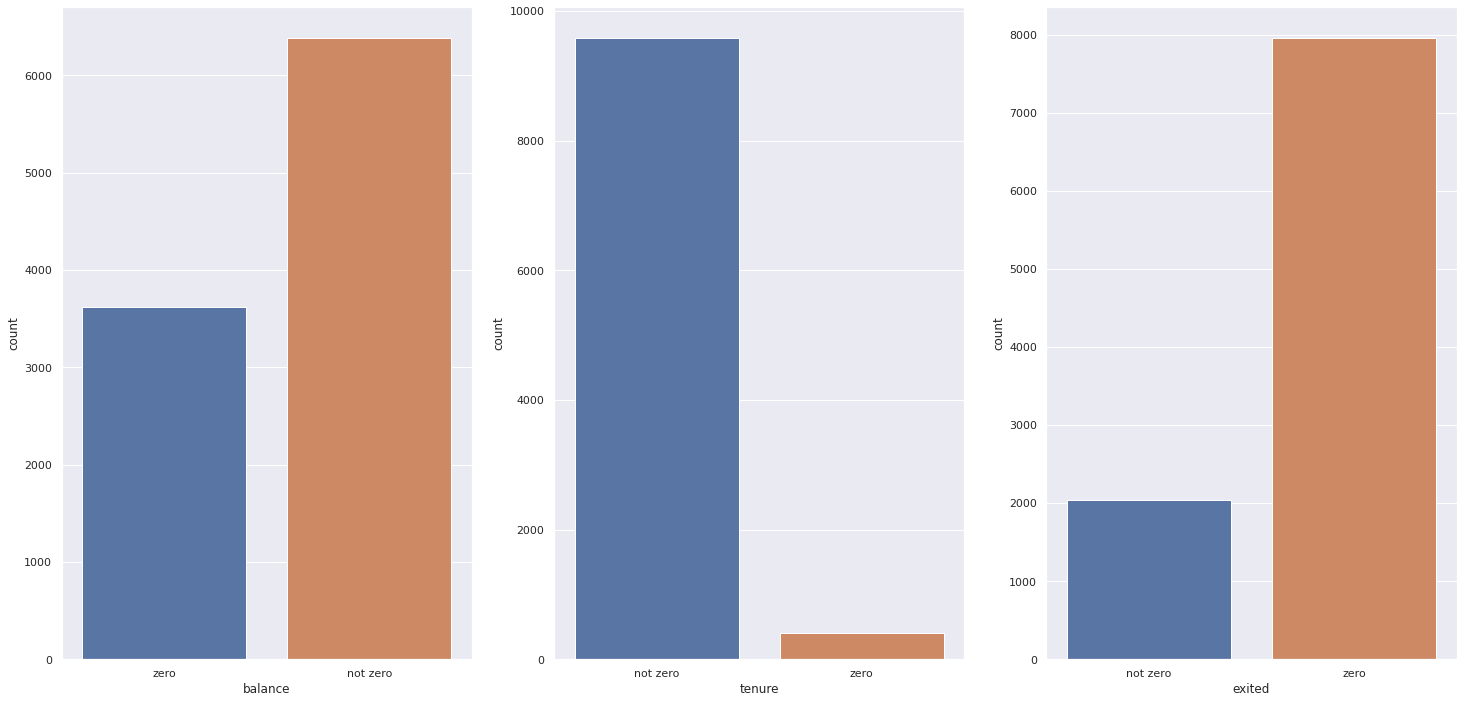

In [30]:
#Plot zero values proportion 
plt.subplot(1,3,1)
sns.countplot(x = 'balance', data = num_zero) 

plt.subplot(1,3,2)
sns.countplot(x = 'tenure', data = num_zero) 

plt.subplot(1,3,3)
sns.countplot(x = 'exited', data = num_zero);

# FEATURE ENGINEERING

In [31]:
# dataset copy
df1 = df0.copy()

## Hypothesis Mindmap

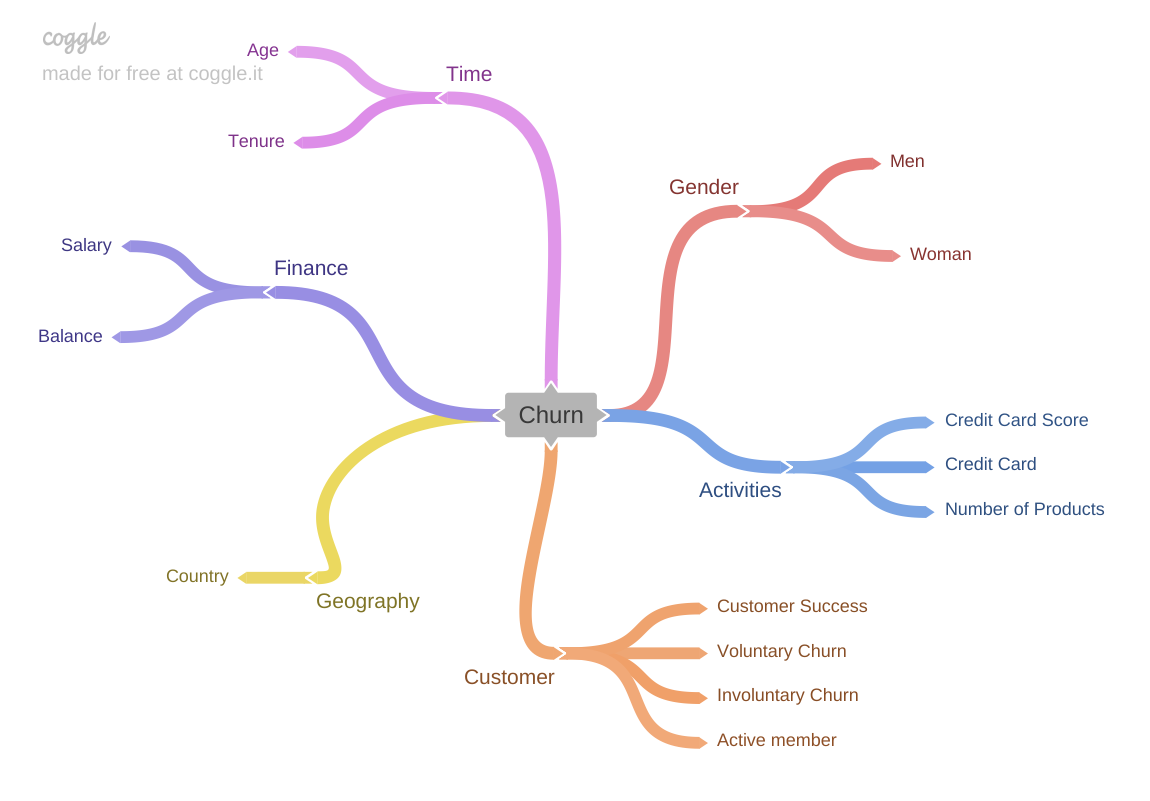

In [32]:
Image('/home/marxcerqueira/repos/Data-Science-Projects/Kaggle-Client-Churn-Prediction/reports/figures/Churn.png')

    . The goal of the hypothesis mind-map is to answer questions that are not clear in the dataset. To sum up it's a road map of which analysis do I have to do to validate hypothesis of the business and to which features do I have to create for a better understanding of the data during the Exploratory Data Analysis

Motivação da feature engineering:
    - ter variáveis disponíveis para estudo durante a Análise Exploratória de Dados e o mapa mental ajuda nessa atividade.
    - Um roteiro para mostrar quais análises preciso fazer para validar as hipóteses e quais variáveis precisarei ter para validar as hipóteses
    

In [33]:
df1.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Creating Hypothesis

### Finance Hypothesis

- H1. Customers with higher salaries tend to be in churn

- H2. Customers with lower balances tend to be in churn

### Geography Hypothesis

- H3. Customers who live in France tend to be in churn

### Customer Hypothesis

- H4. Active members should not be in churn
- H5. Involuntary churn rate is grater than voluntary churn rate

### Activities Hypothesis

- H6. Customers with credit card have more probability to churn
- H7. Customers with high credit scores have less probability to churn (*generally credit scores from 580 to 669 are considered fair; 670 to 739 are considered good; 740 to 799 are considered very good; and 800 and up are considered excellent.*)
- H8. Customers with less products tend to churn more

### Gender Hypothesis

- H9. Womans tend to churn more often than mens

### Time Hypothesis


- H10. Younger costumers tend to churn more often
- H11. Customer with higher tenure tend to have a lower churn rate

## Final Hypothesis List

- H1. Customers with higher salaries tend to be in churn

- H2. Customers with lower balances tend to be in churn

- H3. Customers who live in France tend to be in churn
- H4. Active members should not be in churn
- H5. Involuntary churn rate is grater than voluntary churn rate
- H6. Customers with credit card have more probability to churn
- H7. Customers with high credit scores have less probability to churn (*generally credit scores from 580 to 669 are considered fair; 670 to 739 are considered good; 740 to 799 are considered very good; and 800 and up are considered excellent.*)
- H8. Customers with less products tend to churn more
- H9. Womans tend to churn more often than mens
- H10. Younger costumers tend to churn more often
- H11. Customer with higher tenure tend to have a lower churn rate

## Feature Engineering

**Feature Description**:

- **RowNumber**: The number of the columns.
- **CustomerID**: Unique client identifier.
- **Surname**: Client's surname.
- **CreditScore**: Client's credit card score for the financial market A pontuação de Crédito do cliente para o mercado de consumo.
- **Geography**: The country where the client lives.
- **Gender**: Client's gender.
- **Age**: Client's age.
- **Tenure**: The number of years the client remained activate in the bank.
- **Balance**: The monetary amount the client has in their current account.
- **NumOfProducts**: The number of products purchased by the client.
- **HasCrCard**: Point if the client has a credit card.
- **IsActiveMember**: Tell if the client is an active member of the bank (within the last 12 months).
- **EstimateSalary**: Client's annual salary estimate.
- **Exited**: Indicates if the client is a churn (tagert variable).

In [34]:
df1.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [35]:
# create features

df1['tenure_year'] = df1['tenure'] + 1

df1['age_by_tenure'] = df1['age'] / df1['tenure_year']

df1['salary_by_credit'] = df1['estimated_salary'] / df1['credit_score']

df1['salary_by_age'] = df1['estimated_salary'] / df1['age']

df1['salary_by_tenure'] = df1['estimated_salary'] / df1['tenure_year']

df1['balance_by_age'] = df1['balance'] / df1['age']

df1['balance_by_prod'] = df1['balance'] / df1['num_of_products']

df1['all_money'] = df1['estimated_salary'] + df1['balance']

df1['money_by_credit'] = df1['all_money'] / df1['credit_score']

In [36]:
# # reorder columns

# df1 = df1[['row_number',
#  'customer_id',
#  'surname',
#  'credit_score',
#  'geography',
#  'gender',
#  'age',
#  'tenure',
#  'balance',
#  'num_of_products',
#  'has_cr_card',
#  'is_active_member',
#  'estimated_salary',
#  'age_by_tenure',
#  'salary_by_age',
#  'balance_by_age',
#  'balance_by_prod',
#  'salary_by_credit',
#  'all_money',
#  'money_by_credit','exited']]

In [37]:
list(df1)

['row_number',
 'customer_id',
 'surname',
 'credit_score',
 'geography',
 'gender',
 'age',
 'tenure',
 'balance',
 'num_of_products',
 'has_cr_card',
 'is_active_member',
 'estimated_salary',
 'exited',
 'tenure_year',
 'age_by_tenure',
 'salary_by_credit',
 'salary_by_age',
 'salary_by_tenure',
 'balance_by_age',
 'balance_by_prod',
 'all_money',
 'money_by_credit']

# VARIABLE FILTERING

In [38]:
df2 = df1.copy()

In [39]:
df2.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,tenure_year,age_by_tenure,salary_by_credit,salary_by_age,salary_by_tenure,balance_by_age,balance_by_prod,all_money,money_by_credit
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,3,14.000000,163.730016,2413.068571,33782.960000,0.000000,0.000000,101348.88,163.730016
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,2,20.500000,185.102928,2744.940976,56271.290000,2044.094146,83807.860000,196350.44,322.944803
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,9,4.666667,226.955319,2712.656429,12659.063333,3801.447619,53220.266667,273592.37,545.004721
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,2,19.500000,134.229800,2405.811026,46913.315000,0.000000,0.000000,93826.63,134.229800
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,3,14.333333,93.040118,1839.165116,26361.366667,2918.856279,125510.820000,204594.92,240.699906


## Line Filtering

## Columns Selection

In [40]:
# feature row_number is not necessary
df2 = df2.drop('row_number', axis = 1)

In [41]:
df2.head()

,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,tenure_year,age_by_tenure,salary_by_credit,salary_by_age,salary_by_tenure,balance_by_age,balance_by_prod,all_money,money_by_credit
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,3,14.000000,163.730016,2413.068571,33782.960000,0.000000,0.000000,101348.88,163.730016
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,2,20.500000,185.102928,2744.940976,56271.290000,2044.094146,83807.860000,196350.44,322.944803
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,9,4.666667,226.955319,2712.656429,12659.063333,3801.447619,53220.266667,273592.37,545.004721
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,2,19.500000,134.229800,2405.811026,46913.315000,0.000000,0.000000,93826.63,134.229800
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,3,14.333333,93.040118,1839.165116,26361.366667,2918.856279,125510.820000,204594.92,240.699906


# EXPLORATORY DATA ANALYSIS (EDA)

In [42]:
df3 = df2.copy()

## Univariate Analysis

### Response Variable

In [43]:
exited_percentage = df3['exited'].value_counts(normalize = True)*100
exited_percentage

0    79.63
1    20.37
Name: exited, dtype: float64

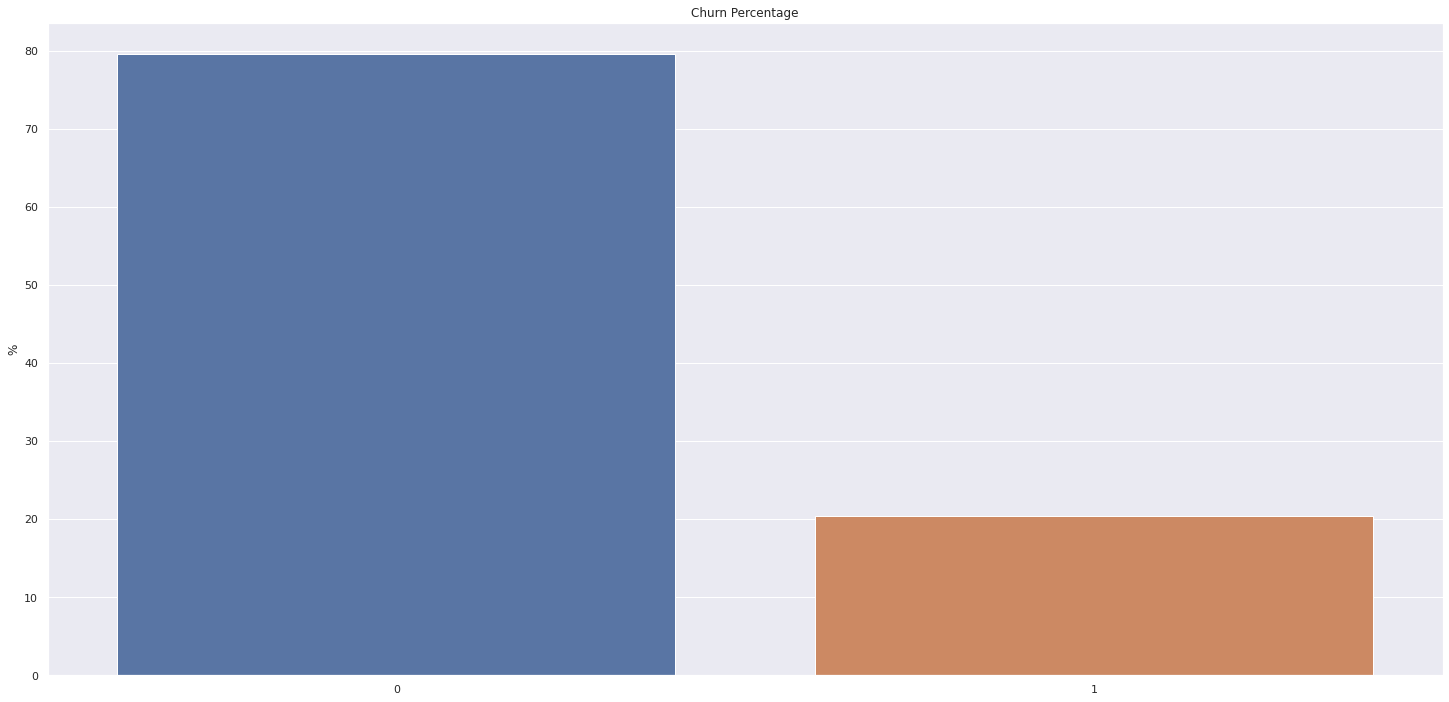

In [44]:
sns.barplot(data = df3, x = exited_percentage.index, y = exited_percentage)
plt.ylabel('%')
plt.title('Churn Percentage');

- 20% of the clients in this dataset are in churn

### Numerical Variable

In [45]:
# separate numerical and categorical attributes
num_att = df3.select_dtypes(include = 'number')

In [46]:
list(num_att)

['customer_id',
 'credit_score',
 'age',
 'tenure',
 'balance',
 'num_of_products',
 'has_cr_card',
 'is_active_member',
 'estimated_salary',
 'exited',
 'tenure_year',
 'age_by_tenure',
 'salary_by_credit',
 'salary_by_age',
 'salary_by_tenure',
 'balance_by_age',
 'balance_by_prod',
 'all_money',
 'money_by_credit']

/home/marxcerqueira/.pyenv/versions/3.9.1/envs/Client-Churn-Prediction/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


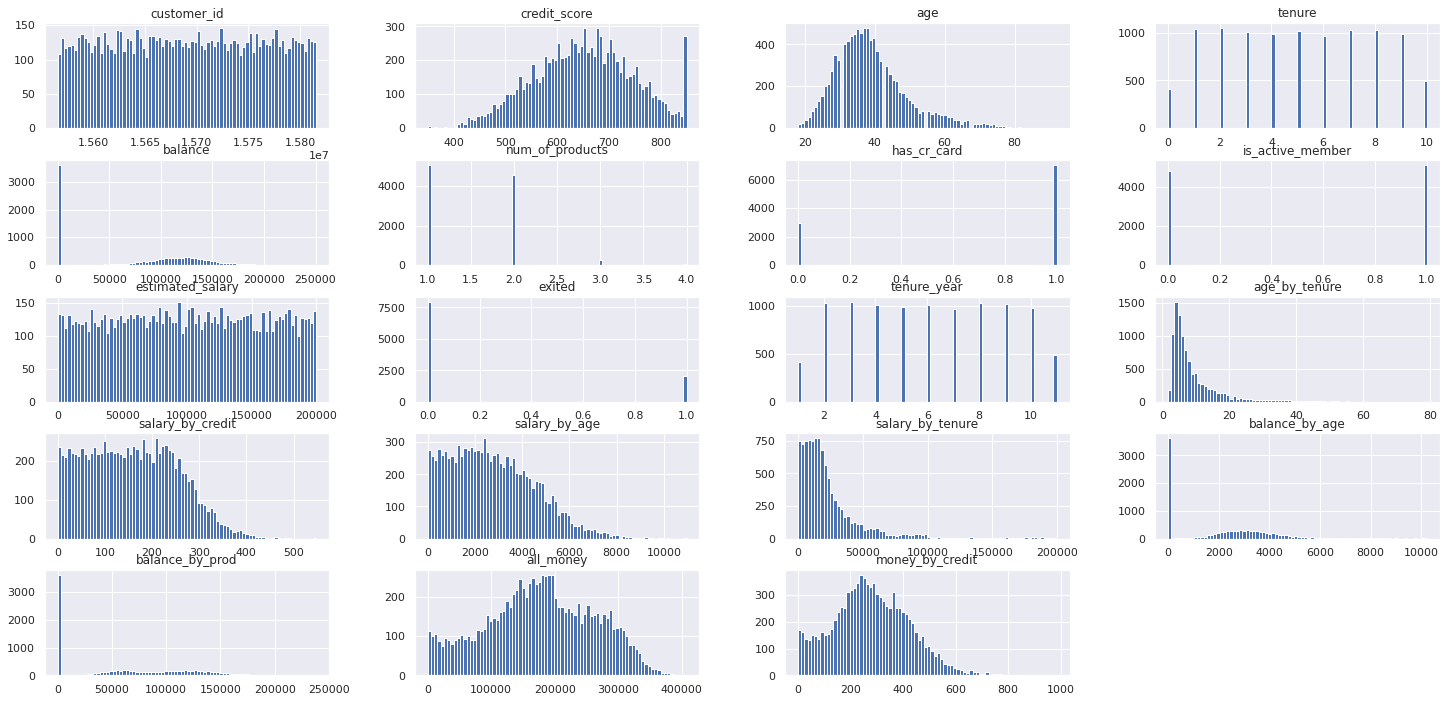

In [47]:
num_att.hist(bins = 80);

#### Credit Score

In [48]:
# credit score
# credit scores from 580 to 669 are considered fair; 670 to 739 are considered good;
# 740 to 799 are considered very good; and 800 and up are considered excellent.
aux_cred = df3[['credit_score', 'exited']].copy()
aux_cred['credit_score_cat'] = df3['credit_score'].apply(lambda x: 'bad' if x < 580 else
                                                              'fair' if (x >= 580 ) & (x < 669) else
                                                              'good' if (x >= 699) & (x < 739) else
                                                              'very good' if (x >= 739) & (x < 799)
                                                               else 'excellent')

aux_cred = aux_cred[['credit_score', 'credit_score_cat', 'exited']]

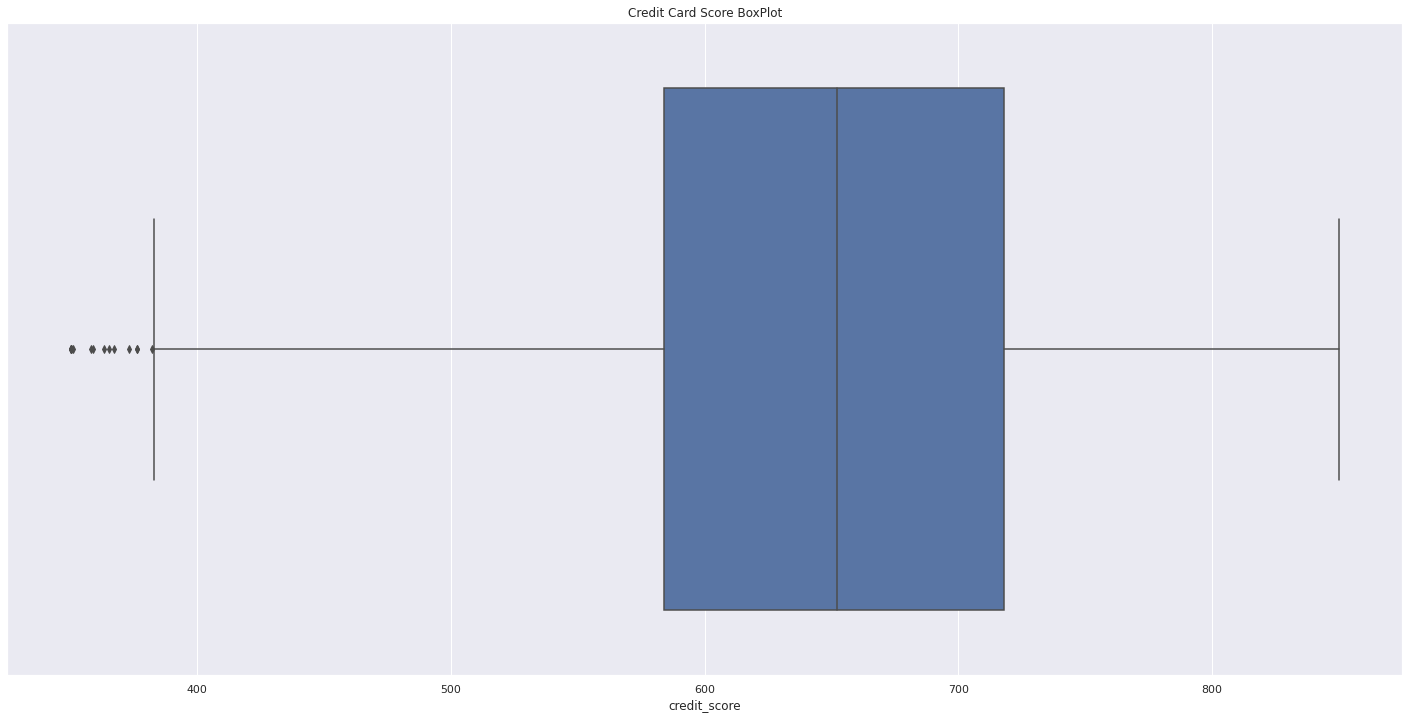

In [49]:
# credit score
sns.boxplot( x = 'credit_score', data = df3)
plt.title('Credit Card Score BoxPlot');

In [50]:
aux_cred.head()

,credit_score,credit_score_cat,exited
0,619,fair,1
1,608,fair,0
2,502,bad,1
3,699,good,0
4,850,excellent,0


In [51]:
aux_cred[aux_cred['credit_score'] < 400]

,credit_score,credit_score_cat,exited
7,376,bad,1
942,376,bad,1
1193,363,bad,1
1201,399,bad,1
1405,359,bad,1
1631,350,bad,1
1838,350,bad,1
1962,358,bad,1
2473,351,bad,1
2579,365,bad,1


In [52]:
aux_cred[aux_cred['credit_score'] < 400].count()

credit_score        19
credit_score_cat    19
exited              19
dtype: int64

- Credit card attribute has some outliers below 400 (a very bad credit card score)
- All these costumers have exited 

#### Age

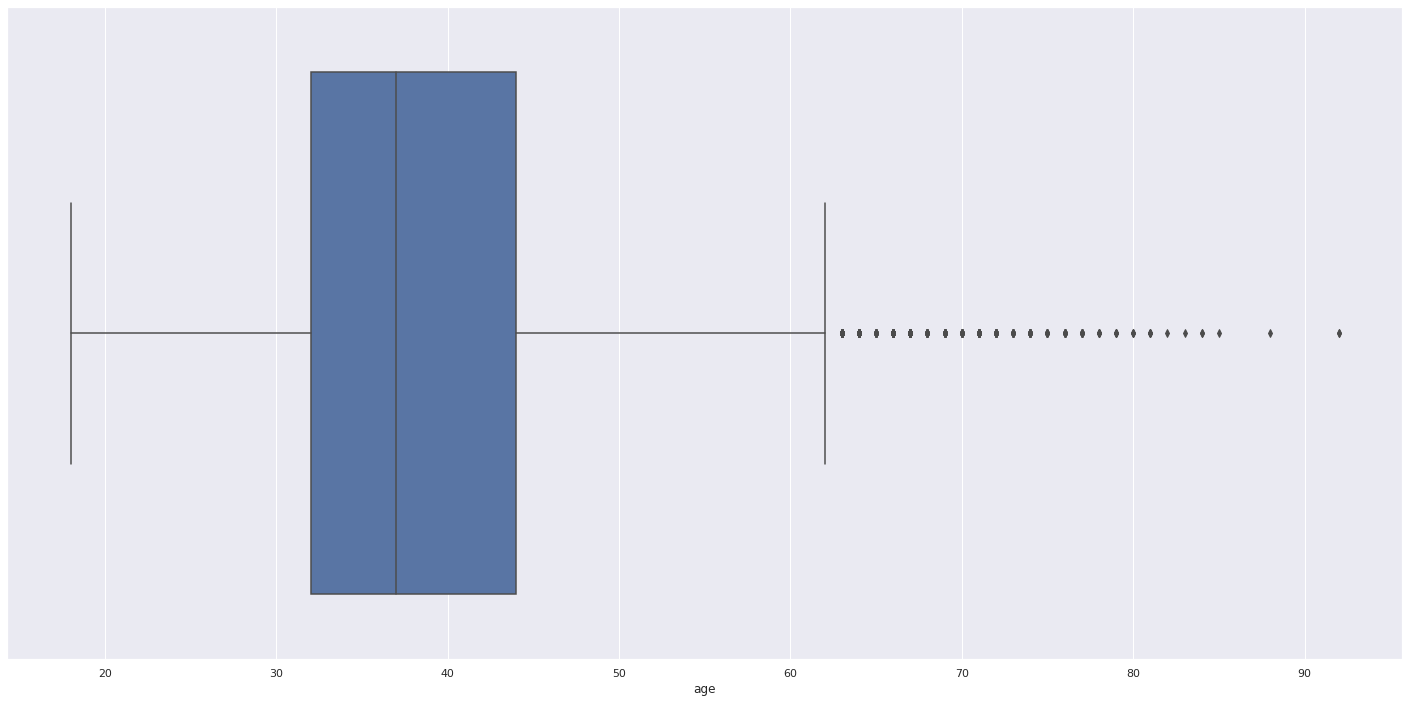

In [53]:
sns.boxplot( x = 'age', data = df3);

### Categorical Variable

In [54]:
cat_att = df3.select_dtypes(include = 'object')
cat_att.head()

,surname,geography,gender
0,Hargrave,France,Female
1,Hill,Spain,Female
2,Onio,France,Female
3,Boni,France,Female
4,Mitchell,Spain,Female


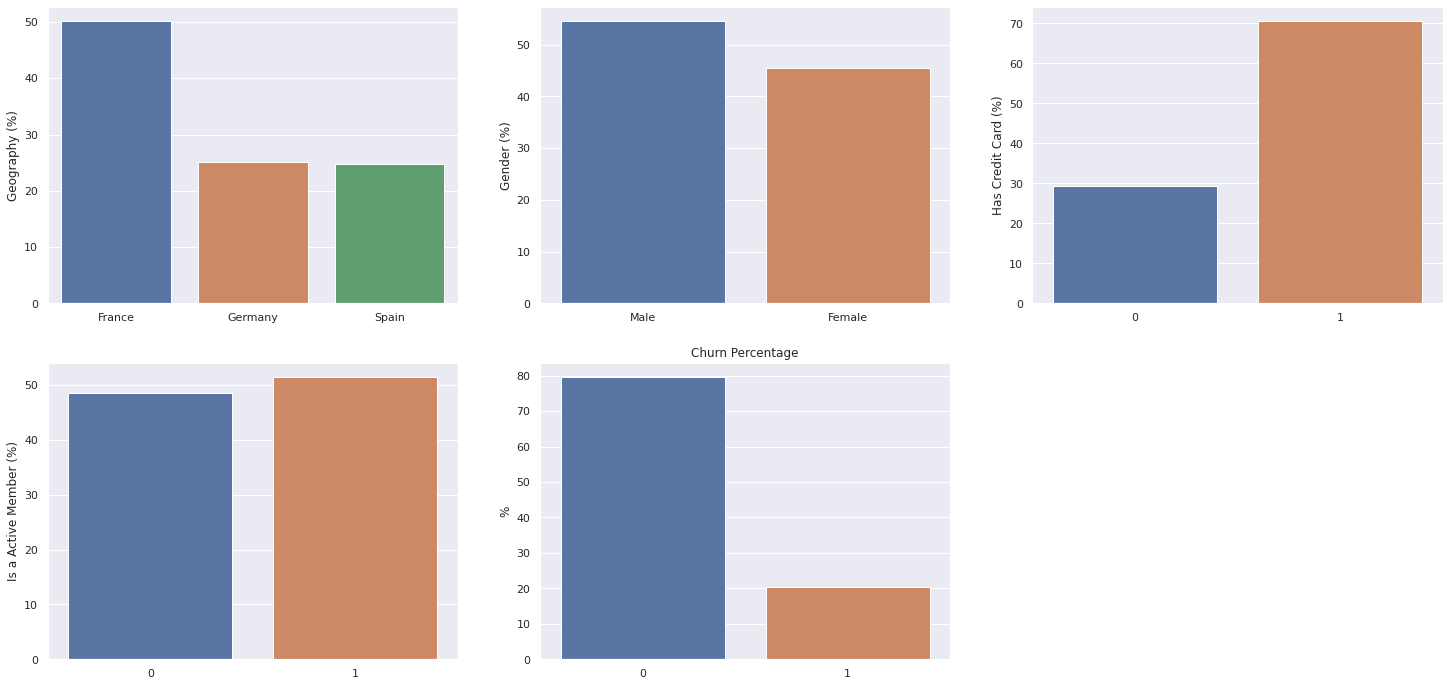

In [55]:
subplot(2, 3, 1)
sns.barplot(x = geo_percentage.index, y = geo_percentage)
plt.ylabel('Geography (%)');

subplot(2, 3, 2)
sns.barplot(x = gender_percentage.index, y = gender_percentage)
plt.ylabel('Gender (%)');

subplot(2, 3, 3)
sns.barplot(x = cred_card_percentage.index, y = cred_card_percentage)
plt.ylabel('Has Credit Card (%)');

subplot(2, 3, 4)
sns.barplot(x = active_member_percentage.index, y = active_member_percentage)
plt.ylabel('Is a Active Member (%)')

subplot(2, 3, 5)
sns.barplot(data = df3, x = exited_percentage.index, y = exited_percentage)
plt.ylabel('%')
plt.title('Churn Percentage');

## Bivariate Analysis

In [56]:
df3.head()

,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,tenure_year,age_by_tenure,salary_by_credit,salary_by_age,salary_by_tenure,balance_by_age,balance_by_prod,all_money,money_by_credit
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,3,14.000000,163.730016,2413.068571,33782.960000,0.000000,0.000000,101348.88,163.730016
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,2,20.500000,185.102928,2744.940976,56271.290000,2044.094146,83807.860000,196350.44,322.944803
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,9,4.666667,226.955319,2712.656429,12659.063333,3801.447619,53220.266667,273592.37,545.004721
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,2,19.500000,134.229800,2405.811026,46913.315000,0.000000,0.000000,93826.63,134.229800
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,3,14.333333,93.040118,1839.165116,26361.366667,2918.856279,125510.820000,204594.92,240.699906


### H1. Customers with higher salaries tend to be in churn
**TRUE** Customers with hight salaries churn more often

/home/marxcerqueira/.pyenv/versions/3.9.1/envs/Client-Churn-Prediction/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/marxcerqueira/.pyenv/versions/3.9.1/envs/Client-Churn-Prediction/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


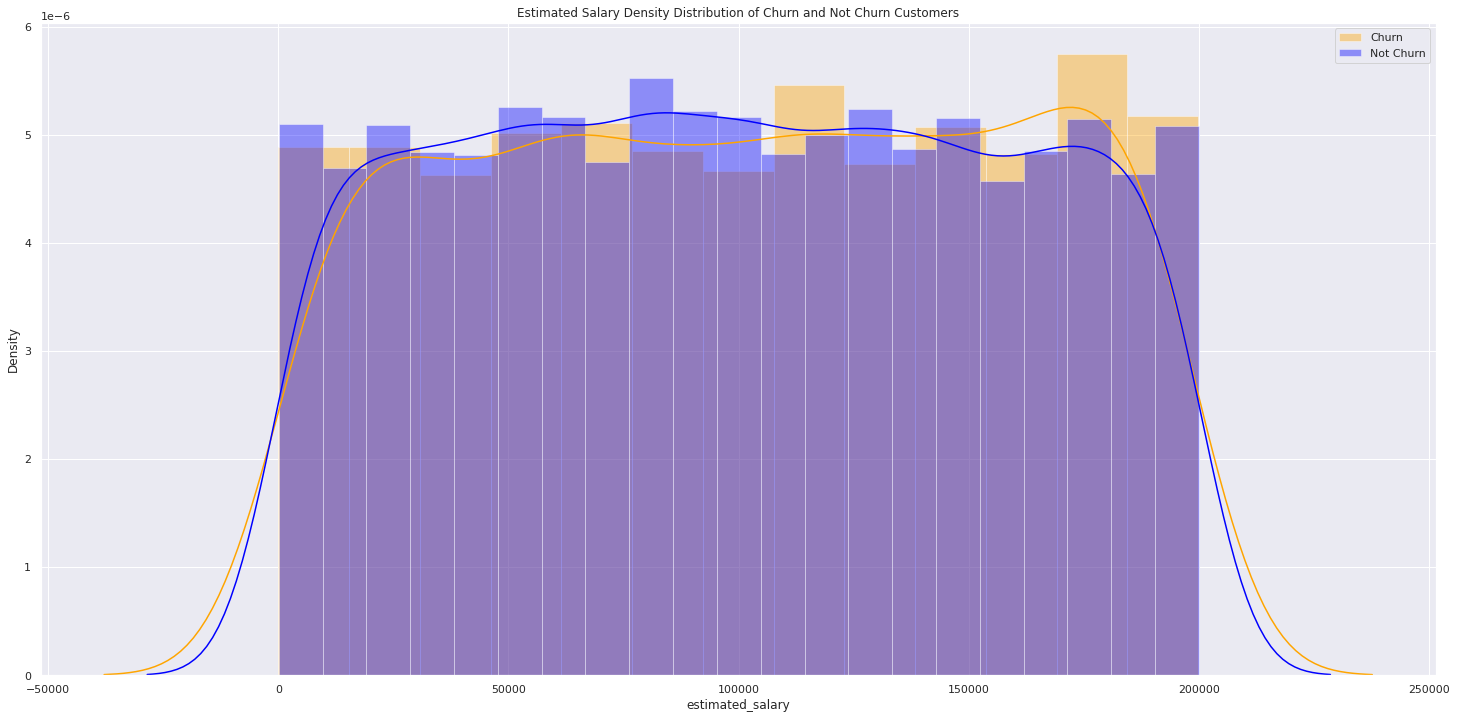

In [57]:
# auxiliary dataframe for exited = 0 and = 1
aux_exited0 = df3[df3['exited'] == 0]
aux_exited1 = df3[df3['exited'] == 1]

# plot estimated salary density distribution for exited = 0 and 1
sns.distplot(aux_exited1['estimated_salary'], color = 'orange', kde = True, label = 'Churn')
sns.distplot(aux_exited0['estimated_salary'], color = 'blue', kde = True, label = 'Not Churn')
plt.title('Estimated Salary Density Distribution of Churn and Not Churn Customers');
plt.legend();

In [58]:
a = df0.groupby('exited')['estimated_salary'].sum().reset_index()
a

,exited,estimated_salary
0,0,7.942168e+08
1,1,2.066856e+08


In [59]:
# Estimated Salary Describe - Not Churn and Churn
a = df3.groupby('exited')['estimated_salary'].agg(['count', 'mean', 'median', 'std', 'min', 'max'])
a = a.T
a.columns = ['Not Churn', 'Churn']
a

,Not Churn,Churn
count,7963.000000,2037.000000
mean,99738.391772,101465.677531
median,99645.040000,102460.840000
std,57405.586966,57912.418071
min,90.070000,11.580000
max,199992.480000,199808.100000


<ipython-input-60-da110929af01>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_exited0['salary_category'] = pd.cut(aux_exited0['estimated_salary'], bins = bins)
<ipython-input-60-da110929af01>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_exited1['salary_category'] = pd.cut(aux_exited1['estimated_salary'], bins = bins)


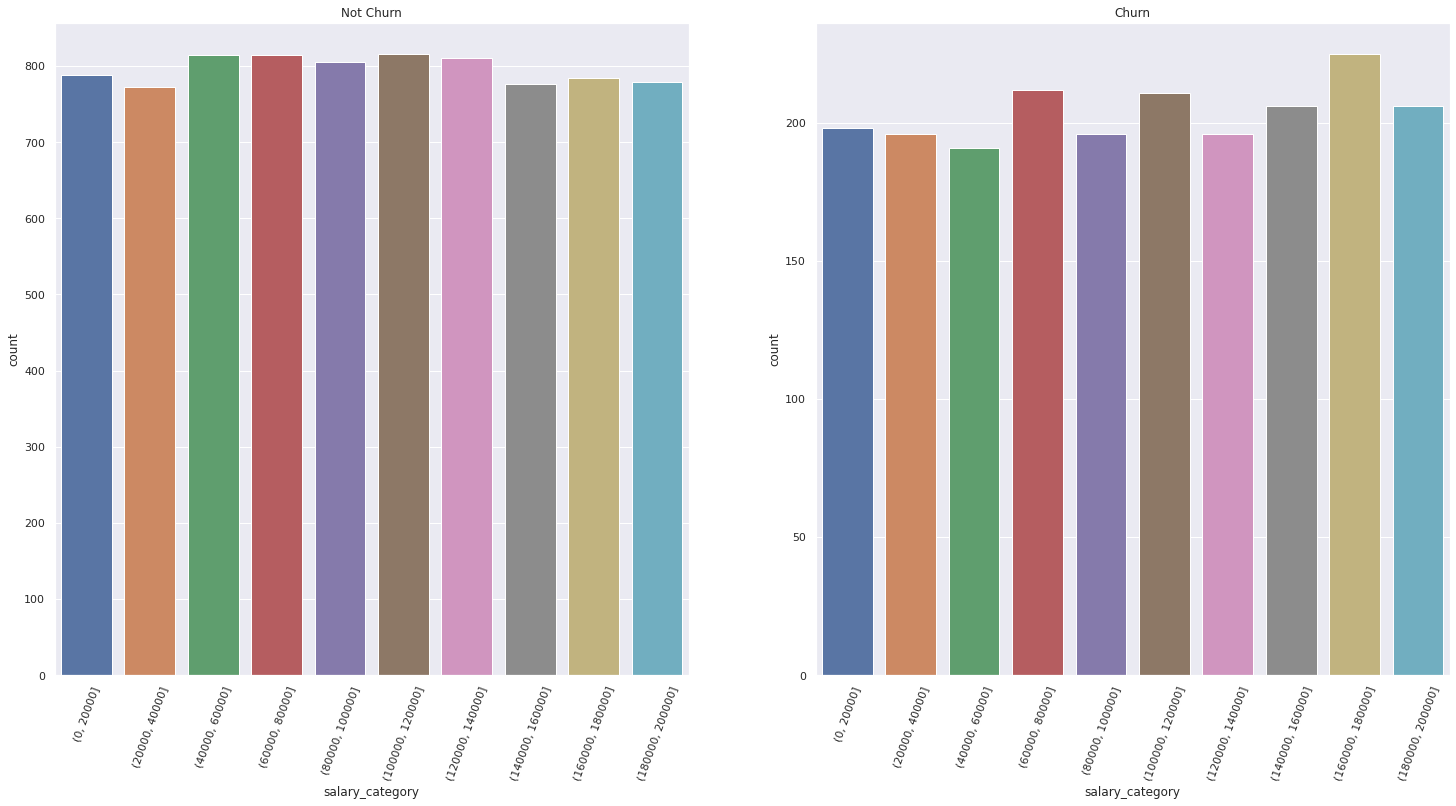

In [60]:
# Create Estimate Salary Categories
bins = list(np.arange(0,210000, 20000))
aux_exited0['salary_category'] = pd.cut(aux_exited0['estimated_salary'], bins = bins)
aux_exited1['salary_category'] = pd.cut(aux_exited1['estimated_salary'], bins = bins)

subplot(1, 2, 1)
sns.countplot(x = 'salary_category', data = aux_exited0).set_title('Not Churn')
plt.xticks(rotation = 70)

subplot(1, 2, 2)
sns.countplot(x = 'salary_category', data = aux_exited1).set_title('Churn')
plt.xticks(rotation = 70);

In [61]:
# Create Relative Salaray Percentage Count plot, since the salary count of 
#churn and not churn clients are too different

bins = list(np.arange(0,210000, 20000))

# create new dataframe
aux1 = df3[['estimated_salary', 'exited']]
aux1['salary_category'] = pd.cut(aux1['estimated_salary'], bins = bins)

# new dataframe with salary_category, exited, and number of clients 
aux10 = aux1[['salary_category', 'estimated_salary', 'exited']].groupby(['salary_category', 'exited']).count().reset_index()

# rename dataframe columns
aux10.columns = ['salary_category', 'exited', 'number_of_clients']

# sum of clients in churn
clients_churn = aux10[aux10['exited'] == 1]['number_of_clients'].sum()

# sum of clients not in churn
clients_not_churn = aux10[aux10['exited'] == 0]['number_of_clients'].sum()

total_clients = aux10['number_of_clients'].sum()

# calculate the relative percentage ratio of clients not or in churn
aux10['relative_percentage'] = aux10.apply(lambda x: (x['number_of_clients']/clients_churn)*100 if x['exited'] == 1 else (x['number_of_clients']/clients_not_churn)*100, axis = 1 )

aux10.head(30)

<ipython-input-61-84a28a771cdf>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux1['salary_category'] = pd.cut(aux1['estimated_salary'], bins = bins)


,salary_category,exited,number_of_clients,relative_percentage
0,"(0, 20000]",0,788,9.895768
1,"(0, 20000]",1,198,9.720177
2,"(20000, 40000]",0,773,9.707397
3,"(20000, 40000]",1,196,9.621993
4,"(40000, 60000]",0,815,10.234836
5,"(40000, 60000]",1,191,9.376534
6,"(60000, 80000]",0,815,10.234836
7,"(60000, 80000]",1,212,10.407462
8,"(80000, 100000]",0,806,10.121813
9,"(80000, 100000]",1,196,9.621993


In [62]:
clients_churn

2037

In [63]:
total_clients = aux10['number_of_clients'].sum()
total_clients

10000

In [64]:
clients_not_churn

7963

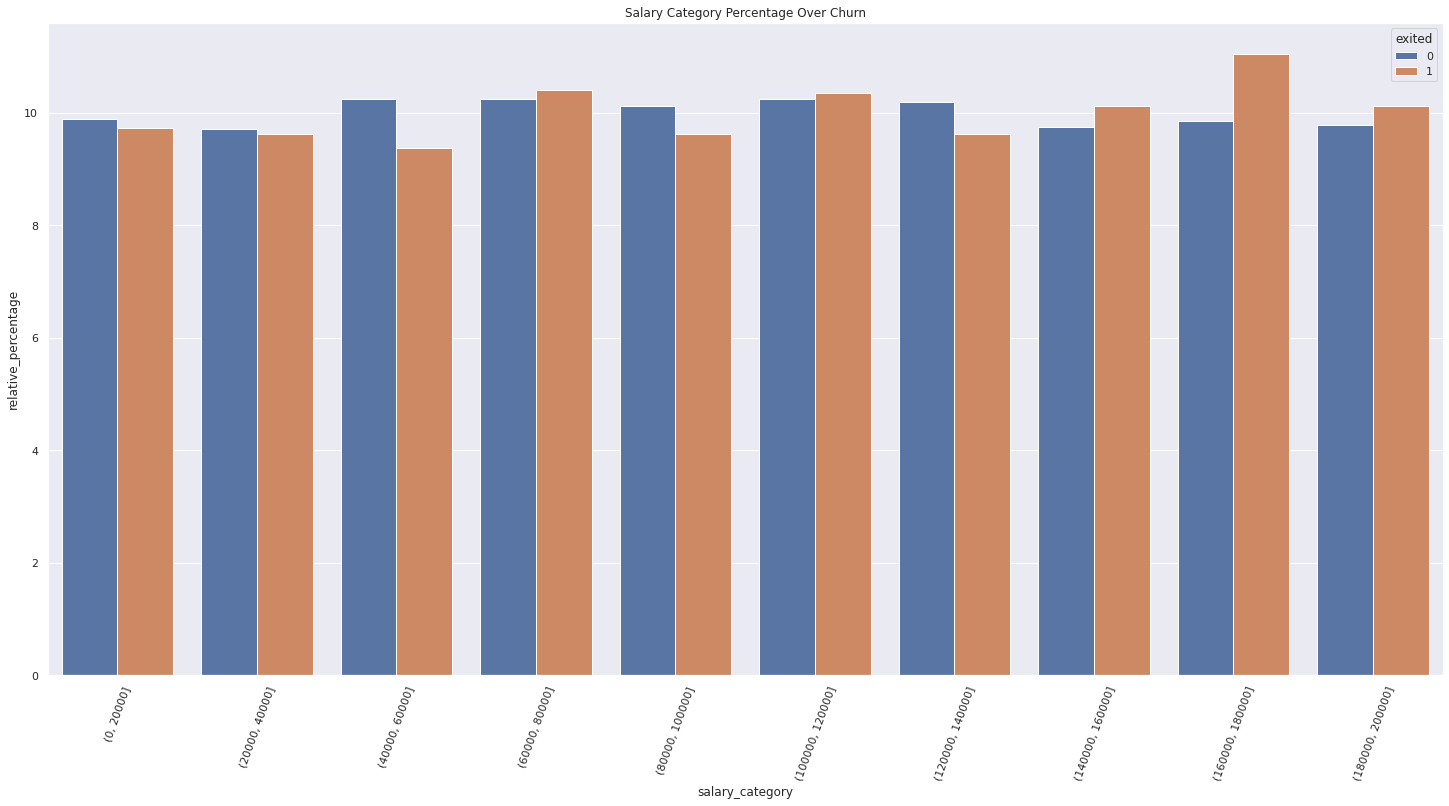

In [65]:
sns.barplot(x = 'salary_category', y = 'relative_percentage' ,data = aux10, hue = 'exited').set_title('Salary Category Percentage Over Churn')
plt.xticks(rotation = 70);

In [66]:
aux102 = aux10[aux10['exited'] == 1]
aux102.sort_values('relative_percentage', ascending = False)

,salary_category,exited,number_of_clients,relative_percentage
17,"(160000, 180000]",1,225,11.045655
7,"(60000, 80000]",1,212,10.407462
11,"(100000, 120000]",1,211,10.358370
15,"(140000, 160000]",1,206,10.112911
19,"(180000, 200000]",1,206,10.112911
1,"(0, 20000]",1,198,9.720177
3,"(20000, 40000]",1,196,9.621993
9,"(80000, 100000]",1,196,9.621993
13,"(120000, 140000]",1,196,9.621993
5,"(40000, 60000]",1,191,9.376534


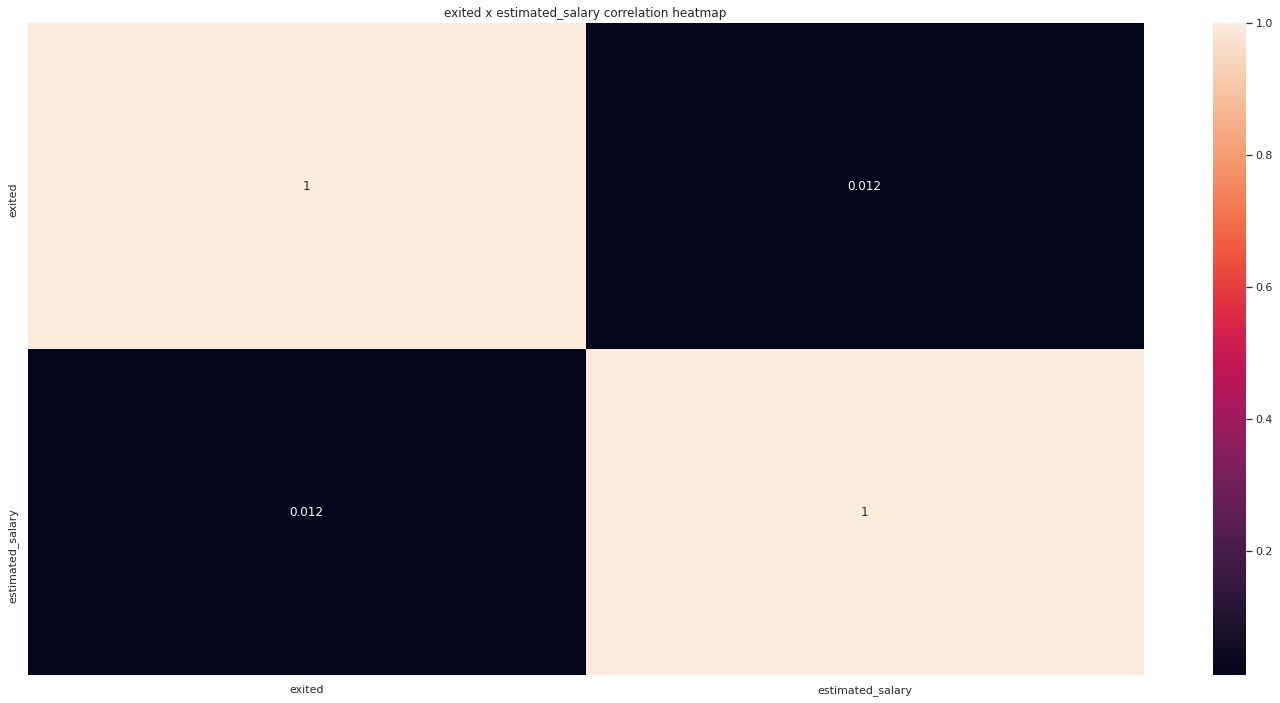

In [67]:
# point-biserial correlation coefficient heatmap.
# The point biserial correlation coefficient, rpbi, is a special case of Pearson’s correlation coefficient. It measures the relationship between two variables:
# One continuous variable (must be ratio scale or interval scale). and the other naturally binary variable.*

point_bi_corr(df3[['exited']], df3[['estimated_salary']]);

 Parafrasear!
- The estimated salary is evenly distributed for both active clients (exited = 0) and clients in churn (exited = 1), therefore it is hard to detect a variation which could indicate client in churn. The correlation heatmap confirms this with a low coefficient of 0.02.
- The salary relative percentage plot shows that clients with salary greater than 100,000, the relative percentage of churn (orange bars) is always greater than the relative percentage of active members (blue bars).
- Also, for clients in churn, the top four salary relative percentage are from range values greater than 100,000.
- The relative percentage of salaries greater than 100,000 is 52.23%.
- Therefore, the hypothesis is true: churn occur for clients with high salary.

### H2. Customers with lower balances tend to be in churn
**FALSE** Customers with higher balance churn more often

In [68]:
aux_exited0.head()

,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,tenure_year,age_by_tenure,salary_by_credit,salary_by_age,salary_by_tenure,balance_by_age,balance_by_prod,all_money,money_by_credit,salary_category
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,2,20.500000,185.102928,2744.940976,56271.290000,2044.094146,83807.860,196350.44,322.944803,"(100000, 120000]"
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,2,19.500000,134.229800,2405.811026,46913.315000,0.000000,0.000,93826.63,134.229800,"(80000, 100000]"
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,3,14.333333,93.040118,1839.165116,26361.366667,2918.856279,125510.820,204594.92,240.699906,"(60000, 80000]"
6,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0,8,6.250000,12.241849,201.256000,1257.850000,0.000000,0.000,10062.80,12.241849,"(0, 20000]"
8,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0,5,8.800000,149.581836,1703.193182,14988.100000,3228.433409,71025.535,216991.57,433.116906,"(60000, 80000]"


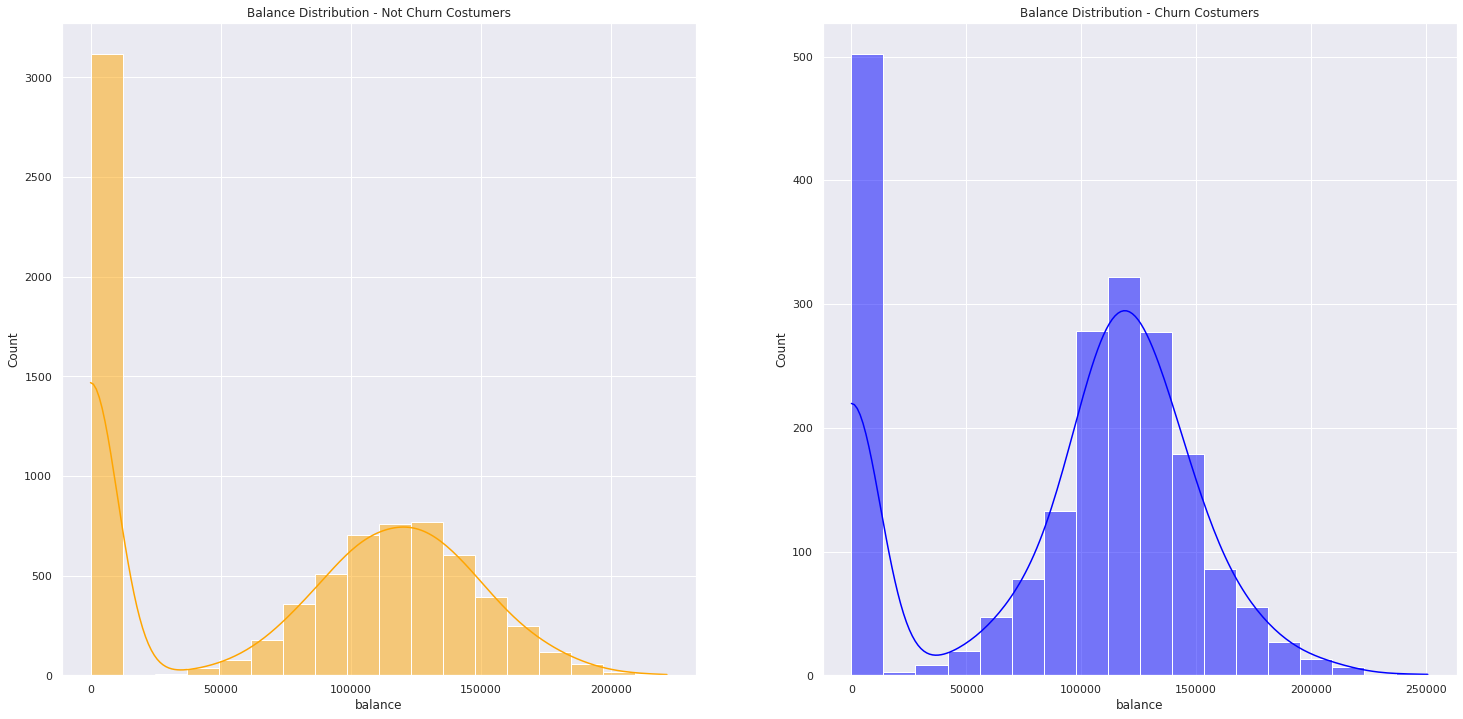

In [69]:
# auxiliary dataframe for exited = 0 and = 1
aux_exited0 = df3[df3['exited'] == 0]
aux_exited1 = df3[df3['exited'] == 1]

# plot balance distribution of clients 
subplot(1, 2, 1)
sns.histplot(data = aux_exited0, x = 'balance', kde = True, color = 'orange' ).set_title('Balance Distribution - Not Churn Costumers');

subplot(1, 2, 2)
sns.histplot(data = aux_exited1, x = 'balance', kde = True, color = 'blue').set_title('Balance Distribution - Churn Costumers');



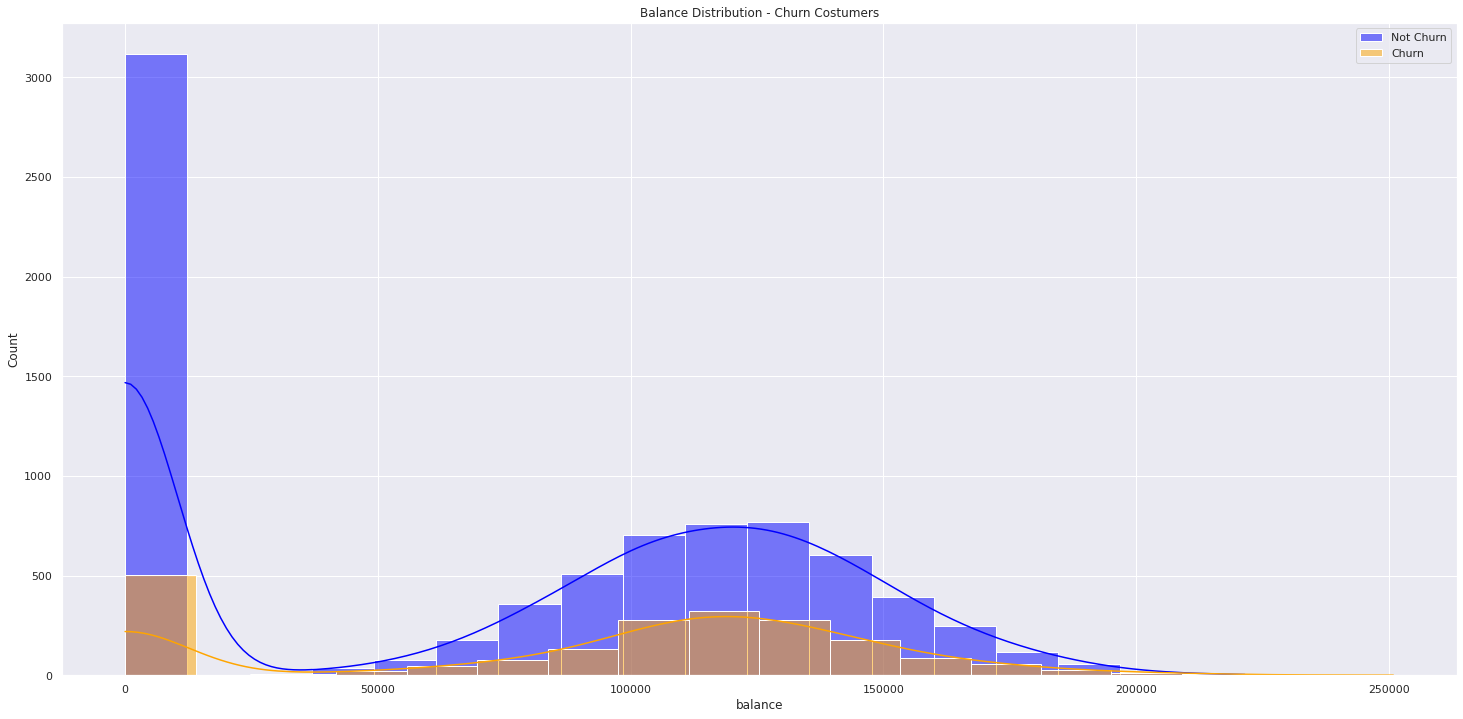

In [70]:
# plot balance distribution of clients 
sns.histplot(data = aux_exited0, x = 'balance', kde = True, color = 'blue', label = 'Not Churn').set_title('Balance Distribution - Not Churn Costumers');
sns.histplot(data = aux_exited1, x = 'balance', kde = True, color = 'orange', label = 'Churn' ).set_title('Balance Distribution - Churn Costumers');
plt.legend();


In [71]:
# balance category over churn

aux2 = df3[['balance', 'exited']]

# create balance categories
bins = list(np.arange(-1, 220000, 20000))
aux2['balance_cat'] = pd.cut(aux2['balance'], bins = bins)

# create new dataframe with columns ['number_of_clients', balance_cat, exited]
aux20 = aux2[['balance_cat', 'balance', 'exited']].groupby(['balance_cat', 'exited']).count().reset_index()

aux20.columns = ['balance_cat', 'exited', 'number_of_clients']

clients_churn = aux20.loc[aux20['exited'] == 1]['number_of_clients'].sum()
clients_not_churn = aux20.loc[aux20['exited'] == 0 ]['number_of_clients'].sum()

# evaluate relative percentage
aux20['relative_percentage'] = aux20.apply(lambda x: x['number_of_clients']/clients_churn*100 if x['exited'] == 1 else (x['number_of_clients']/clients_not_churn)*100, axis = 1)

aux20.head(10)


<ipython-input-71-a59cfafc1960>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux2['balance_cat'] = pd.cut(aux2['balance'], bins = bins)


,balance_cat,exited,number_of_clients,relative_percentage
0,"(-1, 19999]",0,3119,39.173574
1,"(-1, 19999]",1,502,24.680433
2,"(19999, 39999]",0,16,0.200955
3,"(19999, 39999]",1,9,0.442478
4,"(39999, 59999]",0,93,1.168048
5,"(39999, 59999]",1,33,1.622419
6,"(59999, 79999]",0,345,4.333082
7,"(59999, 79999]",1,85,4.178958
8,"(79999, 99999]",0,802,10.072846
9,"(79999, 99999]",1,197,9.685349


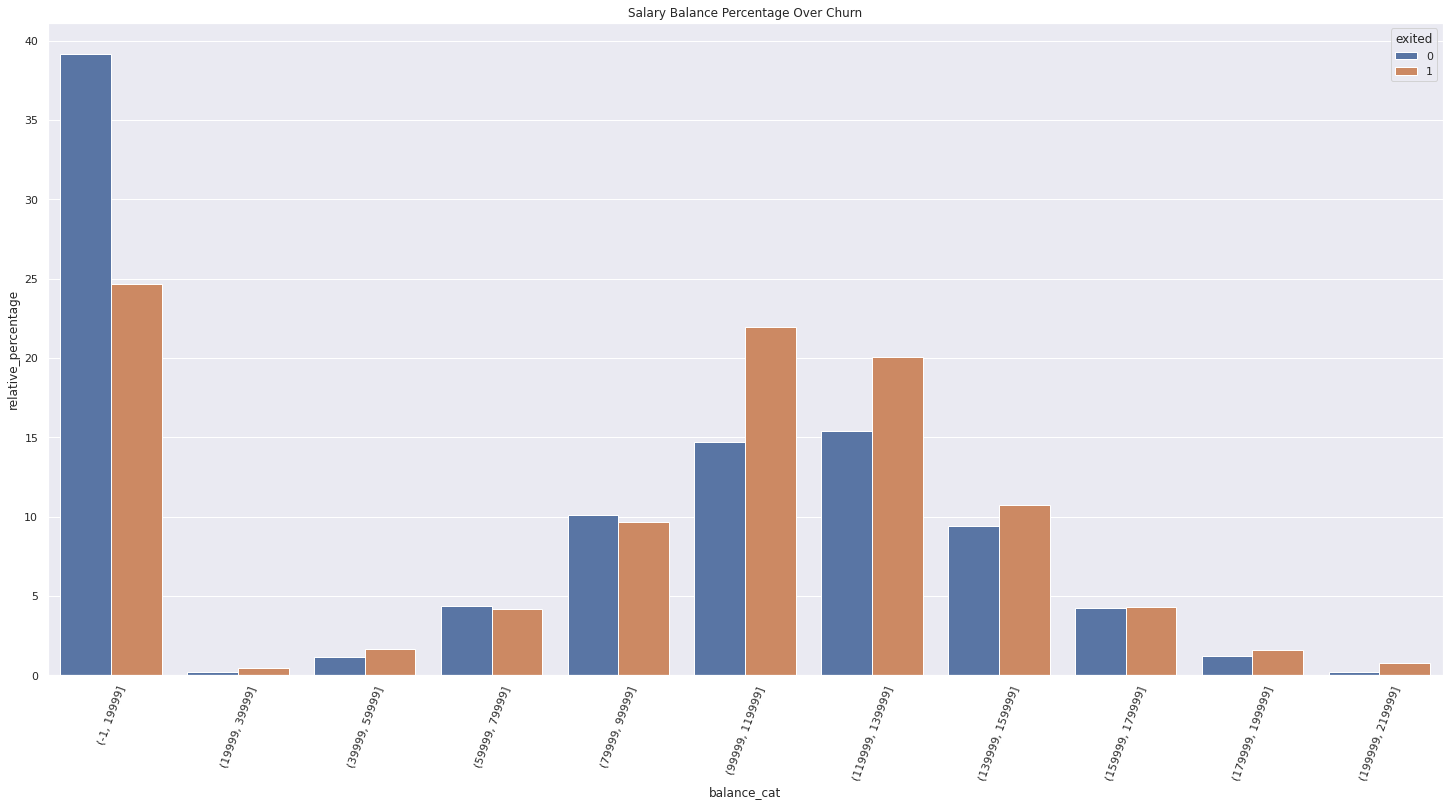

In [72]:
sns.barplot(data = aux20, x = 'balance_cat', y = 'relative_percentage', hue = 'exited' ).set_title('Salary Balance Percentage Over Churn')
plt.xticks(rotation = 70);

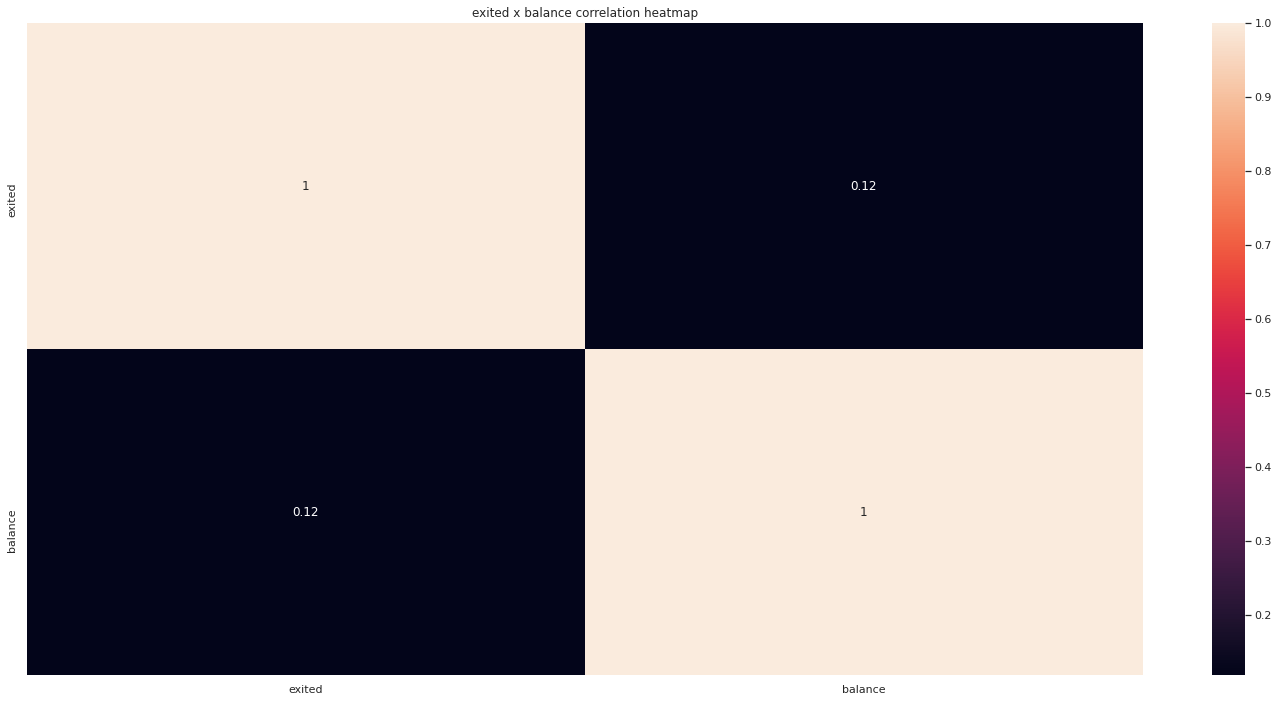

In [73]:
# point-biserial correlation coefficient heatmap.
# The point biserial correlation coefficient, rpbi, is a special case of Pearson’s correlation coefficient. It measures the relationship between two variables:
# One continuous variable (must be ratio scale or interval scale). and the other naturally binary variable.*

point_bi_corr(df3[['exited']], df3[['balance']]);

 Parafrasear
- 39% of clients not in churn have balance equal to zero. 24% of clients in churn have balance equal to zero.
- The balance density distribution shows that as the balance value increases, the relative proportion of clients in churn is greater than the proportion of clients not in churn.
- The Balance group's relative percentage barplot shows that from balance 90,000 on, the relative percentage of clients in churn is greater than the relative percentage of clients not in churn.
- The correlation heatmap shows a correlation coefficient of 0.12 between balance and exited feature.The balance x bal_ten_year scatterplot doesn't show a clear pattern of clients in churn.
- Therefore, the hypothesis is true: churn occur for clients with high balance.

### H3. Customers who live in France tend to be in churn
**FALSE** Customers who live in Germany churn more often

In [74]:
df3['geography'].value_counts(normalize = True)*100

France     50.14
Germany    25.09
Spain      24.77
Name: geography, dtype: float64

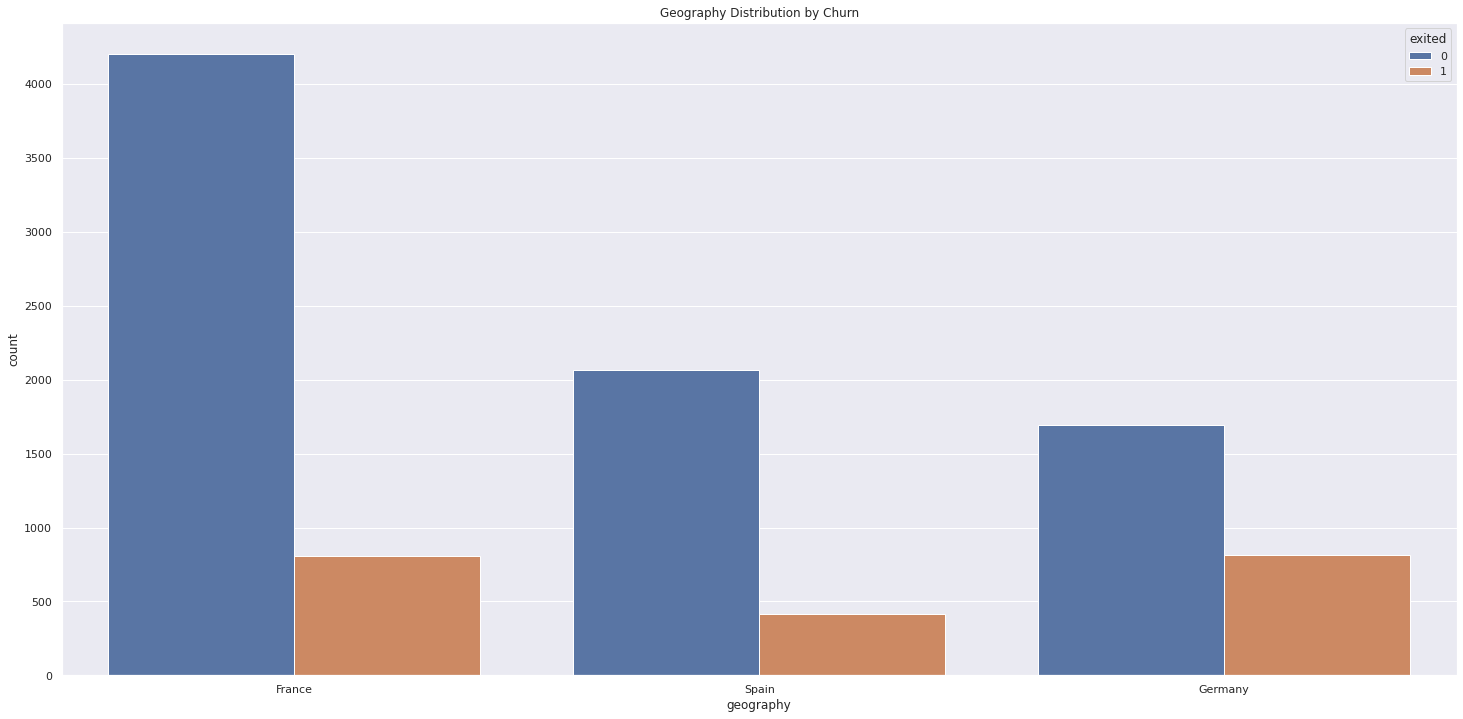

In [75]:
# countplot of geography by churn
sns.countplot(data = df3, x = 'geography', hue = 'exited').set_title('Geography Distribution by Churn');

In [76]:
# creating realite percentage once france has more costumers than the others
aux3 =  df3[['geography', 'balance','exited']].groupby(['geography', 'exited']).count().reset_index()
aux3.columns = ['geography', 'exited', 'num_of_clients']

#sum of clientes in churn

clients_churn = aux3.loc[aux20['exited'] == 1]['num_of_clients'].sum()
clients_not_churn = aux3.loc[aux20['exited'] == 0 ]['num_of_clients'].sum()

# evaluate relative percentage
aux3['relative_percentage'] = aux3.apply(lambda x: x['num_of_clients']/clients_churn*100 if x['exited'] == 1 else (x['num_of_clients']/clients_not_churn)*100, axis = 1)

aux3.head(10)


,geography,exited,num_of_clients,relative_percentage
0,France,0,4204,52.794173
1,France,1,810,39.764359
2,Germany,0,1695,21.285948
3,Germany,1,814,39.960727
4,Spain,0,2064,25.919879
5,Spain,1,413,20.274914


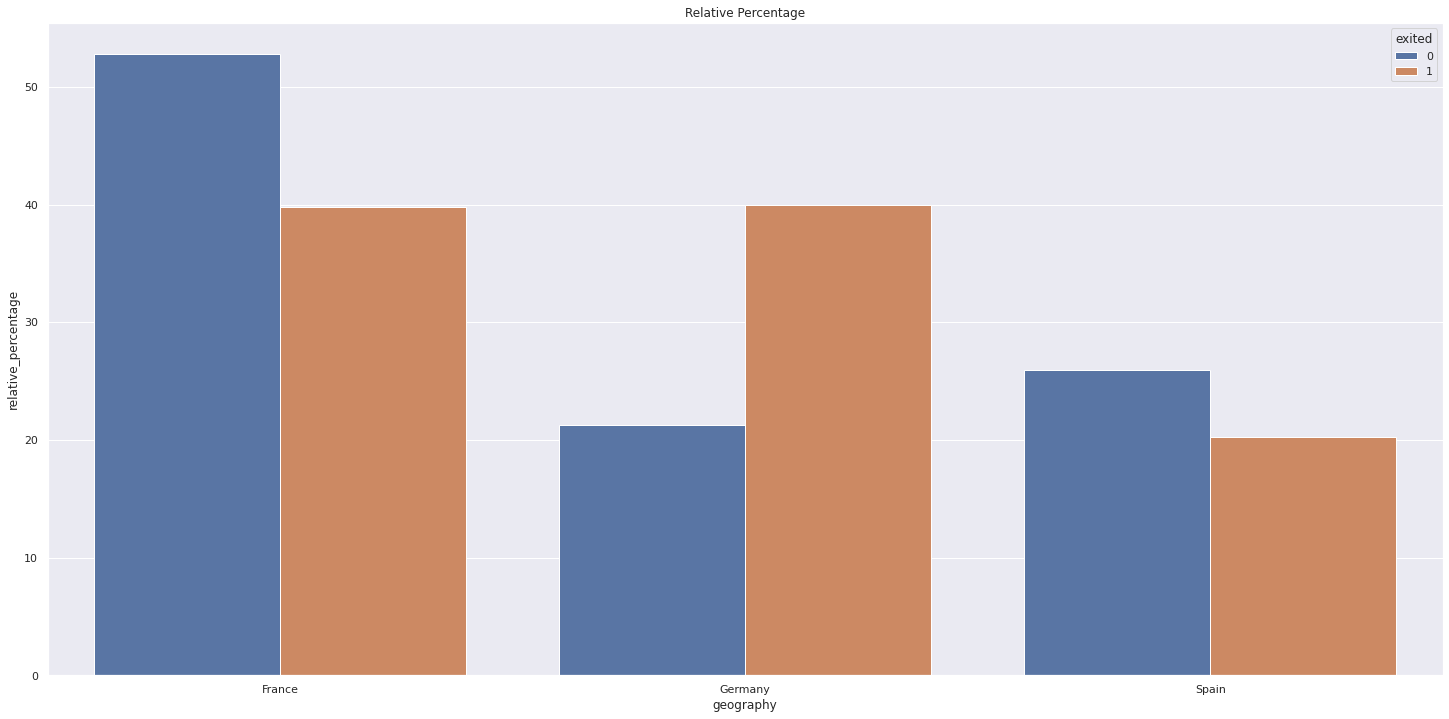

In [77]:
sns.barplot(data = aux3,x = 'geography', y = 'relative_percentage', hue = 'exited').set_title('Relative Percentage');

- As previously checked, 3993 clients (49.91%) are from France, 2005 clients (25.06%) are from Germany and 2002 clients (25.03%) are from Spain.
- Clients not in churn: 52.7% are from France, 26.2% are from Spain and 21.1% are from Germany. Compared to the whole dataset ratio, Germany decreased its proportion in aprox. 4%.
- Clients in churn: 40.7% are from Germany, 39% are from France and 20.3% are from Spain. Compared to the whole dataset ratio, Germany increased its proportion in aprox. 15%. Conversely, Spain's ratio decreased in aprox. 5%.
- Therefore, the hypothesis is False: Churn rate is lower for clients from Spain.

### H4. Active members should churn more than inactive ones
**False** Inactive members churn more often

In [78]:
df3['is_active_member'].value_counts()

1    5151
0    4849
Name: is_active_member, dtype: int64

In [79]:
df3['is_active_member'].value_counts(normalize = True)*100

1    51.51
0    48.49
Name: is_active_member, dtype: float64

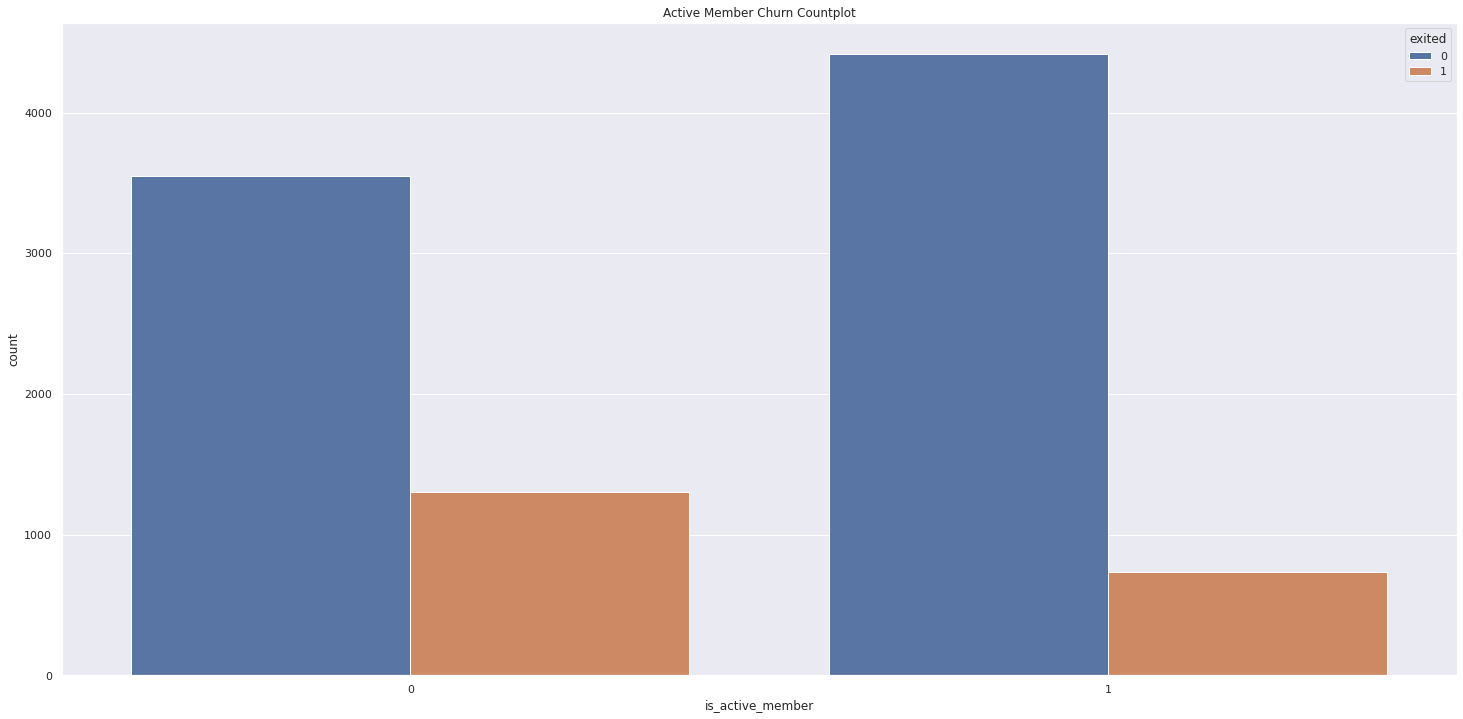

In [80]:
# plot active member by churn

sns.countplot(data = df3, x = 'is_active_member', hue = 'exited').set_title('Active Member Churn Countplot');

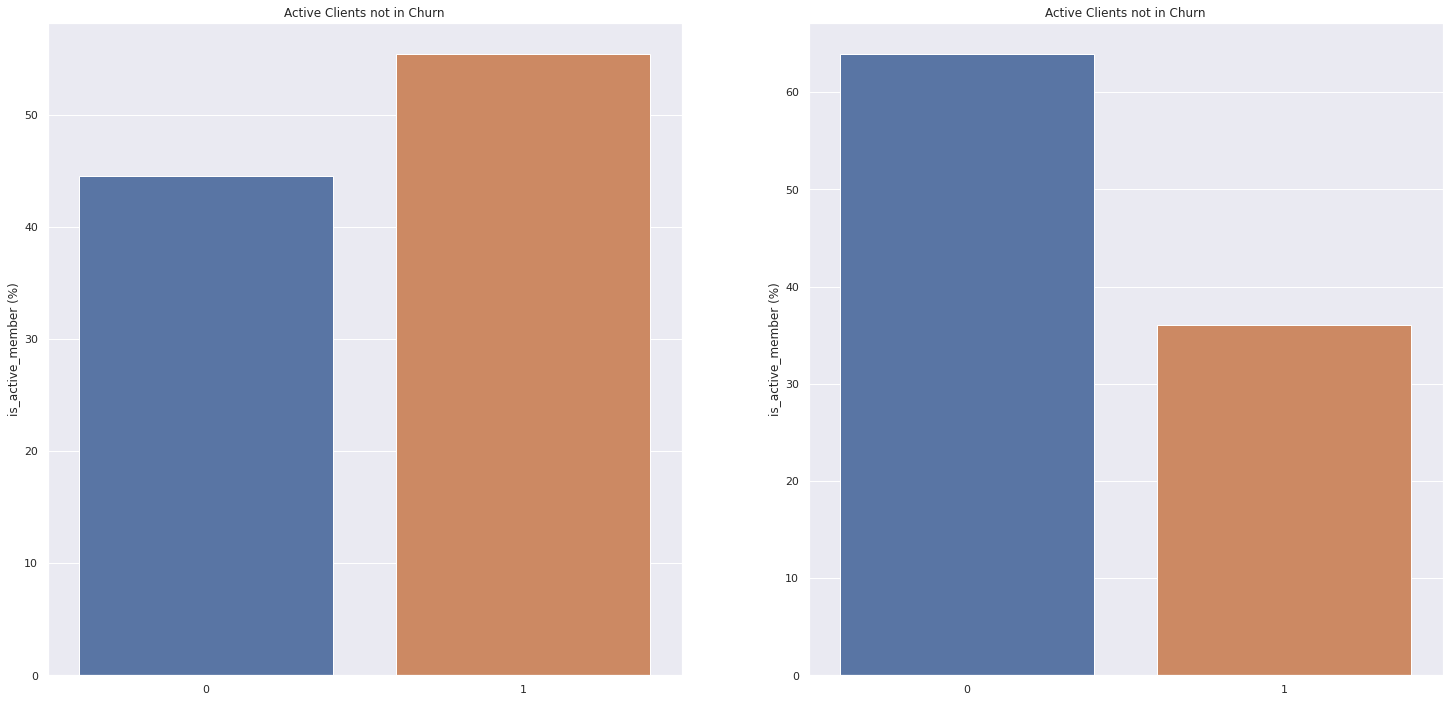

In [81]:
cred_card0 = aux_exited0['is_active_member'].value_counts(normalize = True)*100
cred_card1 = aux_exited1['is_active_member'].value_counts(normalize = True)*100


subplot(1, 2, 1)
sns.barplot(data = aux_exited0, x = cred_card0.index, y = cred_card0).set_title('Active Clients not in Churn')
plt.ylabel('is_active_member (%)')

subplot(1, 2, 2)
sns.barplot(data = aux_exited1, x = cred_card1.index, y = cred_card1).set_title('Active Clients not in Churn');
plt.ylabel('is_active_member (%)');

In [82]:
# creating realite percentage once france has more costumers than the others
aux4 =  df3[['is_active_member', 'balance','exited']].groupby(['is_active_member', 'exited']).count().reset_index()
aux4.columns = ['is_active_member', 'exited', 'num_of_clients']

#sum of clientes in churn

clients_churn = aux4.loc[aux20['exited'] == 1]['num_of_clients'].sum()
clients_not_churn = aux4.loc[aux20['exited'] == 0 ]['num_of_clients'].sum()

# evaluate relative percentage
aux4['relative_percentage'] = aux4.apply(lambda x: x['num_of_clients']/clients_churn*100 if x['exited'] == 1 else (x['num_of_clients']/clients_not_churn)*100, axis = 1)

aux4.head(10)


,is_active_member,exited,num_of_clients,relative_percentage
0,0,0,3547,44.543514
1,0,1,1302,63.917526
2,1,0,4416,55.456486
3,1,1,735,36.082474


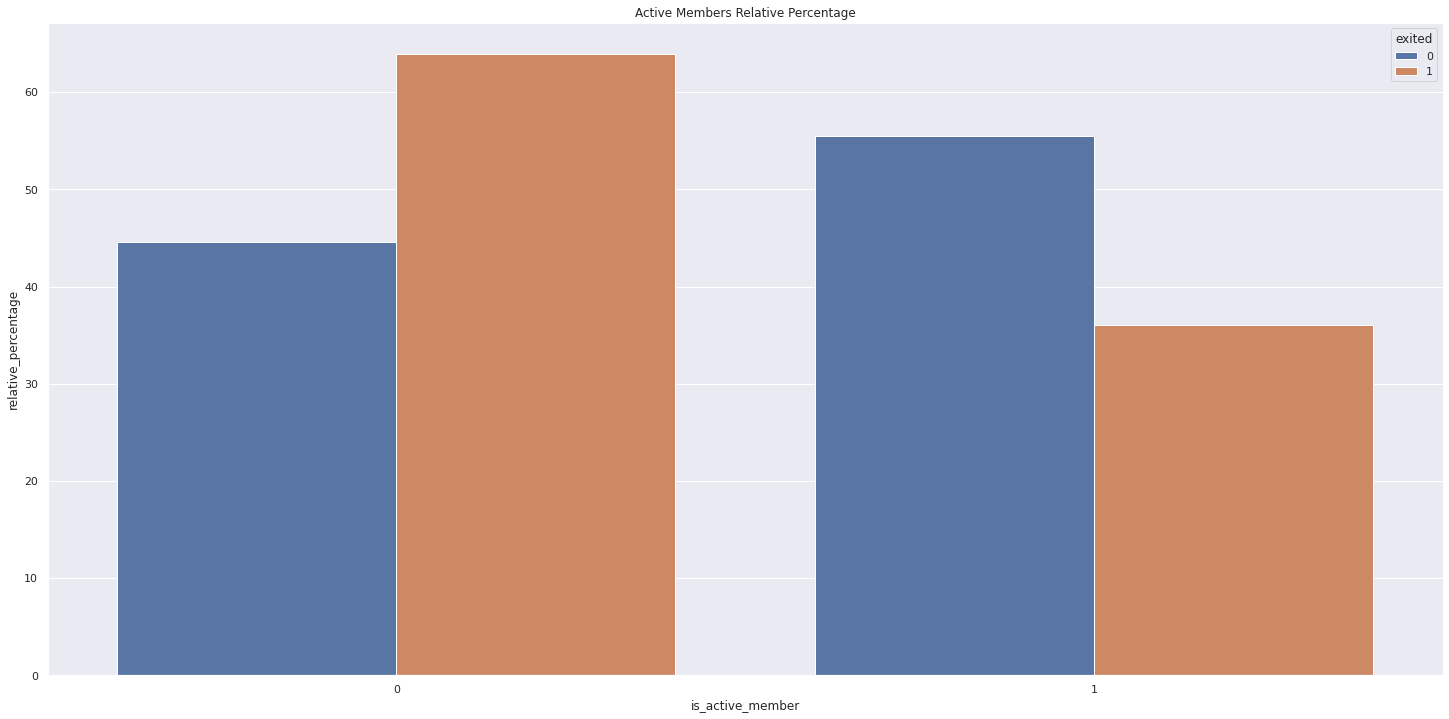

In [83]:
sns.barplot(data = aux4, x = 'is_active_member', y = 'relative_percentage', hue = 'exited').set_title('Active Members Relative Percentage');


 
- 51.5% of the clients are active members. 48.5% of the clients are not active members.
- Clients not in churn: 55.3% are active members. 44.7% are not active members.
- Clients in churn: 63.6% are not active members. 36.4% are active members, which corresponds to 594 clients, that is, even though they are active members, they decided to exit the bank.
- Therefore, the hypothesis is true: churn does not occur for active members

### H5. Younger costumers tend to churn more often
**FALSE** Clients between 30s and 50s churn more often

/home/marxcerqueira/.pyenv/versions/3.9.1/envs/Client-Churn-Prediction/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/marxcerqueira/.pyenv/versions/3.9.1/envs/Client-Churn-Prediction/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


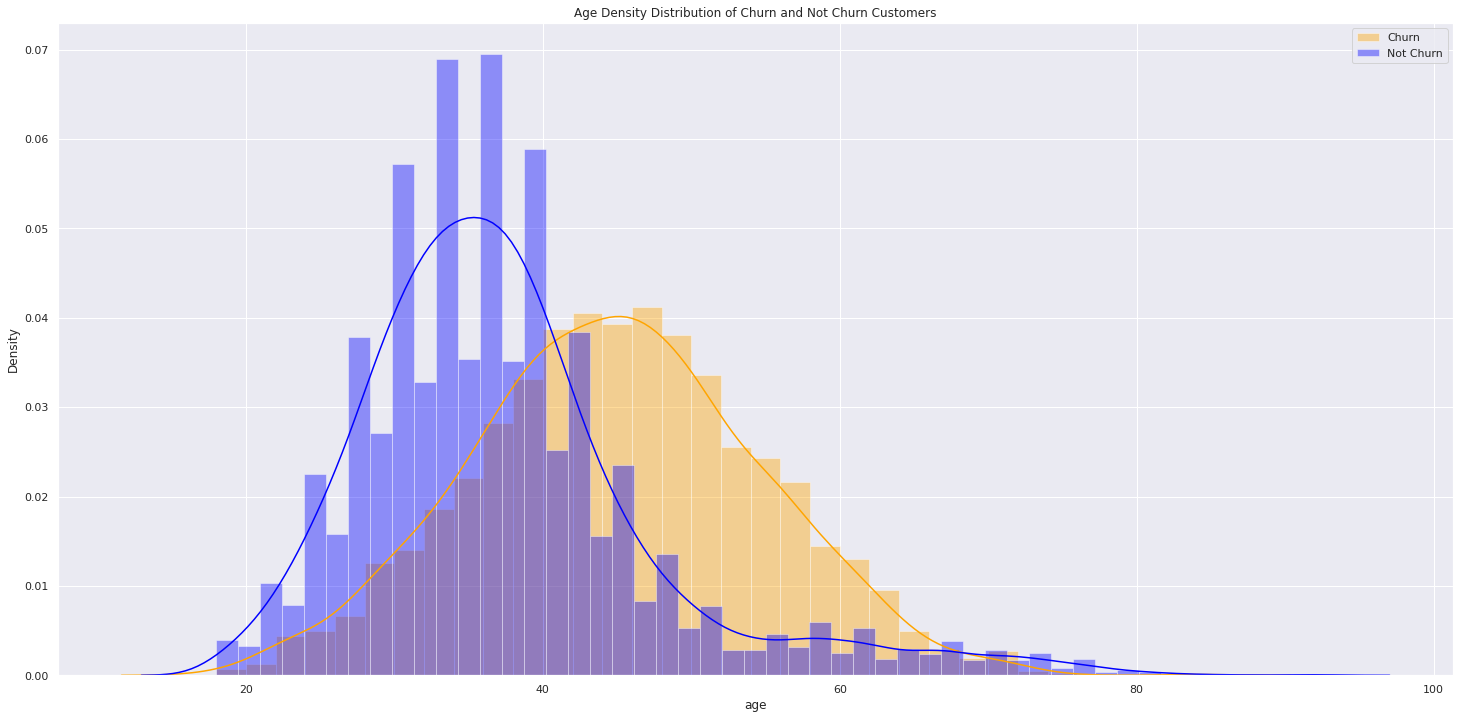

In [84]:
# auxiliary dataframe for exited = 0 and = 1
aux_exited0 = df3[df3['exited'] == 0]
aux_exited1 = df3[df3['exited'] == 1]

# plot estimated salary density distribution for exited = 0 and 1
sns.distplot(aux_exited1['age'], color = 'orange', kde = True, label = 'Churn')
sns.distplot(aux_exited0['age'], color = 'blue', kde = True, label = 'Not Churn')
plt.title('Age Density Distribution of Churn and Not Churn Customers');
plt.legend();

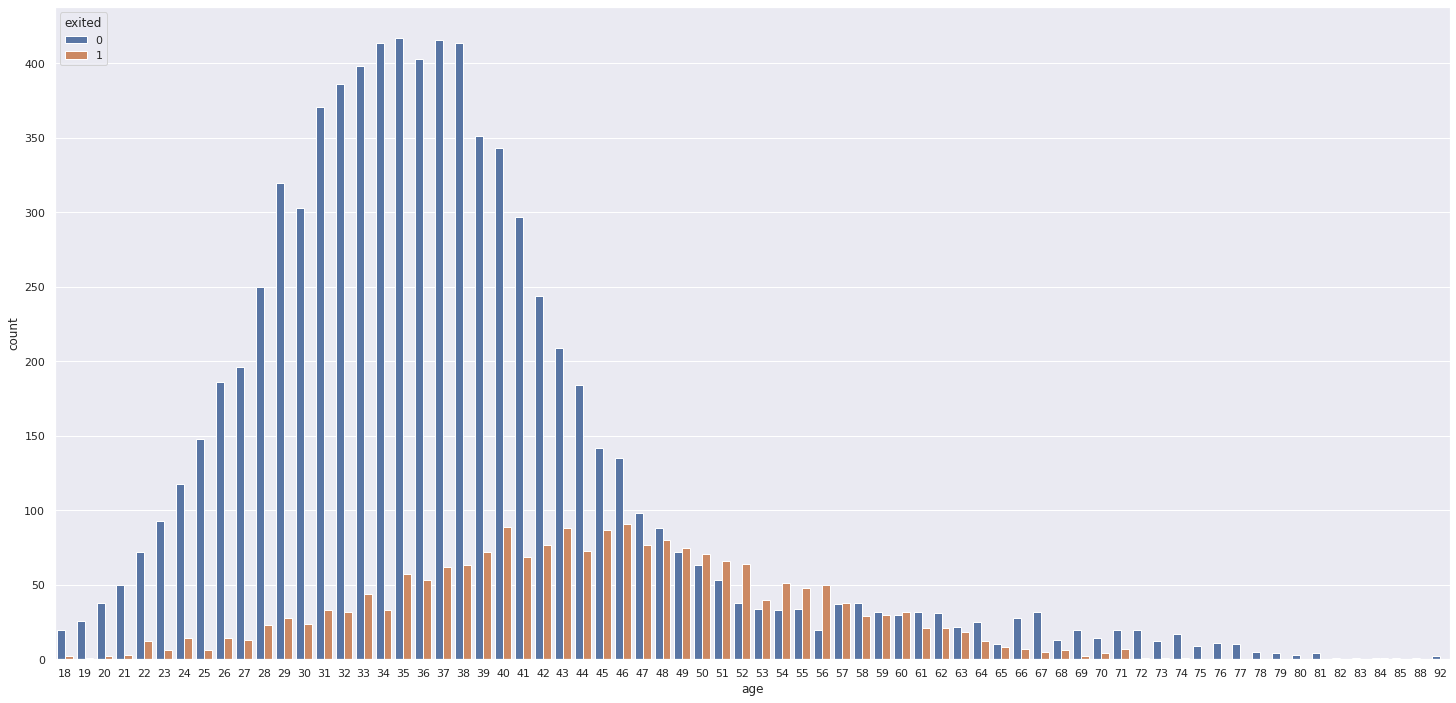

In [85]:
sns.countplot(data = df3, x = 'age', hue = 'exited');

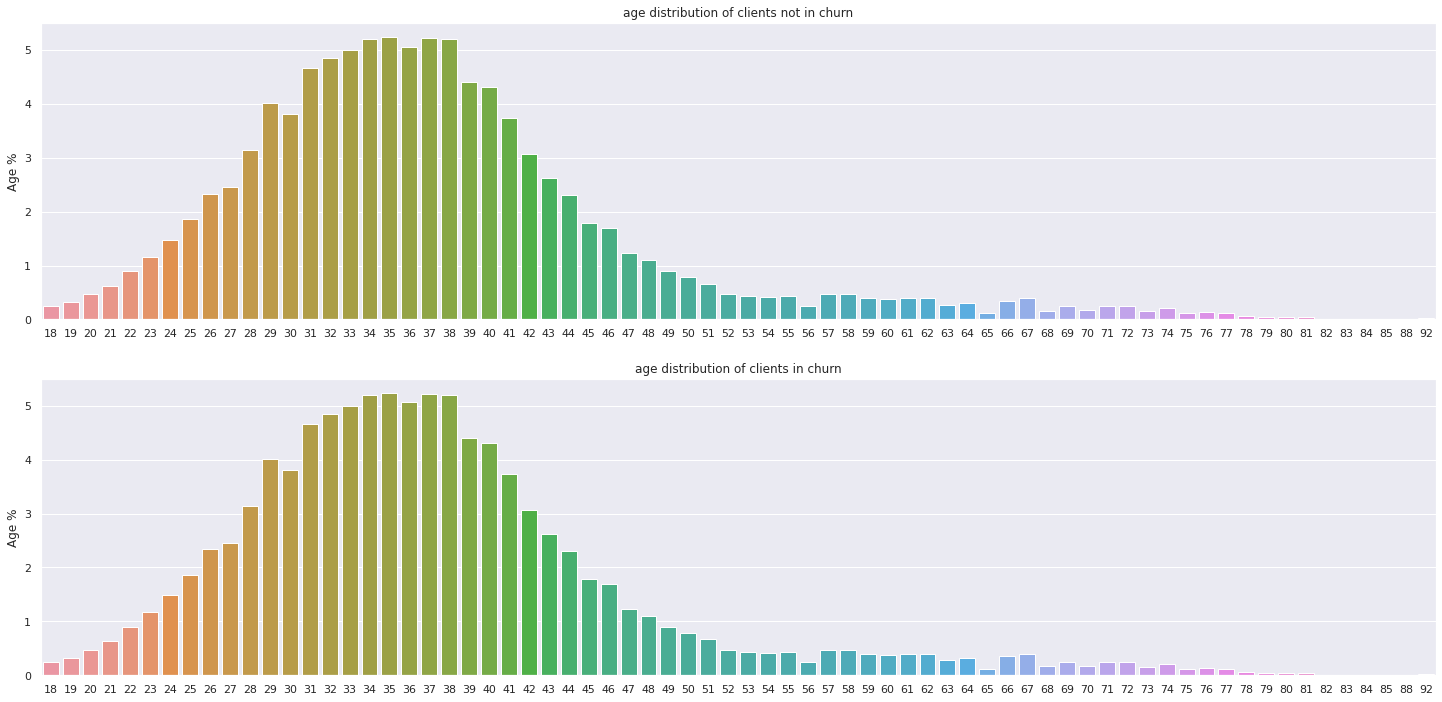

In [86]:
age_percentage0 = aux_exited0['age'].value_counts(normalize = True)*100
age_percentage1 = aux_exited1['age'].value_counts(normalize = True)*100

plt.subplot(2, 1, 1)
sns.barplot(data = aux_exited0, x = age_percentage0.index, y = age_percentage0).set_title('age distribution of clients not in churn');
plt.ylabel('Age %')

plt.subplot(2, 1, 2)
sns.barplot(data = aux_exited0, x = age_percentage0.index, y = age_percentage0).set_title('age distribution of clients in churn');
plt.ylabel('Age %');

In [87]:
# creating realite percentage once france has more costumers than the others
aux9 =  df3[['age', 'balance','exited']].groupby(['age', 'exited']).count().reset_index()
aux9.columns = ['age', 'exited', 'num_of_clients']

#sum of clientes in churn

clients_churn = aux9.loc[aux9['exited'] == 1]['num_of_clients'].sum()
clients_not_churn = aux9.loc[aux9['exited'] == 0 ]['num_of_clients'].sum()

# evaluate relative percentage
aux9['relative_percentage'] = aux9.apply(lambda x: x['num_of_clients']/clients_churn*100 if x['exited'] == 1 else (x['num_of_clients']/clients_not_churn)*100, axis = 1)

aux9.head(10)

,age,exited,num_of_clients,relative_percentage
0,18,0,20,0.251162
1,18,1,2,0.098184
2,19,0,26,0.326510
3,19,1,1,0.049092
4,20,0,38,0.477207
5,20,1,2,0.098184
6,21,0,50,0.627904
7,21,1,3,0.147275
8,22,0,72,0.904182
9,22,1,12,0.589102


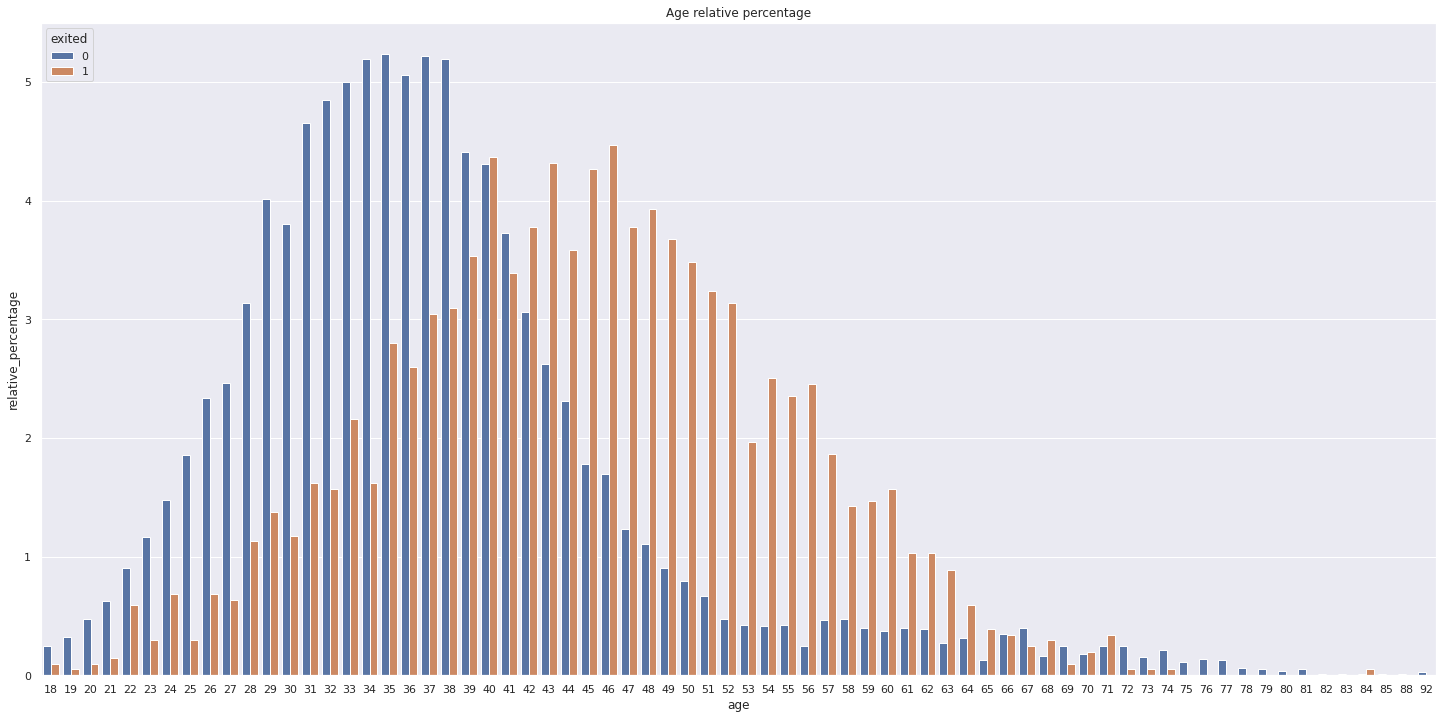

In [88]:
sns.barplot(data = aux9, x = 'age', y = 'relative_percentage', hue = 'exited').set_title('Age relative percentage');

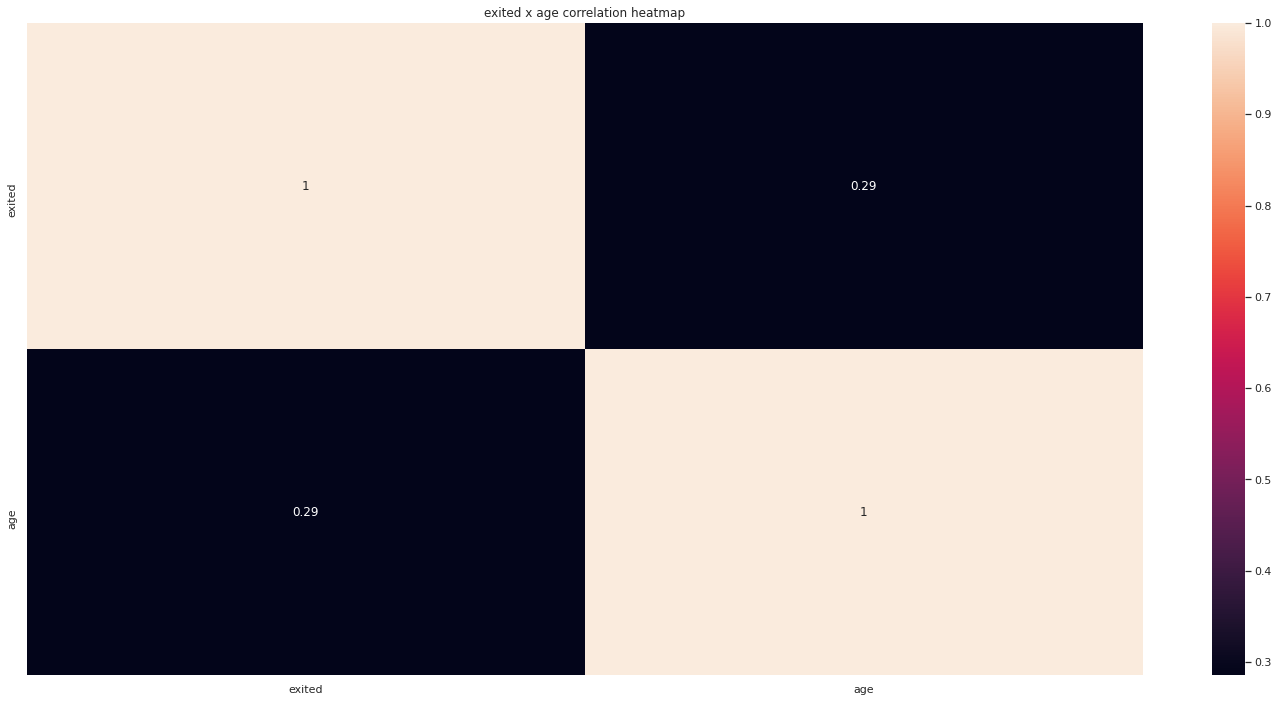

In [89]:
 # point-biserial correlation coefficient heatmap function.
point_bi_corr(df3[['exited']], df3[['age']]);

- The density distribution plot shows that churn is proportionaly greater from 40 year on.
- The relative percentage barplot shows that from 40 years until 65 years, the churn ration is greater than the not churn. For all other ages, the not churn proportion is greater.
- The correlation heatmap shows a correlation coefficient of 0.28.
- Therefore, the hypothesis is False: churn rate is lower among young clients.

### H6. Customers with credit card have more probability to churn
**False** Customers with no credit card have more probability to churn

In [90]:
df3['has_cr_card'].value_counts(normalize = True)*100

1    70.55
0    29.45
Name: has_cr_card, dtype: float64

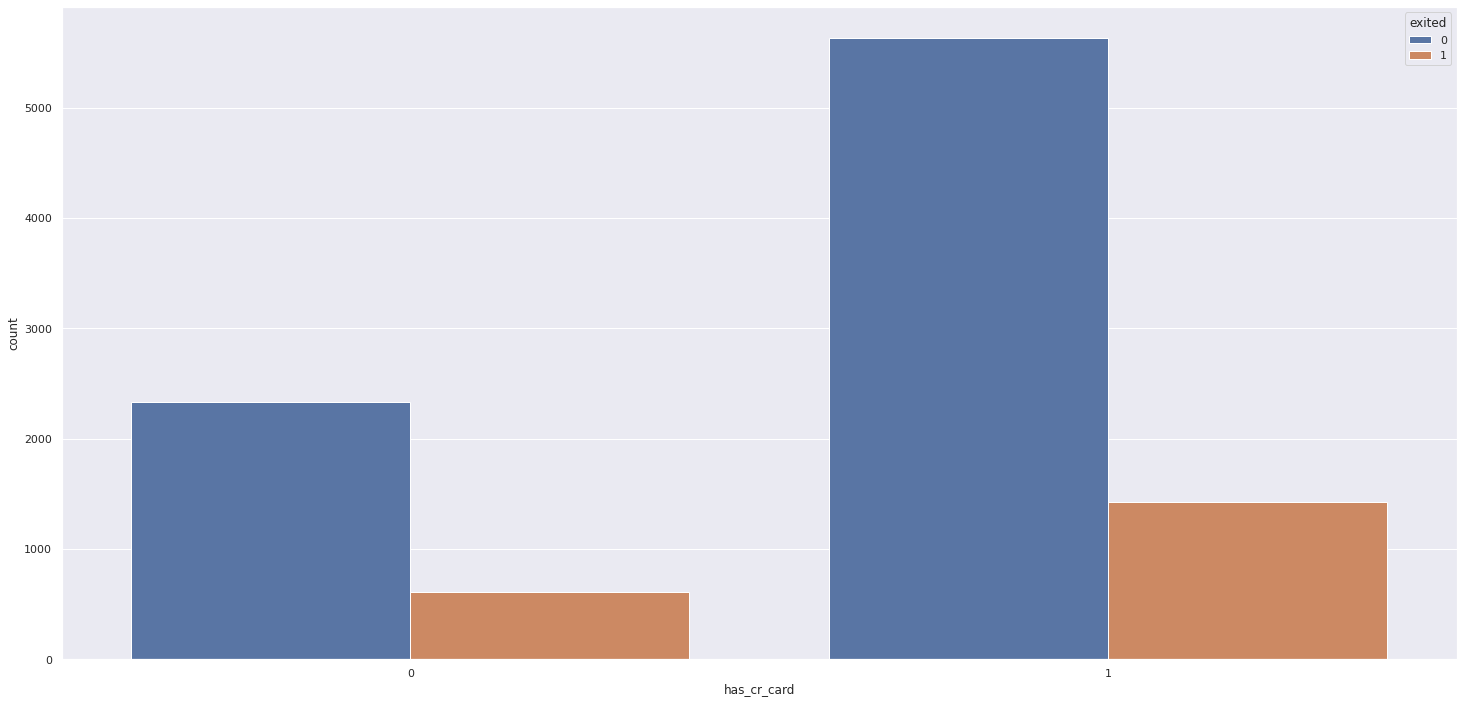

In [91]:
sns.countplot(data = df3, x = 'has_cr_card', hue = 'exited');

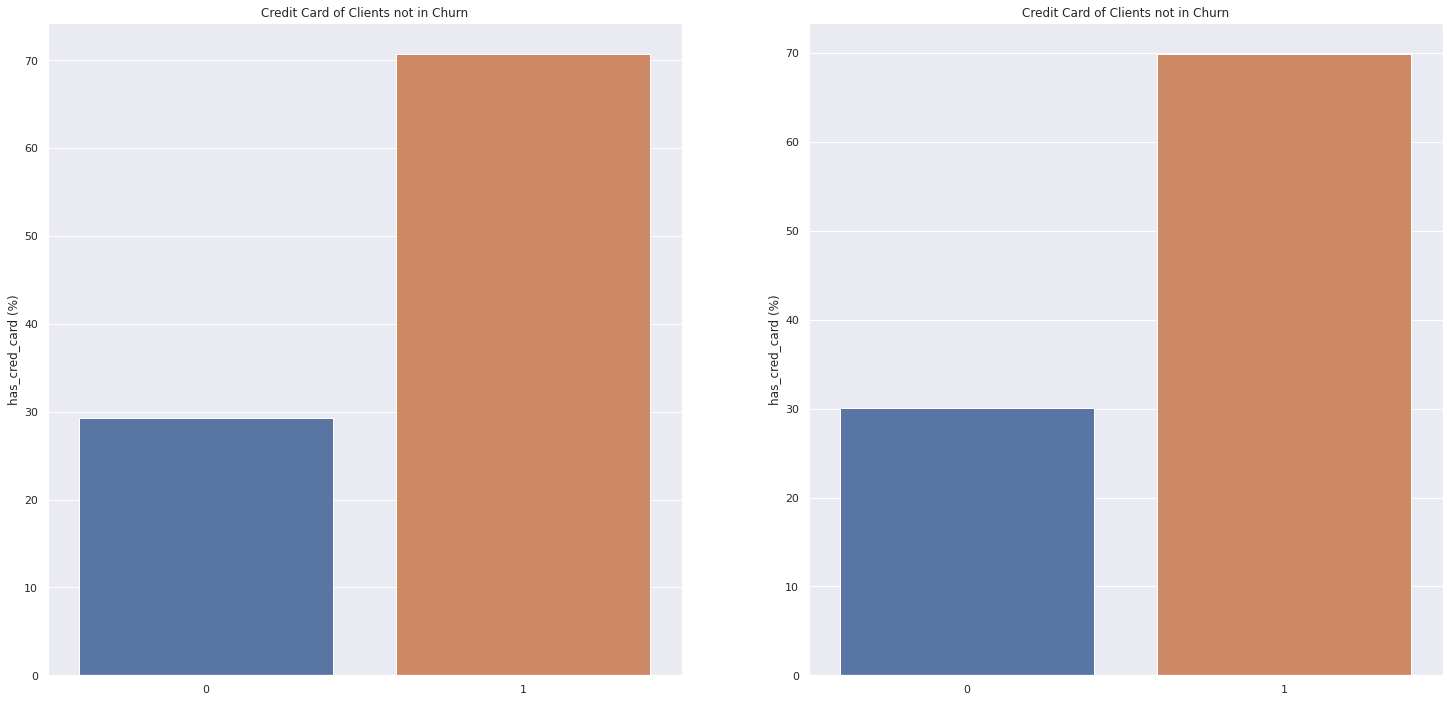

In [92]:
# credcard percentage by churn
cred_card0 = aux_exited0['has_cr_card'].value_counts(normalize = True)*100
cred_card1 = aux_exited1['has_cr_card'].value_counts(normalize = True)*100


subplot(1, 2, 1)
sns.barplot(data = aux_exited0, x = cred_card0.index, y = cred_card0).set_title('Credit Card of Clients not in Churn')
plt.ylabel('has_cred_card (%)')

subplot(1, 2, 2)
sns.barplot(data = aux_exited1, x = cred_card1.index, y = cred_card1).set_title('Credit Card of Clients not in Churn');
plt.ylabel('has_cred_card (%)');

In [93]:
# credit card relative percentage

aux5 = df3[['has_cr_card', 'exited', 'balance']].groupby(['has_cr_card', 'exited']).count().reset_index()
aux5.columns = ['has_cr_card', 'exited', 'num_of_clients']

#sum of clients with and without cred card sum

clients_churn = aux5.loc[aux20['exited'] == 1]['num_of_clients'].sum()
clients_not_churn = aux5.loc[aux20['exited'] == 0 ]['num_of_clients'].sum()

# evaluate relative percentage
aux5['relative_percentage'] = aux5.apply(lambda x: x['num_of_clients']/clients_churn*100 if x['exited'] == 1 else (x['num_of_clients']/clients_not_churn)*100, axis = 1)

aux5.head(10)

,has_cr_card,exited,num_of_clients,relative_percentage
0,0,0,2332,29.285445
1,0,1,613,30.093274
2,1,0,5631,70.714555
3,1,1,1424,69.906726


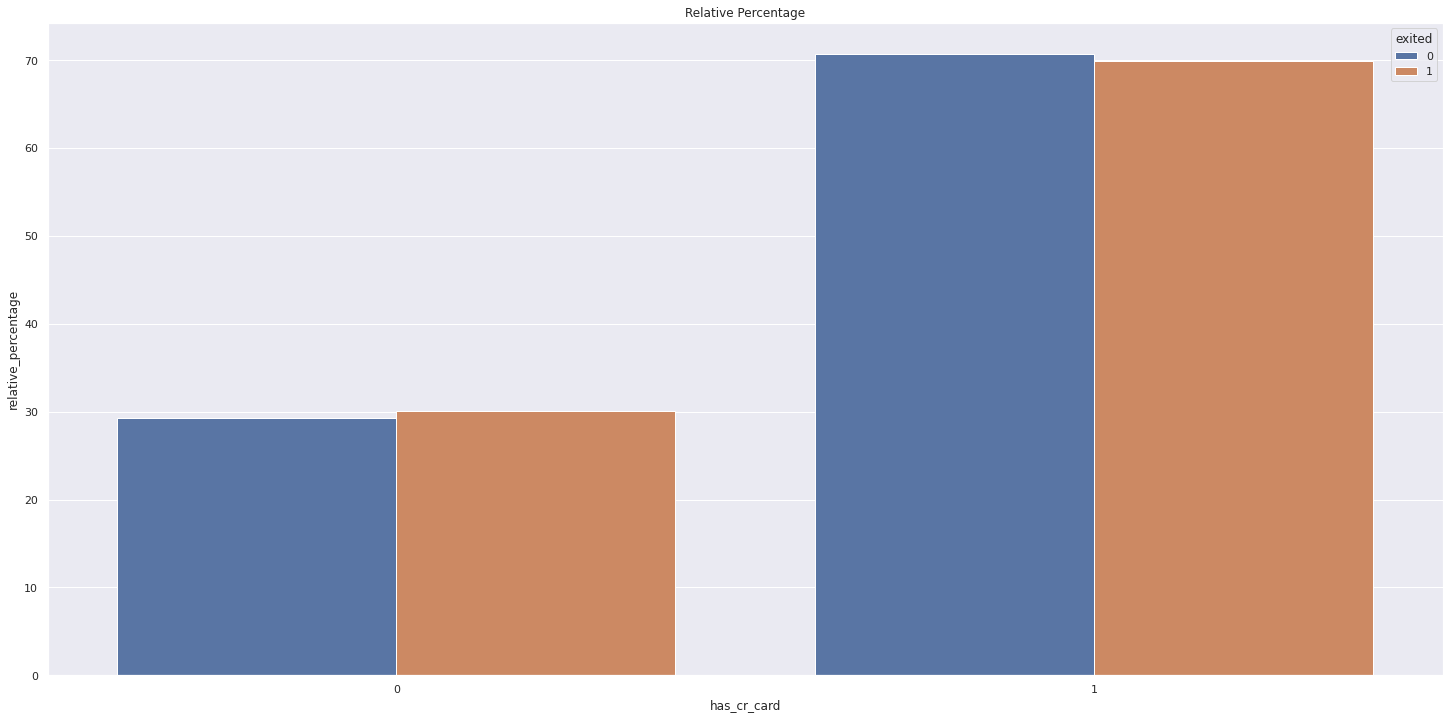

In [94]:
# plot relative percentage
sns.barplot(data = aux5, x = 'has_cr_card', y = 'relative_percentage', hue = 'exited').set_title('Relative Percentage');

- 70.9% of the customers have credit card.
- Clients not in churn: 71.2% have credit card. 28.8% have not credit card.
- Clients in churn: 69.6% have credit card. 30.4% have not credit card.
- The proportion of clients in churn without credit card (30.4%) is greater than the proportion of clients not in churn without credit card (28.8%).
- The proportion of clients not in churn with credit card (71.2%) is greater than the proportion of clients in churn with credit card (69.6%).
- Therefore, the hypothesis is True: churn does not occur for clients with credit card.

### H7. Customers with high credit scores have less probability to churn
**FALSE** Customers tend to churn more with fair score

In [96]:
# credit score
# credit scores from 580 to 669 are considered fair; 670 to 739 are considered good;
# 740 to 799 are considered very good; and 800 and up are considered excellent.
aux_cred = df3[['credit_score', 'exited']].copy()
aux_cred['credit_score_cat'] = df3['credit_score'].apply(lambda x: 'bad' if x < 580 else
                                                              'fair' if (x >= 580 ) & (x < 669) else
                                                              'good' if (x >= 699) & (x < 739) else
                                                              'very good' if (x >= 739) & (x < 799)
                                                               else 'excellent')

aux_cred = aux_cred[['credit_score', 'credit_score_cat', 'exited']]

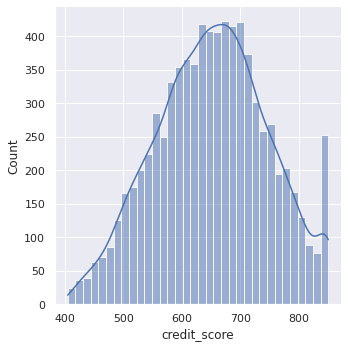

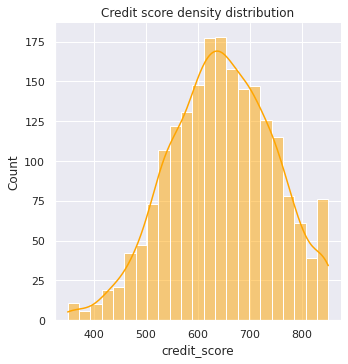

In [97]:
sns.displot(aux_exited0['credit_score'], label = 'Not Churn', kde = True, kind = 'hist');

sns.displot(aux_exited1['credit_score'], color = 'orange', label = 'Churn', kde = True);
plt.title('Credit score density distribution');

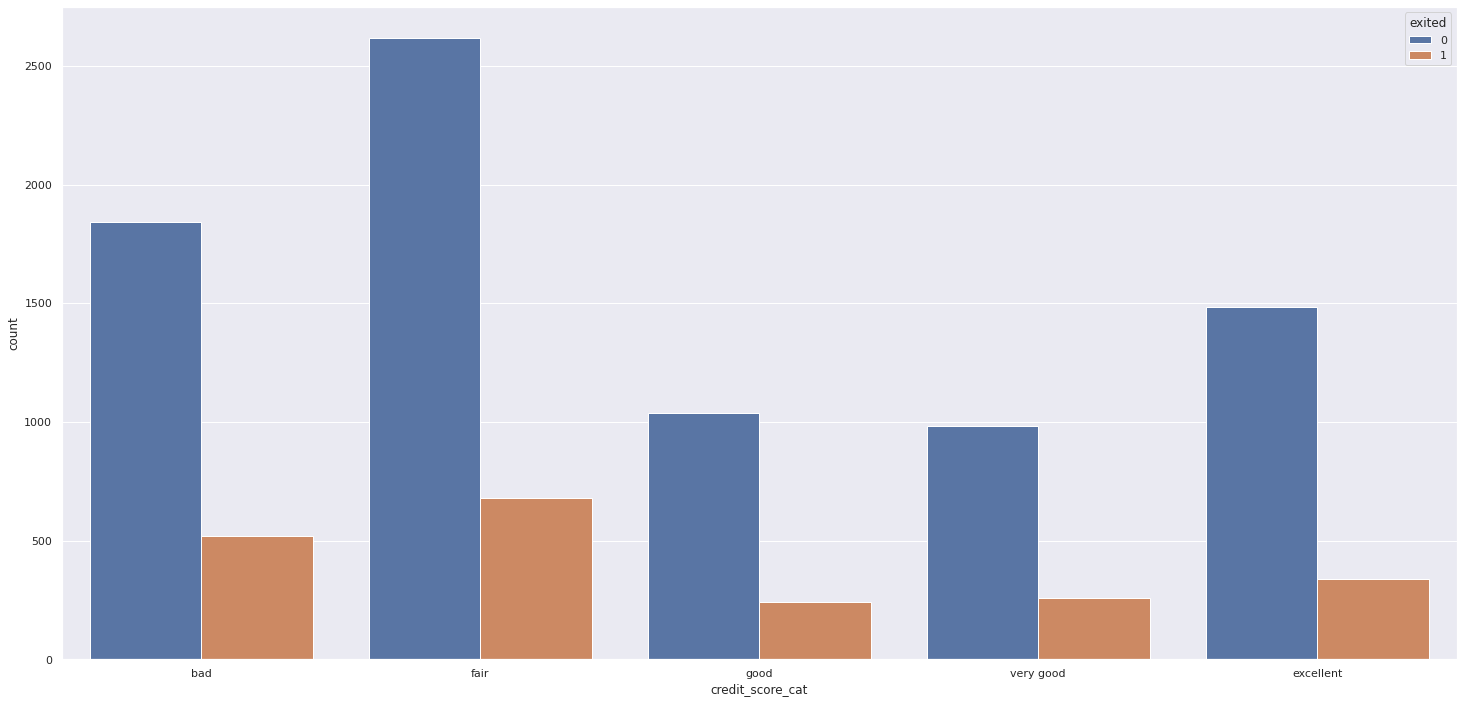

In [98]:
sns.countplot(data = aux_cred, x = 'credit_score_cat', order = ['bad', 'fair', 'good', 'very good','excellent'], hue = 'exited');

In [99]:
aux_cred.head()

,credit_score,credit_score_cat,exited
0,619,fair,1
1,608,fair,0
2,502,bad,1
3,699,good,0
4,850,excellent,0


In [100]:
# credit score relative percentage

aux6 = aux_cred[['credit_score', 'exited', 'credit_score_cat']].groupby(['credit_score_cat', 'exited']).count().reset_index()
aux6.columns = ['credit_score_cat', 'exited', 'num_of_clients']

#sum of clients with and without cred card sum

clients_churn = aux6.loc[aux20['exited'] == 1]['num_of_clients'].sum()
clients_not_churn = aux6.loc[aux20['exited'] == 0 ]['num_of_clients'].sum()

# evaluate relative percentage
aux6['relative_percentage'] = aux6.apply(lambda x: x['num_of_clients']/clients_churn*100 if x['exited'] == 1 else (x['num_of_clients']/clients_not_churn)*100, axis = 1)

aux6.head(10)

,credit_score_cat,exited,num_of_clients,relative_percentage
0,bad,0,1842,23.131985
1,bad,1,520,25.527737
2,excellent,0,1483,18.623634
3,excellent,1,339,16.642121
4,fair,0,2617,32.864498
5,fair,1,678,33.284242
6,good,0,1039,13.047846
7,good,1,243,11.929308
8,very good,0,982,12.332036
9,very good,1,257,12.616593


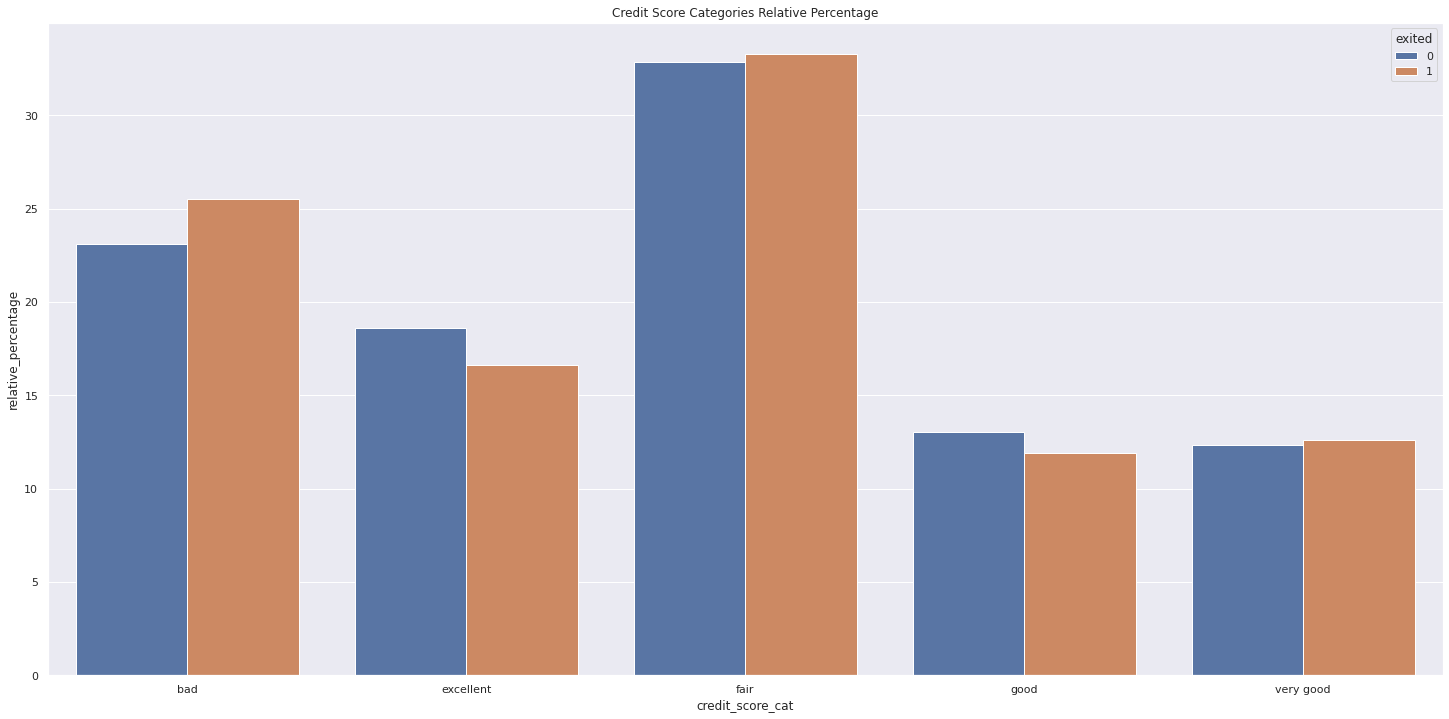

In [101]:
#Plot the relative percentage of clients in churn and not in churn per credit score.
sns.barplot(data = aux6, x = 'credit_score_cat', y = 'relative_percentage', hue = 'exited').set_title("Credit Score Categories Relative Percentage");

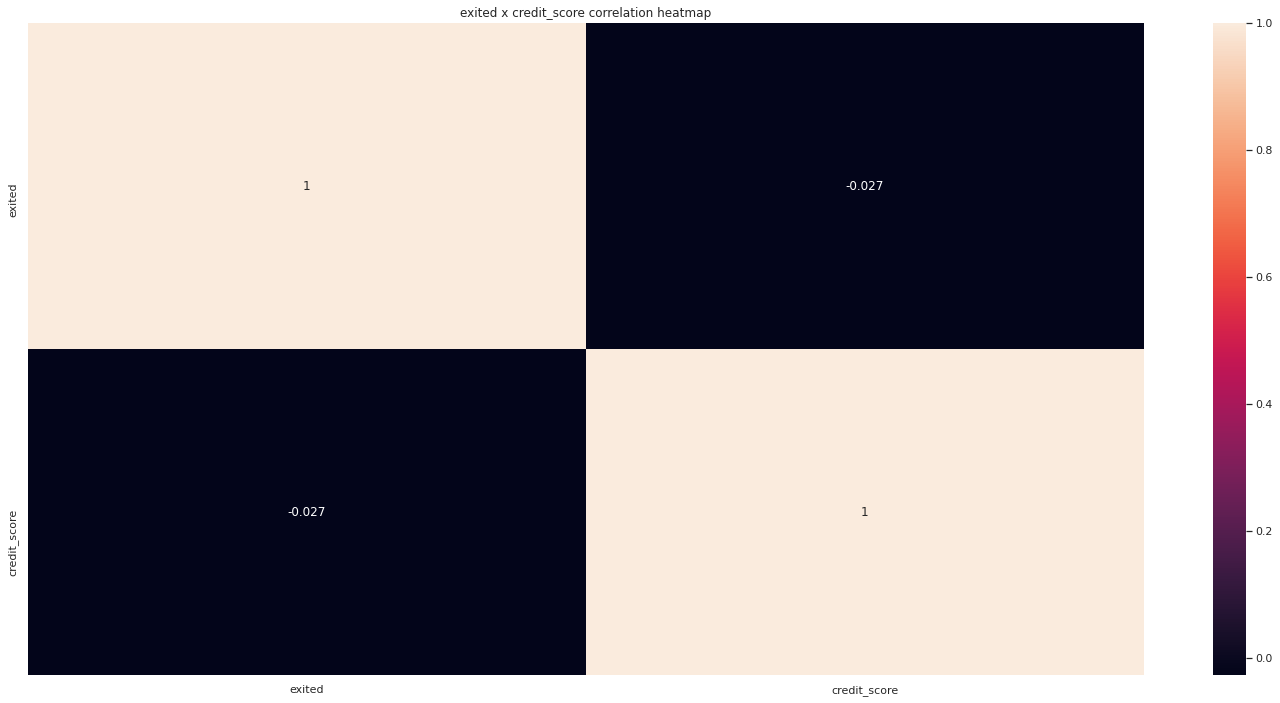

In [102]:
 # point-biserial correlation coefficient heatmap function. For details, please see section 0.2. Helper Functions.
point_bi_corr(df3[['exited']], df3[['credit_score']]);

### H8. Customers with less products tend to churn more
**True** 


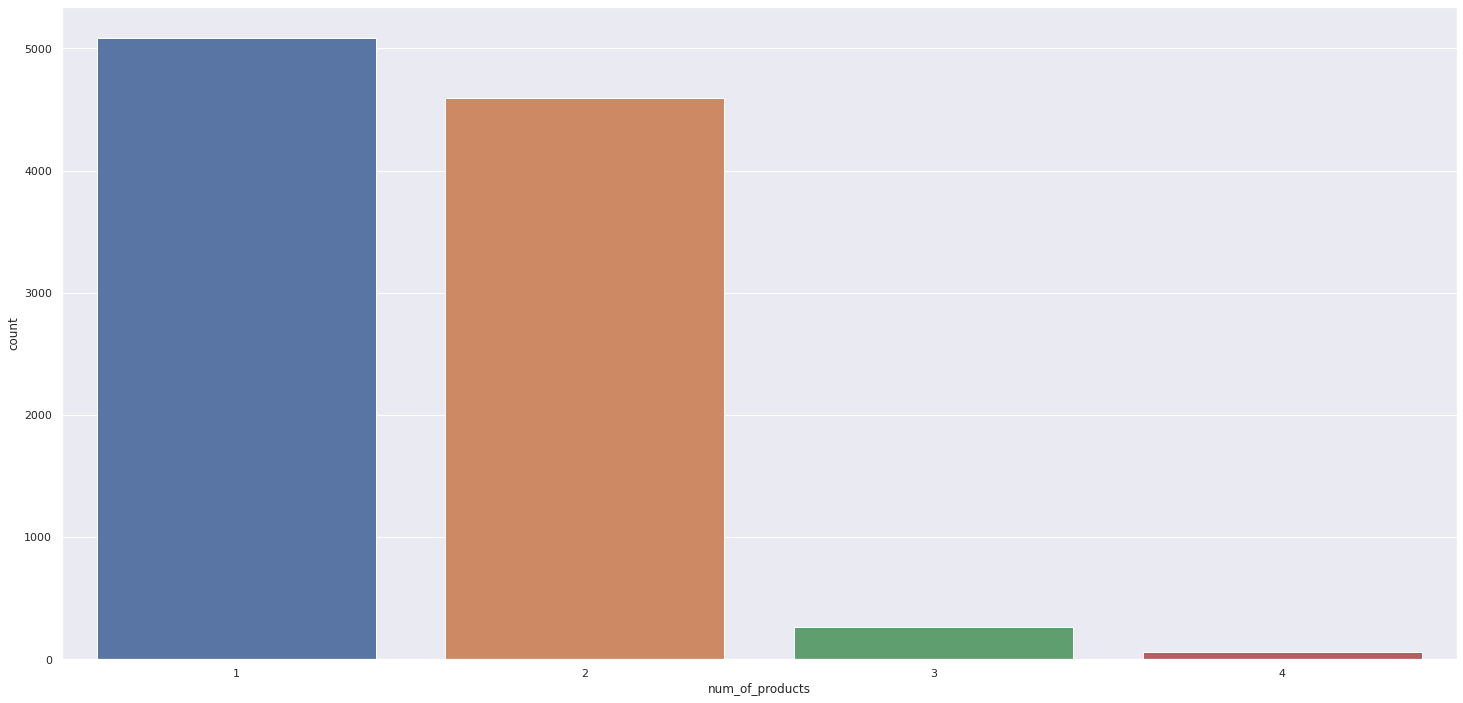

In [103]:
# number of products countplot

sns.countplot(data = df3, x = 'num_of_products');

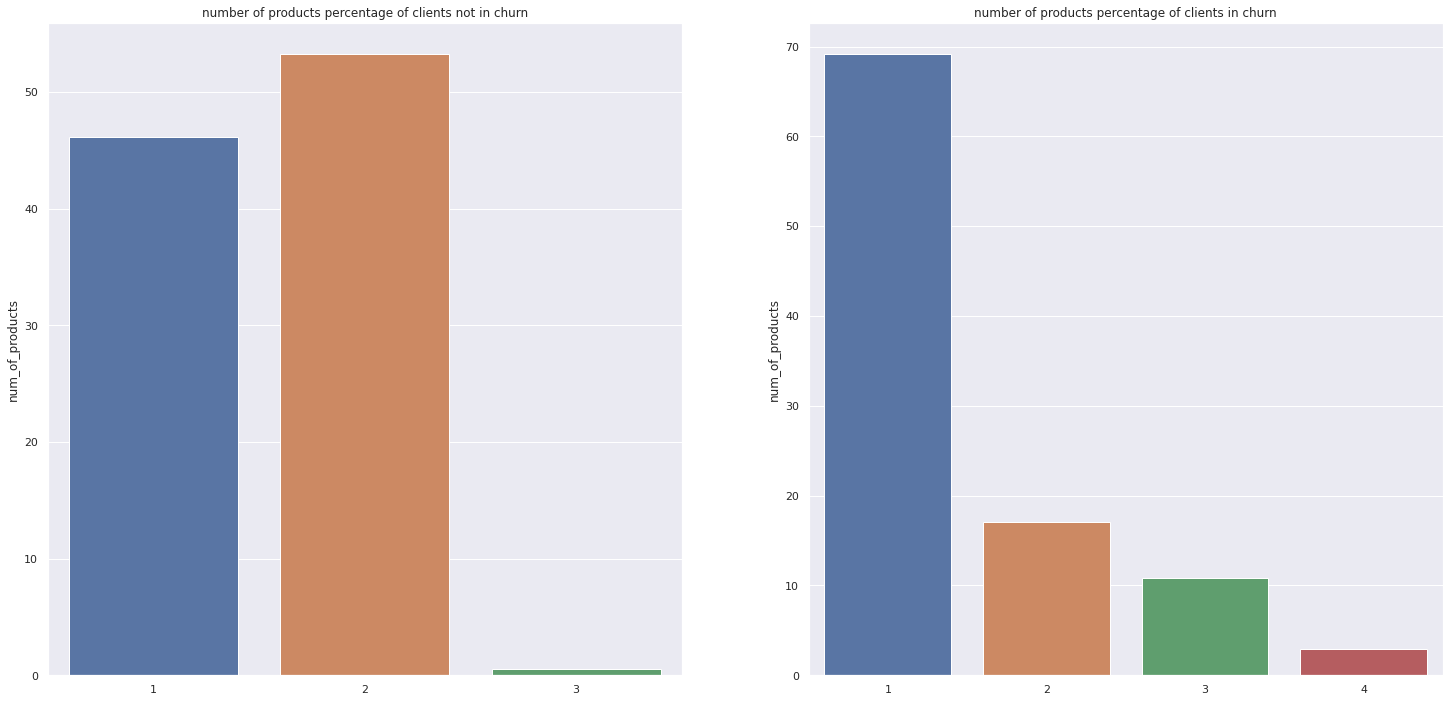

In [104]:
# number of products countplot
aux0 = df3[df3['exited'] == 0]
aux1 = df3[df3['exited'] == 1]

product_churn0 = aux0['num_of_products'].value_counts(normalize = True)*100
product_churn1 = aux1['num_of_products'].value_counts(normalize = True)*100

subplot(1, 2, 1)
sns.barplot(data = aux0, x = product_churn0.index ,y = product_churn0).set_title('number of products percentage of clients not in churn');

subplot(1, 2, 2)
sns.barplot(data = aux1, x = product_churn1.index ,y = product_churn1).set_title('number of products percentage of clients in churn');

In [105]:
product_churn0

2    53.271380
1    46.150948
3     0.577672
Name: num_of_products, dtype: float64

In [106]:
product_churn1

1    69.170349
2    17.083947
3    10.800196
4     2.945508
Name: num_of_products, dtype: float64

In [107]:
df3['num_of_products'].value_counts(normalize = True)*100

1    50.84
2    45.90
3     2.66
4     0.60
Name: num_of_products, dtype: float64

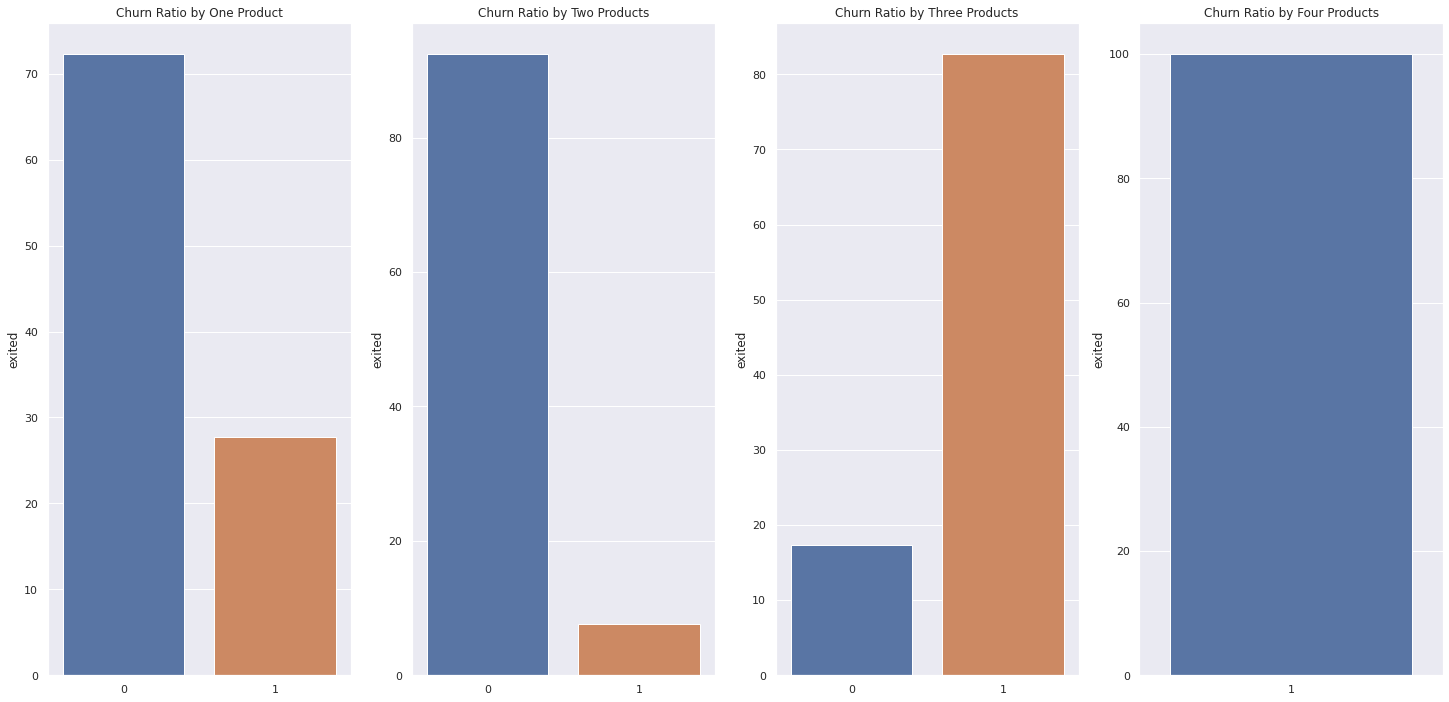

In [108]:
plt.subplot(1, 4, 1)
aux3 = df3[df3['num_of_products']==1]
churn_prod_1 = aux3['exited'].value_counts(normalize=True)*100
sns.barplot(x = churn_prod_1.index, y = churn_prod_1)
# plt.xlabel(['Not Churn', 'Churn'])
plt.title('Churn Ratio by One Product')

plt.subplot(1, 4, 2)
aux3 = df3[df3['num_of_products']==2]
churn_prod_2 = aux3['exited'].value_counts(normalize=True)*100
sns.barplot(x = churn_prod_2.index, y = churn_prod_2)
plt.title('Churn Ratio by Two Products')

plt.subplot(1, 4, 3)
aux3 = df3[df3['num_of_products']==3]
churn_prod_3 = aux3['exited'].value_counts(normalize=True)*100
sns.barplot(x = churn_prod_3.index, y = churn_prod_3)
plt.title('Churn Ratio by Three Products')

plt.subplot(1, 4, 4)
aux3 = df3[df3['num_of_products']==4]
churn_prod_4 = aux3['exited'].value_counts(normalize=True)*100
sns.barplot(x = churn_prod_4.index, y = churn_prod_4);
plt.title('Churn Ratio by Four Products');

In [109]:
# number of products relative percentage

aux7 = df3[['num_of_products', 'exited', 'balance']].groupby(['num_of_products', 'exited']).count().reset_index()
aux7.columns = ['num_of_products', 'exited', 'num_of_clients']

#sum of clients with and without cred card sum

clients_churn = aux7.loc[aux7['exited'] == 1]['num_of_clients'].sum()
clients_not_churn = aux7.loc[aux7['exited'] == 0 ]['num_of_clients'].sum()

# evaluate relative percentage
aux7['relative_percentage'] = aux7.apply(lambda x: x['num_of_clients']/clients_churn*100 if x['exited'] == 1 else (x['num_of_clients']/clients_not_churn)*100, axis = 1)

aux7.head(10)

,num_of_products,exited,num_of_clients,relative_percentage
0,1,0,3675,46.150948
1,1,1,1409,69.170349
2,2,0,4242,53.271380
3,2,1,348,17.083947
4,3,0,46,0.577672
5,3,1,220,10.800196
6,4,1,60,2.945508


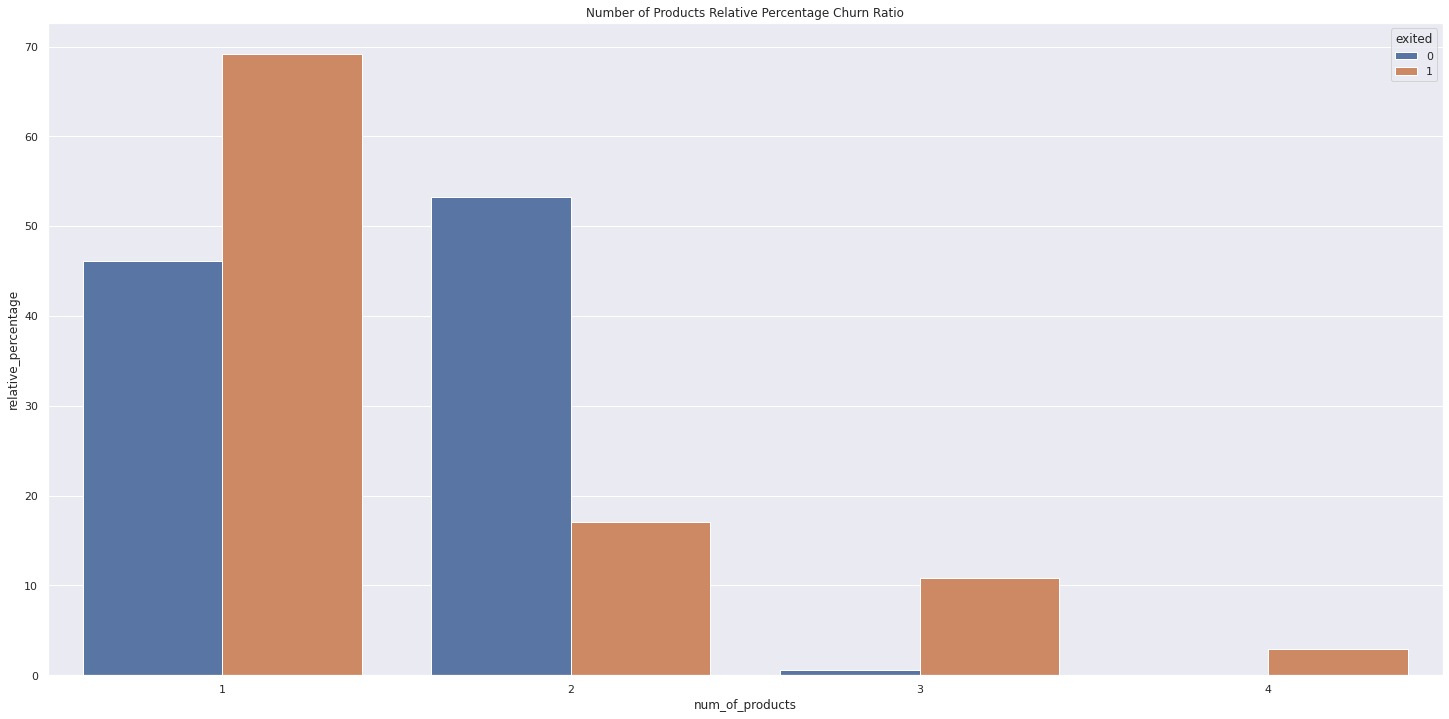

In [110]:
sns.barplot(data = aux7, x = 'num_of_products', y = 'relative_percentage', hue = 'exited').set_title('Number of Products Relative Percentage Churn Ratio');

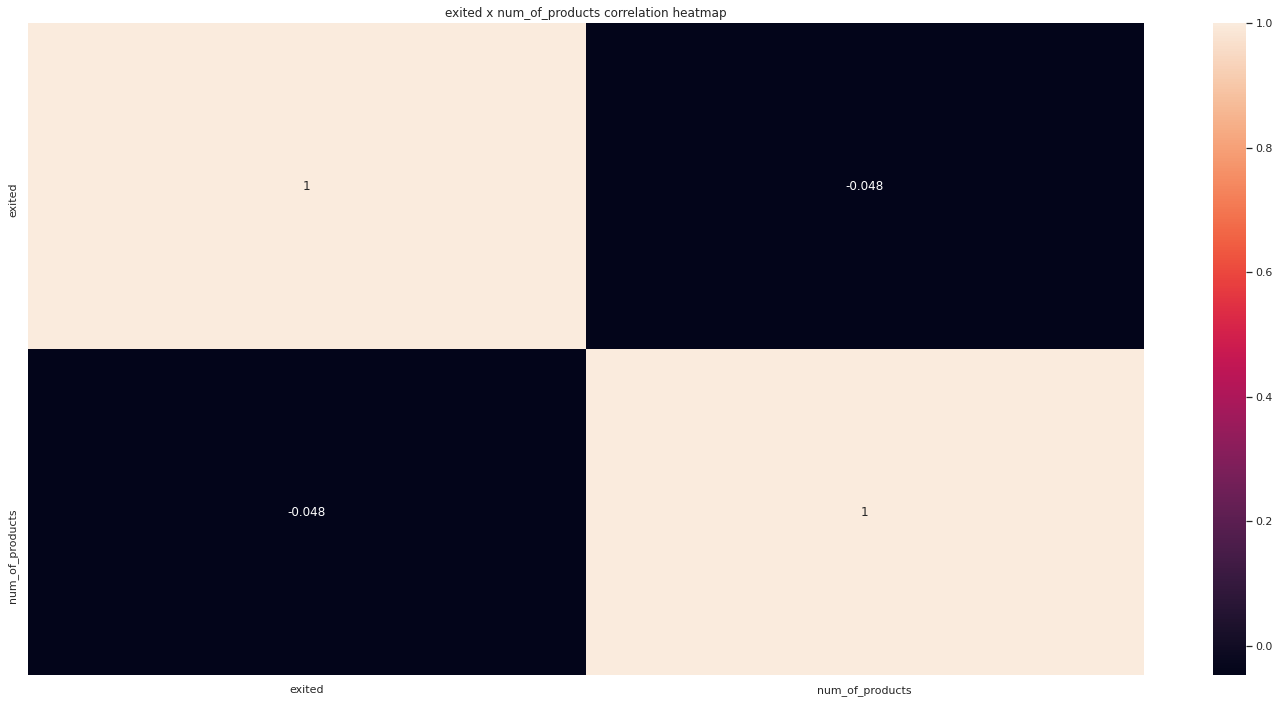

In [111]:
 # point-biserial correlation coefficient heatmap function.
point_bi_corr(df3[['exited']], df3[['num_of_products']]);

In [112]:
aux3 = df3[df3['num_of_products']==1]
churn_prod_1 = aux3['exited'].value_counts(normalize=True)*100

In [113]:
aux3 = df3[df3['num_of_products']==2]
churn_prod_2 = aux3['exited'].value_counts(normalize=True)*100

In [114]:
aux3 = df3[df3['num_of_products']==3]
churn_prod_3 = aux3['exited'].value_counts(normalize=True)*100

In [115]:
aux3 = df3[df3['num_of_products']==4]
churn_prod_4 = aux3['exited'].value_counts(normalize=True)*100

### H9. Womans tend to churn more often than mens
**True**

In [116]:
df3['gender'].value_counts(normalize = True)*100

Male      54.57
Female    45.43
Name: gender, dtype: float64

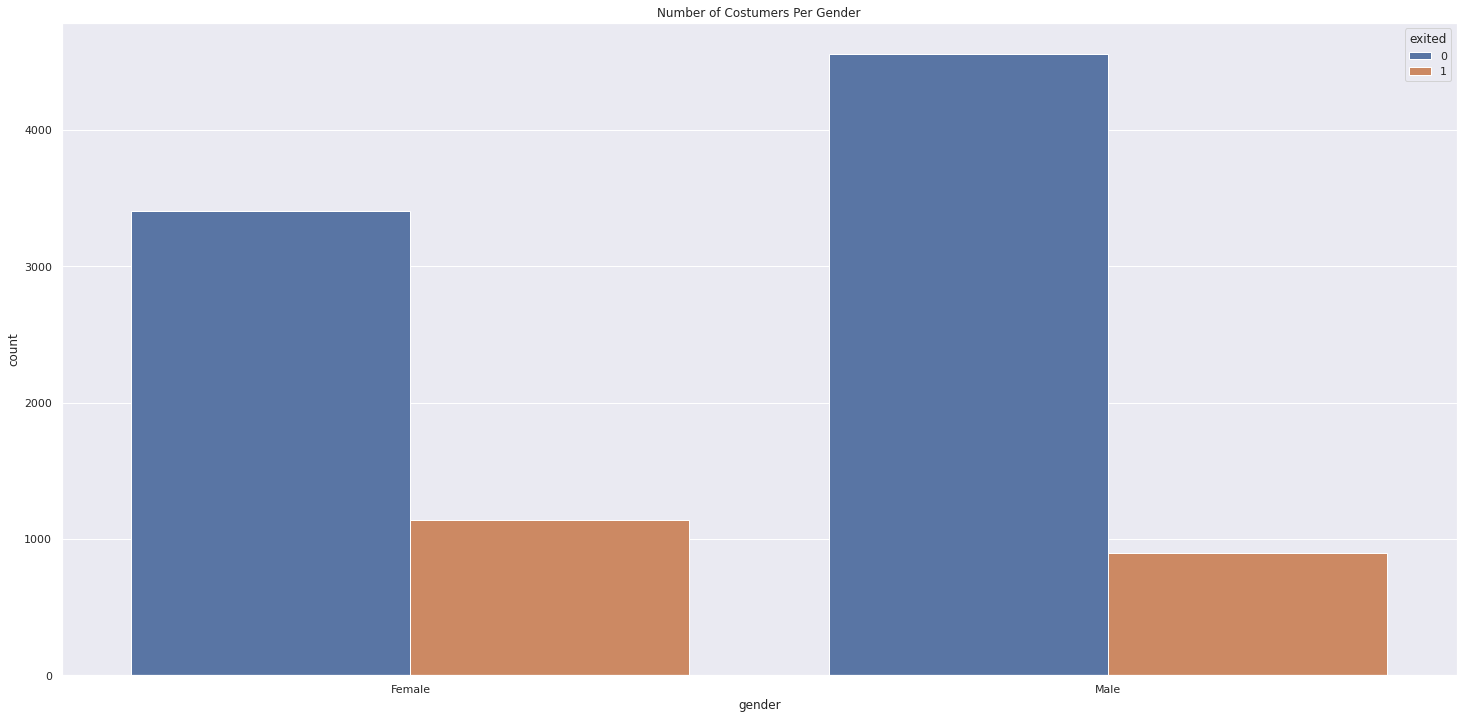

In [117]:
# countplot gender
sns.countplot(data = df3, x = 'gender', hue = 'exited').set_title('Number of Costumers Per Gender');

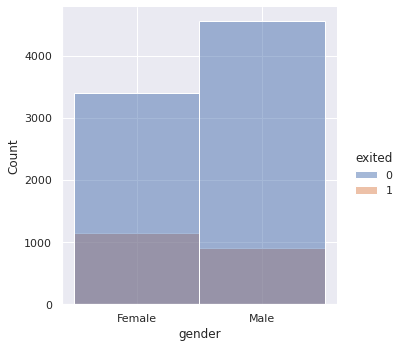

In [118]:
# gender distribution by churn
sns.displot(data = df3, x = 'gender', hue = 'exited', hue_order = [0,1], color = 'orange');

In [119]:
df3['gender'].value_counts(normalize = True)*100

Male      54.57
Female    45.43
Name: gender, dtype: float64

In [120]:
g_percentage_0 = aux_exited0['gender'].value_counts(normalize = True)*100
g_percentage_0

Male      57.252292
Female    42.747708
Name: gender, dtype: float64

In [121]:
g_percentage_1 = aux_exited1['gender'].value_counts(normalize = True)*100
g_percentage_1

Female    55.915562
Male      44.084438
Name: gender, dtype: float64

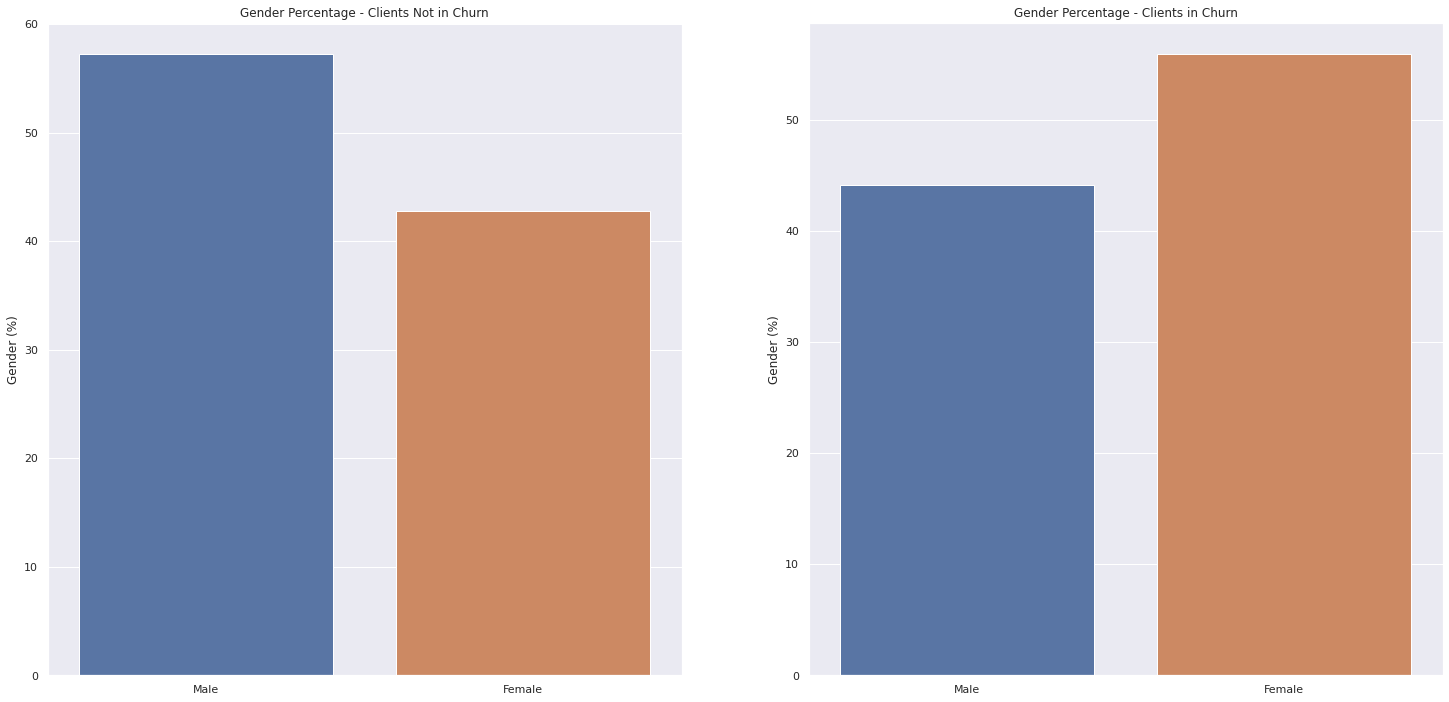

In [122]:
subplot(1, 2, 1)
sns.barplot(x = g_percentage_0.index ,y = g_percentage_0).set_title('Gender Percentage - Clients Not in Churn')
plt.ylabel('Gender (%)');

subplot(1, 2, 2)
sns.barplot(x = g_percentage_1.index ,y = g_percentage_1, order = ['Male', 'Female']).set_title('Gender Percentage - Clients in Churn')
plt.ylabel('Gender (%)');

Parafrasear
- As previously checked, 4387 clients (54.8%) are men and 3613 clients (45.2%) are women.
- For clients not in churn, 57.5% are men and 42.5% are women: the proportion of men is greater than the proportion considering the whole dataset (54.8%).
- For clients in churn, 55.6% are women and 44.4% are men: the proportion is inverse compared to the whole dataset and for client not in churn, as for both of them the proportion of men is greater than the proportion of women.
- Therefore, the hypothesis is true: churn occur more for women than men.

In [ ]:
# churn by age

### H10. Customer with higher tenure tend to have a lower churn rate
**FALSE**

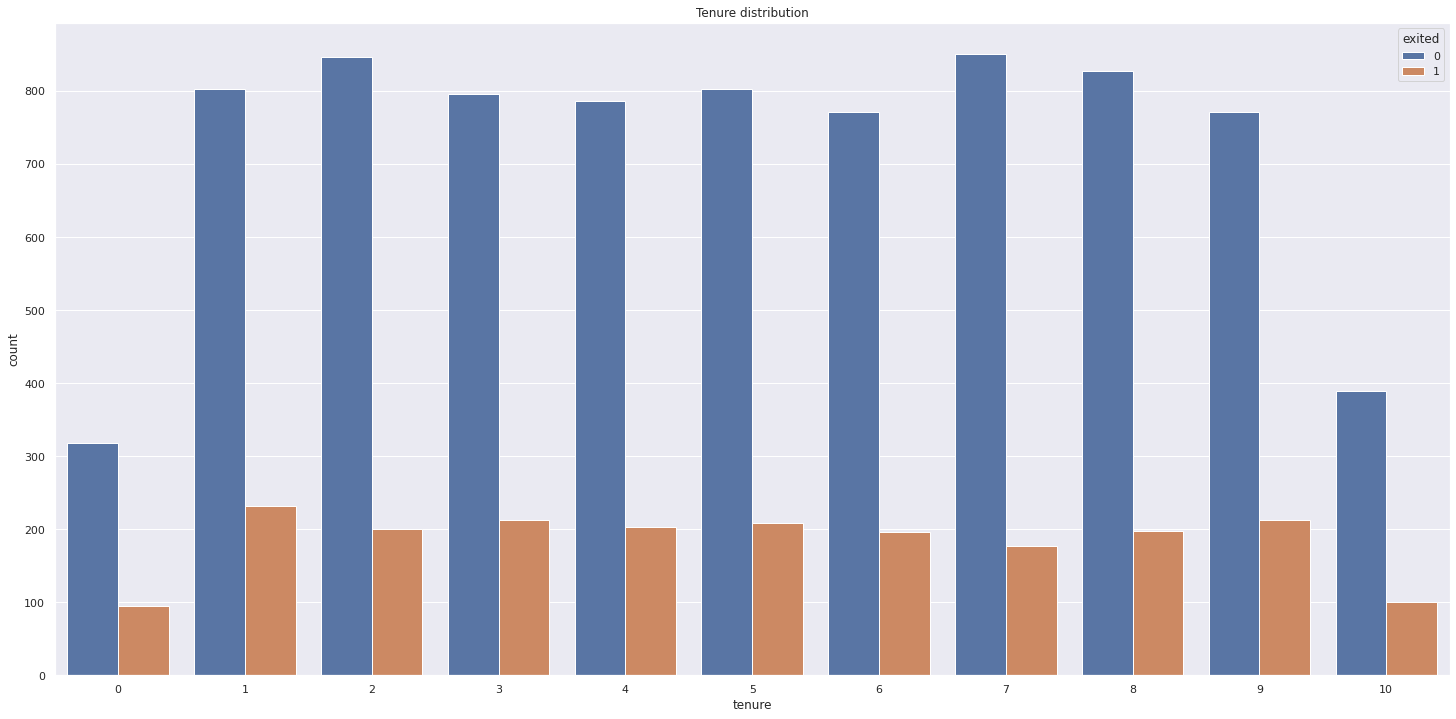

In [123]:
# churn by tenure

sns.countplot(data = df3, x = 'tenure', hue = 'exited').set_title('Tenure distribution');

In [124]:
aux_exited0.head()

,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,tenure_year,age_by_tenure,salary_by_credit,salary_by_age,salary_by_tenure,balance_by_age,balance_by_prod,all_money,money_by_credit
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,2,20.500000,185.102928,2744.940976,56271.290000,2044.094146,83807.860,196350.44,322.944803
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,2,19.500000,134.229800,2405.811026,46913.315000,0.000000,0.000,93826.63,134.229800
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,3,14.333333,93.040118,1839.165116,26361.366667,2918.856279,125510.820,204594.92,240.699906
6,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0,8,6.250000,12.241849,201.256000,1257.850000,0.000000,0.000,10062.80,12.241849
8,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0,5,8.800000,149.581836,1703.193182,14988.100000,3228.433409,71025.535,216991.57,433.116906


/home/marxcerqueira/.pyenv/versions/3.9.1/envs/Client-Churn-Prediction/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/marxcerqueira/.pyenv/versions/3.9.1/envs/Client-Churn-Prediction/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


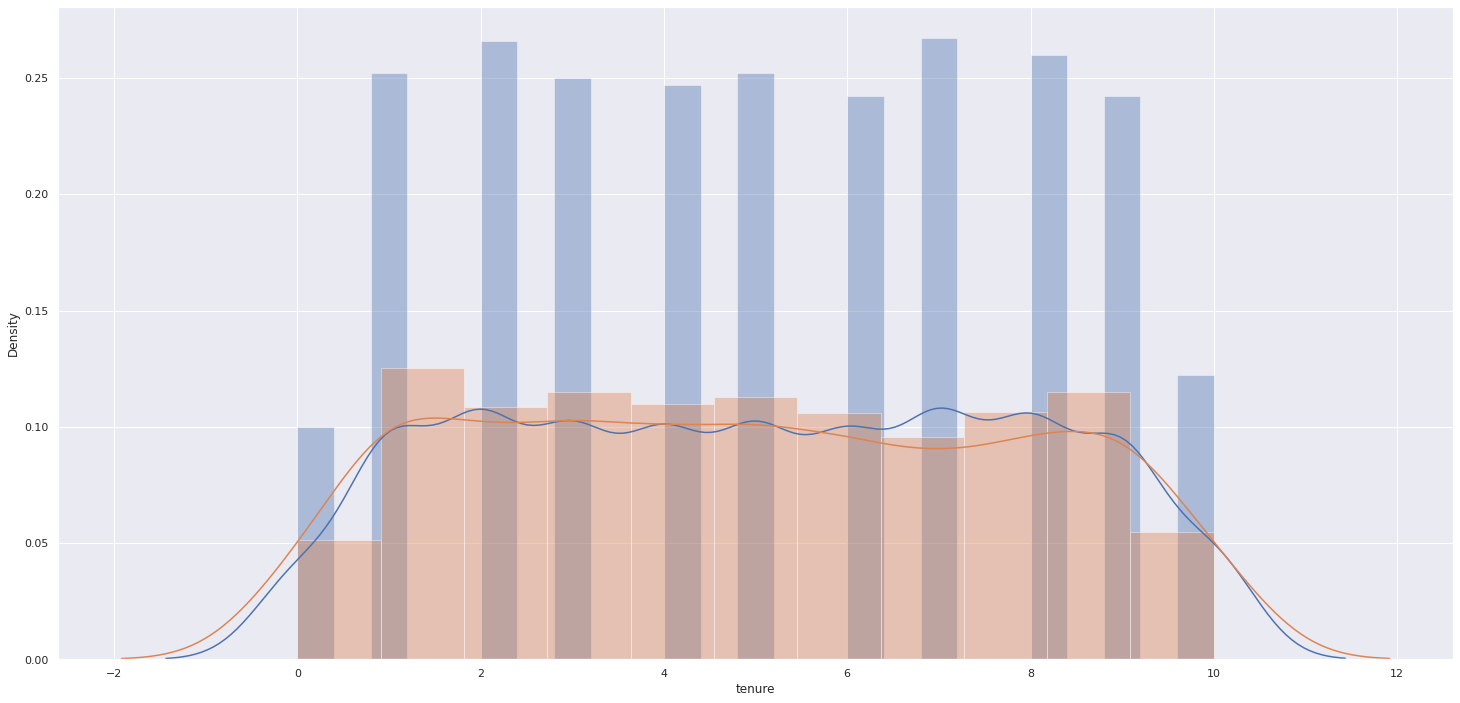

In [125]:
sns.distplot(aux_exited0['tenure'], label = 'Not Churn');
sns.distplot(aux_exited1['tenure'], label = 'Churn');

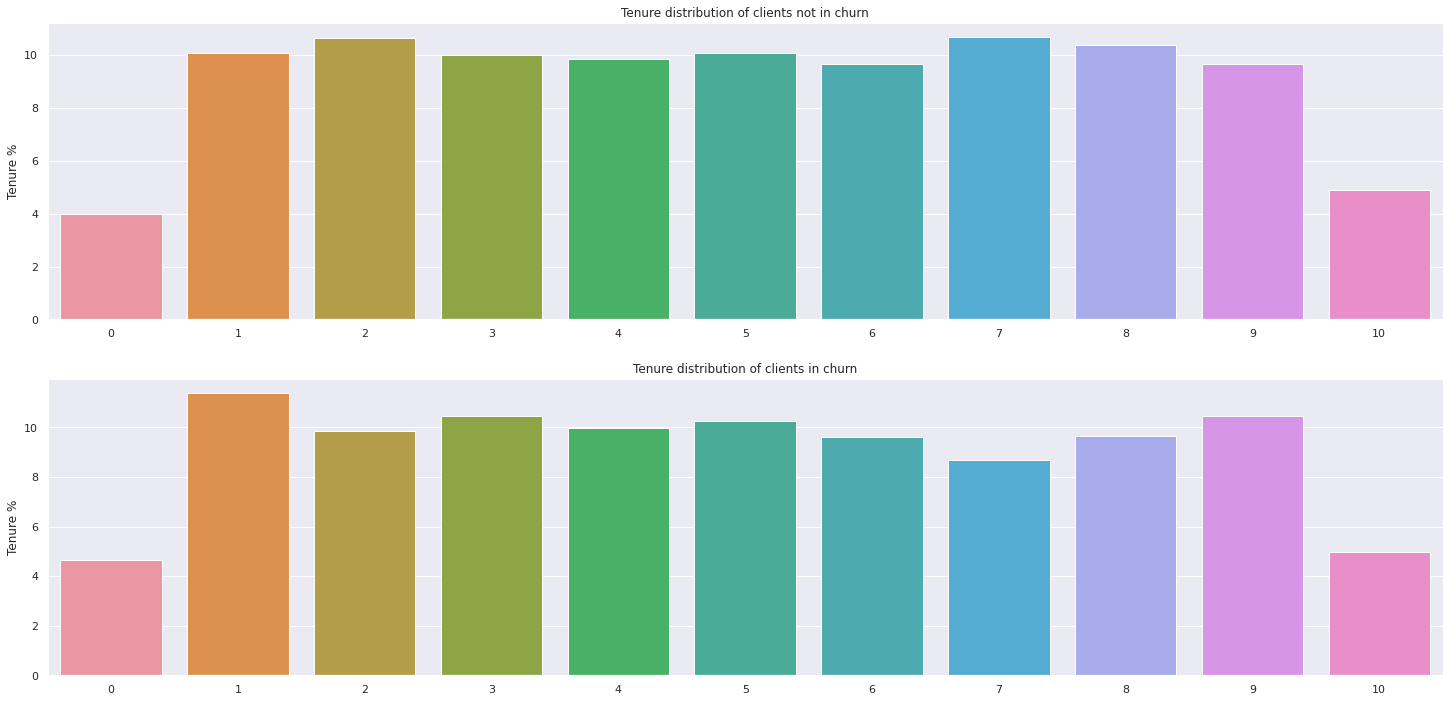

In [126]:
tenure_percentage0 = aux_exited0['tenure'].value_counts(normalize = True)*100
tenure_percentage1 = aux_exited1['tenure'].value_counts(normalize = True)*100

plt.subplot(2, 1, 1)
sns.barplot(data = aux_exited0, x = tenure_percentage0.index, y = tenure_percentage0).set_title('Tenure distribution of clients not in churn');
plt.ylabel('Tenure %')

plt.subplot(2, 1, 2)
sns.barplot(data = aux_exited0, x = tenure_percentage1.index, y = tenure_percentage1).set_title('Tenure distribution of clients in churn');
plt.ylabel('Tenure %');

In [127]:
# creating relatite percentage
aux10 =  df3[['tenure', 'balance','exited']].groupby(['tenure', 'exited']).count().reset_index()
aux10.columns = ['tenure', 'exited', 'num_of_clients']

#sum of clientes in churn

clients_churn = aux10.loc[aux9['exited'] == 1]['num_of_clients'].sum()
clients_not_churn = aux10.loc[aux9['exited'] == 0 ]['num_of_clients'].sum()

# evaluate relative percentage
aux10['relative_percentage'] = aux10.apply(lambda x: x['num_of_clients']/clients_churn*100 if x['exited'] == 1 else (x['num_of_clients']/clients_not_churn)*100, axis = 1)

aux10.head(10)

,tenure,exited,num_of_clients,relative_percentage
0,0,0,318,3.993470
1,0,1,95,4.663721
2,1,0,803,10.084139
3,1,1,232,11.389298
4,2,0,847,10.636695
5,2,1,201,9.867452
6,3,0,796,9.996233
7,3,1,213,10.456554
8,4,0,786,9.870652
9,4,1,203,9.965636


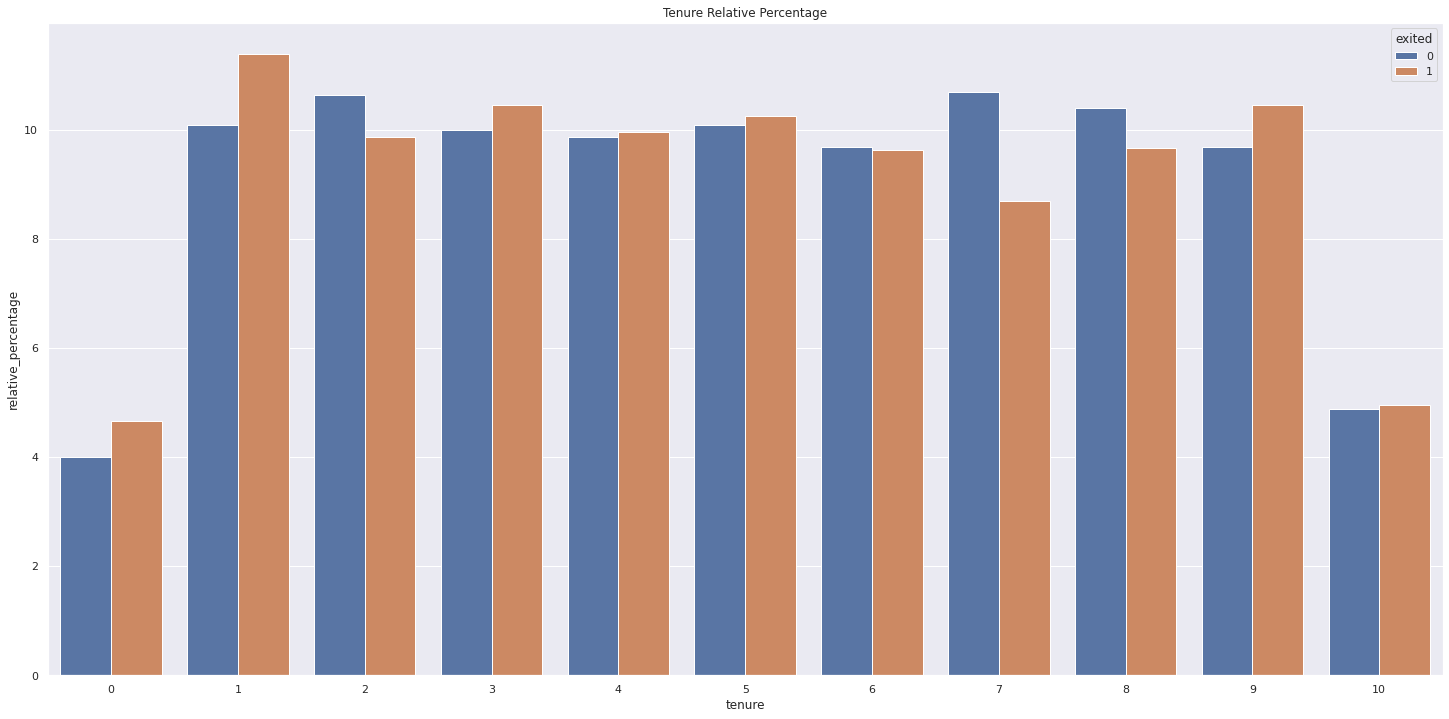

In [128]:
sns.barplot(data = aux10, x = 'tenure', y = 'relative_percentage', hue = 'exited').set_title('Tenure Relative Percentage');

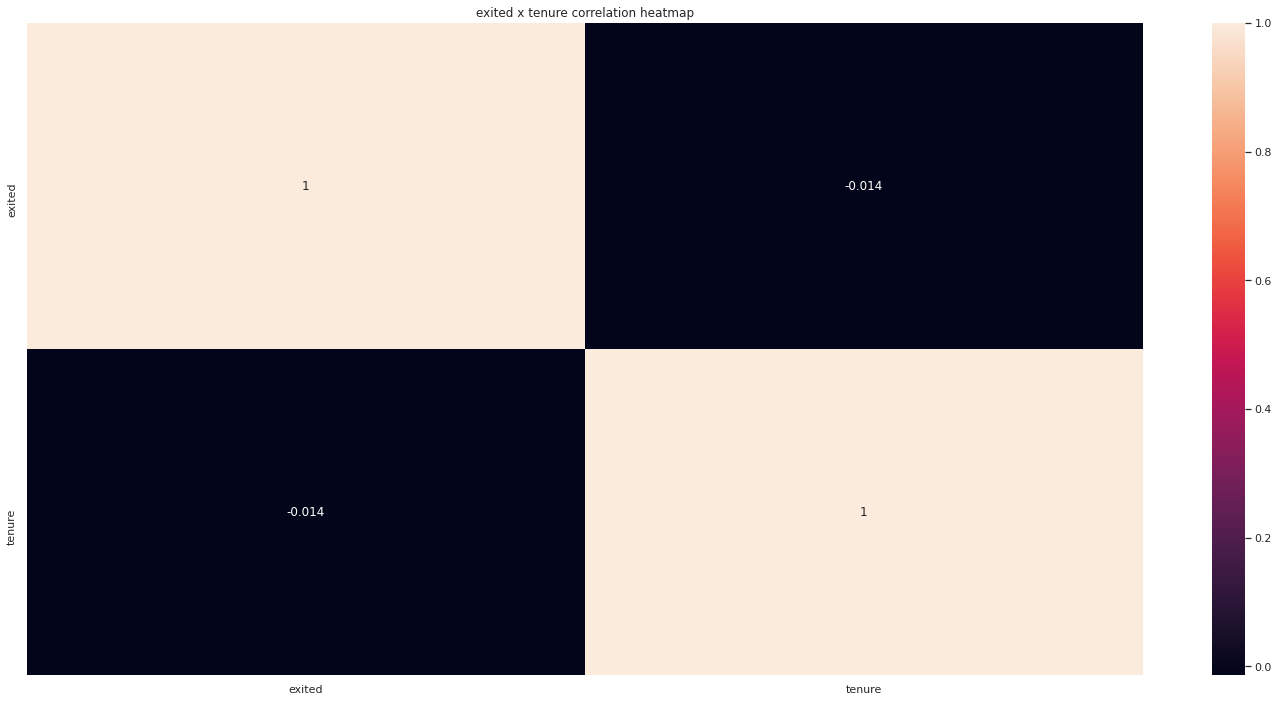

In [129]:
 # point-biserial correlation coefficient heatmap function.
point_bi_corr(df3[['exited']], df3[['tenure']]);

- The tenure for churn and not churn is evenly distributed and has a very similar distribution and proportion pattern.
- There is no clear pattern that determines, based on the tenure, if a client is in churn.
- The biggest relative percentage difference between churn and not churn are for tenure 1 (1.2%), 2 (1.2%), 7 (1.7%) and 9 (1%).
- The correlation heatmap shows a low correlation coefficient between tenure and churn (exited) of -0.0024.
- The relative tenure proportion of clients in churn is greater for the lowest and biggest tenure than the tenure proportion of clients not in churn: that happens for tenure 0, 1, 9 and 10.
- Therefore, the hypothesis is true: churn occur for clients with high tenure.

### Hypothesis Summary

- H1. Customers with higher salaries tend to be in churn TRUE

- H2. Customers with lower balances tend to be in churn FALSE

- H3. Customers who live in France tend to be in churn FALSE
- H4. Active members should not be in churn FALSE
- H5. Younger costumers tend to churn more often fALSE
- H6. Customers with credit card have more probability to churn
- H7. Customers with high credit scores have less probability to churn (*generally credit scores from 580 to 669 are considered fair; 670 to 739 are considered good; 740 to 799 are considered very good; and 800 and up are considered excellent.*)
- H8. Customers with less products tend to churn more
- H9. Womans tend to churn more often than mens
- H10. Customer with higher tenure tend to have a lower churn rate

In [130]:
summary = pd.DataFrame({'Hypothesis':['Customers with higher salaries tend to be in churn',
                                      'Customers with lower balances tend to be in churN',
                                      'Customers who live in France tend to be in churn',
                                      'Active members should not be in churn.',
                                      'Younger costumers tend to churn more often',
                                      'Customers with credit card have more probability to churn.',
                                      'Customers with high credit scores have less probability to churn',
                                      'Customers with less products tend to churn more',
                                      'Womans tend to churn more often than mens.',
                                      'Customer with higher tenure tend to have a lower churn rate',
                                     ],
                        'True / False':['True', 'False', 'False', 'False', 'False', 'False', 'False', 'True', 'True',
                                        'False'], 
                        'Relevance':['Low', 'Medium', 'Medium', 'Low', 'Medium', 'Low', 'Medium', 'High', 'Medium', 
                                     'Low',]}, 
                        index=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
summary

,Hypothesis,True / False,Relevance
1,Customers with higher salaries tend to be in c...,True,Low
2,Customers with lower balances tend to be in churN,False,Medium
3,Customers who live in France tend to be in churn,False,Medium
4,Active members should not be in churn.,False,Low
5,Younger costumers tend to churn more often,False,Medium
6,Customers with credit card have more probabili...,False,Low
7,Customers with high credit scores have less pr...,False,Medium
8,Customers with less products tend to churn more,True,High
9,Womans tend to churn more often than mens.,True,Medium
10,Customer with higher tenure tend to have a low...,False,Low


## Multivariate Analysis

### Numeric Attributes

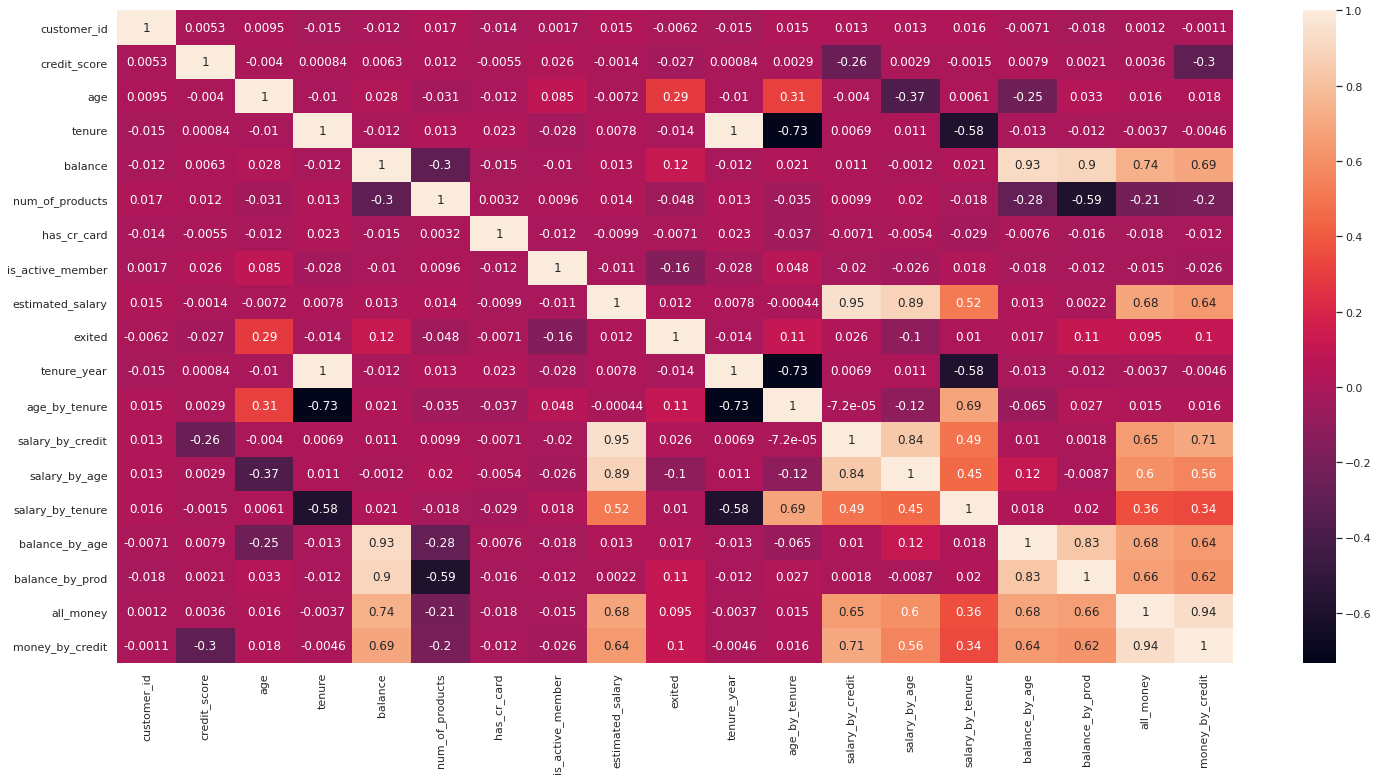

In [131]:
correlation = (num_att.corr( method = 'pearson' ))
sns.heatmap( correlation, annot = True );

## Categorical Attributes

In [138]:
# Only categorical attributes
a = df3.select_dtypes( include = 'object')

# Calculate and create cramer_v matrix

a1 = cramer_v(a['geography'], a['geography'])
a2 = cramer_v(a['geography'], a['gender'])

a3 = cramer_v(a['gender'], a['geography'])
a4 = cramer_v(a['gender'], a['gender'])

d = pd.DataFrame( {'geography': [a1, a2],
              'gender': [a3,a4]})

d = d.set_index( d.columns) # Setting index name iqual columns name
d

,geography,gender
geography,1.000100,0.026303
gender,0.026303,0.999848


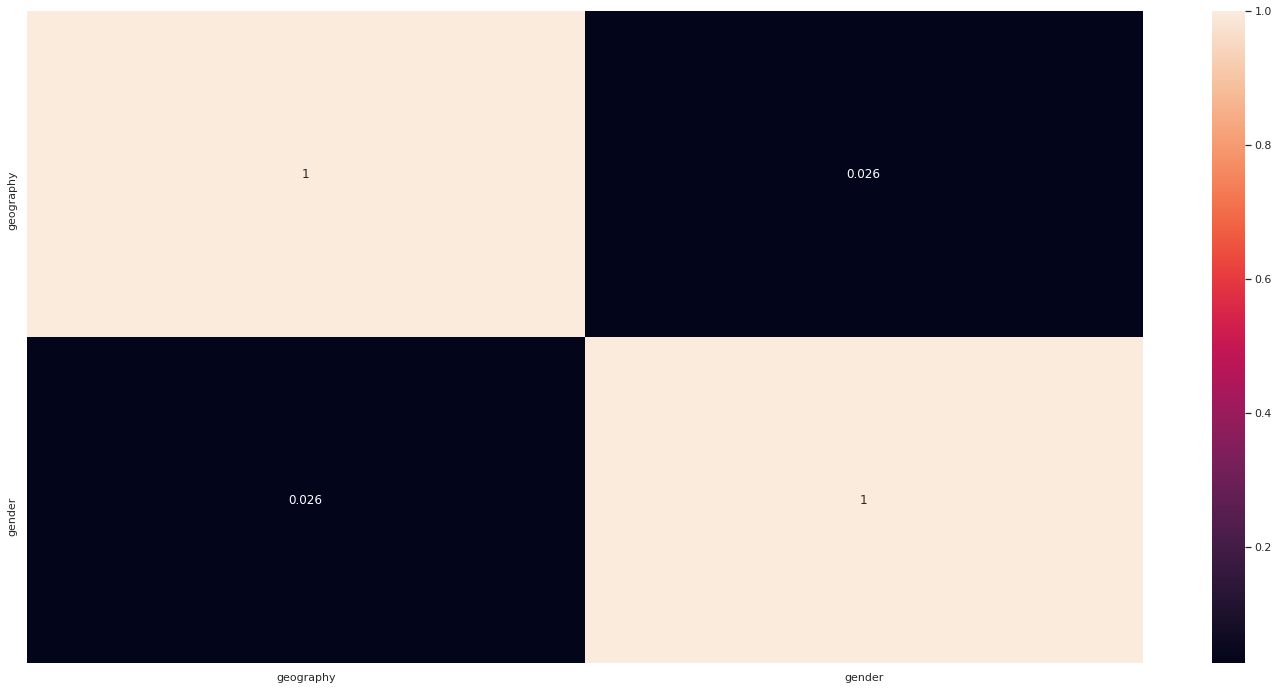

In [139]:
sns.heatmap(d, annot = True);

# DATA PREPARATION

In [140]:
df4 = df3.copy()

## Feature Normalization

## Feature Rescaling

## Feature Transformation

### Enconding

### Target Variable Transformation

### Nature Transformation

# FEATURE SELECTION

## Spliting dataframe into training and test dataset

## Feature Selector (boruta?)

## Best Features

# MACHINE LEARNING ALGORITHM MODELS

## Modelo 1

## Modelo 2

## Modelo 3

## Compare Model's Performance

# HYPERPARAMETERS FINE TUNING

# ERROR INTERPRETATION

# MODEL DEPLOYMENT